# random forest 변수 중요도 확인

- 결측치 제거 및 라벨 인코딩만 수행된 데이터를 활용
- random forest를 통해, 선정된 변수들만 활용해 여러 모델들에서 검증해본다.
- SHAP (SHapley Additive exPlanations)를 통해 변수중요도 산출


random forest hyper parameter는 어떻게 산정할것인지

참고

- 모델 : https://partrita.github.io/posts/random-forest-python/
- 변수중요도 :  https://todayisbetterthanyesterday.tistory.com/56
- shap : https://todayisbetterthanyesterday.tistory.com/57


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import sys

In [2]:
#시각화 패키지들
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
from statsmodels.graphics.mosaicplot import mosaic
plt.style.use("ggplot")

import shap
import skimage


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score


from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm


from sklearn.ensemble import GradientBoostingClassifier


import sklearn.svm as svm
import sklearn.metrics as mt
from sklearn.model_selection import GridSearchCV


from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

# VotingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import precision_score




In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.model_selection import cross_validate


In [5]:

import optuna
from optuna import Trial
from optuna.samplers import TPESampler


In [6]:
#기초 전처리 데이터 출력
x_train = pd.read_excel("../data/cip_preprocess.xlsx")
x_test = pd.read_excel("../data/cip_preprocess_test.xlsx")

y_train = pd.read_excel("../data/cip_preprocess_y.xlsx")
y_test = pd.read_excel("../data/cip_preprocess_y_test.xlsx")

In [7]:
x_train[['sex','mc','Qsofa','bed','Foley',
   'Hsp-acq','Nursing','3m-Ab','3m-Adm','1y-UTI','PPIantacid',
   'CV','CRF','total malig','NR','Leukopenia','DM','HTN']] =x_train[['sex','mc','Qsofa','bed','Foley',
   'Hsp-acq','Nursing','3m-Ab','3m-Adm','1y-UTI','PPIantacid',
   'CV','CRF','total malig','NR','Leukopenia','DM','HTN']].astype('category') 

In [8]:
x_test[['sex','mc','Qsofa','bed','Foley',
   'Hsp-acq','Nursing','3m-Ab','3m-Adm','1y-UTI','PPIantacid',
   'CV','CRF','total malig','NR','Leukopenia','DM','HTN']] =x_test[['sex','mc','Qsofa','bed','Foley',
   'Hsp-acq','Nursing','3m-Ab','3m-Adm','1y-UTI','PPIantacid',
   'CV','CRF','total malig','NR','Leukopenia','DM','HTN']].astype('category') 

In [9]:
x_train.columns

Index(['sex', 'Age', 'mc', 'iSBP', 'iDBP', 'iPR', 'iRR', 'iBT', 'iSpO',
       'Qsofa', 'bed', 'Foley', 'Hsp-acq', 'Nursing', '3m-Ab', '3m-Adm',
       '1y-UTI', 'PPIantacid', 'DM', 'HTN', 'CV', 'CRF', 'total malig', 'NR',
       'pH', 'pCO2', 'pO2', 'HCO3', 'SaO2', 'lactic acid', 'Leukopenia', 'WBC',
       'Hb', 'Plt', 'CRP', 'Glu', 'BUN', 'Cr'],
      dtype='object')

In [10]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 38 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   sex          374 non-null    category
 1   Age          374 non-null    int64   
 2   mc           374 non-null    category
 3   iSBP         374 non-null    int64   
 4   iDBP         374 non-null    int64   
 5   iPR          374 non-null    int64   
 6   iRR          374 non-null    int64   
 7   iBT          374 non-null    float64 
 8   iSpO         374 non-null    int64   
 9   Qsofa        374 non-null    category
 10  bed          374 non-null    category
 11  Foley        374 non-null    category
 12  Hsp-acq      374 non-null    category
 13  Nursing      374 non-null    category
 14  3m-Ab        374 non-null    category
 15  3m-Adm       374 non-null    category
 16  1y-UTI       374 non-null    category
 17  PPIantacid   374 non-null    category
 18  DM           374 non-null    c

In [11]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 38 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   sex          94 non-null     category
 1   Age          94 non-null     int64   
 2   mc           94 non-null     category
 3   iSBP         94 non-null     int64   
 4   iDBP         94 non-null     int64   
 5   iPR          94 non-null     int64   
 6   iRR          94 non-null     int64   
 7   iBT          94 non-null     float64 
 8   iSpO         94 non-null     int64   
 9   Qsofa        94 non-null     category
 10  bed          94 non-null     category
 11  Foley        94 non-null     category
 12  Hsp-acq      94 non-null     category
 13  Nursing      94 non-null     category
 14  3m-Ab        94 non-null     category
 15  3m-Adm       94 non-null     category
 16  1y-UTI       94 non-null     category
 17  PPIantacid   94 non-null     category
 18  DM           94 non-null     cat

In [12]:
y_train[['CIP']]

,CIP
0,1
1,0
2,0
3,0
4,0
...,...
369,1
370,1
371,1
372,1


- Random forest parameter (default)
    - n_estimators : 100 (tree 수)
    - criterion : gini
    - bootstrap : true
    - max depth : none
    - min_sample_split : 2 (The minimum number of samples required to split an internal node)
    - min_samples_leaf : 1 (The minimum number of samples required to be at a leaf node)
    - max_features : sqrt (The number of features to consider when looking for the best split) ( sqrt(n_features))
    - max_leaf_nodes : None (Grow trees with max_leaf_nodes in best-first fashion)
    - min_impurity_decrease : 0.0 

In [14]:
#rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=1234)
# out-of-bag score은 예측이 얼마나 정확한가에 대한 추정을 수치로 나타낸 것입니다.
#rf.fit(x_train, y_train['CIP'])

In [27]:
#http://aispiration.com/model/model-python-cross-validation.html


param_list = {"n_estimators": list(range(10, 500, 10)),
              "max_depth": [1,2,3,4,5],}

rf = RandomForestClassifier(oob_score=True, random_state=1234)

rf_random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions = param_list,
        n_iter = 50,
        cv = 5,
        scoring = 'accuracy')

rf_random_search.fit(x_train, y_train['CIP'])


Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(oob_score=True,
                                                    random_state=1234),
                   n_iter=50,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         120, 130, 140, 150,
                                                         160, 170, 180, 190,
                                                         200, 210, 220, 230,
                                                         240, 250, 260, 270,
                                                         280, 290, 300, ...]},
                   scoring='accuracy')

In [28]:
print('best params : ' ,rf_random_search.best_params_)
model_best=rf_random_search.best_estimator_

best params :  {'n_estimators': 180, 'max_depth': 1}


In [29]:
### parameter 반영 학습.

model_best = RandomForestClassifier(n_estimators=230, max_depth= 1,oob_score=True, random_state=1234)

model_best.fit(x_train, y_train['CIP'])

###



RandomForestClassifier(max_depth=1, n_estimators=230, oob_score=True,
                       random_state=1234)

In [30]:


predicted = model_best.predict(x_test)
accuracy = accuracy_score(y_true=y_test, y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, average=None)

#print(f'Out-of-bag score estimate: {rf_random_search.oob_score_:.3}')
print(f'accuracy score: {accuracy:.3}')
print(f'recall score: {recall[1]:.3}')

accuracy score: 0.691
recall score: 0.574


In [31]:
accuracy = accuracy_score(y_true=y_test, y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted, pos_label=1)

#print(f'Out-of-bag score estimate: {rf_random_search.oob_score_:.3}')
print(f'accuracy score: {accuracy:.3}')
print(f'recall score: {recall:.3}')
print(f'specificity score: {specificity:.3}')
print(f'f1 score: {f1:.3}')

accuracy score: 0.691
recall score: 0.574
specificity score: 0.809
f1 score: 0.651


<AxesSubplot:>

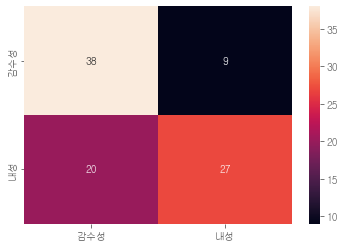

In [32]:


cm = pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=predicted), columns=['감수성','내성'], index=['감수성','내성'])
sns.heatmap(cm, annot=True)

In [33]:
print(classification_report(y_true=y_test, y_pred=predicted))

              precision    recall  f1-score   support

           0       0.66      0.81      0.72        47
           1       0.75      0.57      0.65        47

    accuracy                           0.69        94
   macro avg       0.70      0.69      0.69        94
weighted avg       0.70      0.69      0.69        94



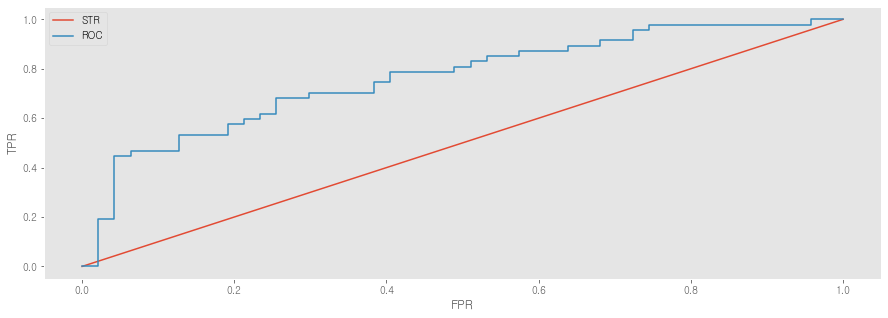

In [34]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=model_best.predict_proba(x_test)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [35]:
#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))




roc auc value 0.7618832050701675


결과, recall (내성)에 예측이 많이 실패한다.

#### recall threshold change

In [50]:
# train valid 분리
# exp : 학습 중이란 뜻
x_train_base_rf_exp, x_val_base_rf_exp,\
y_train_base_rf_exp, y_val_base_rf_exp = train_test_split(x_train,y_train,stratify=y_train,\
                                                  test_size=0.2,random_state=42)  # 훈련 데이터와 검증 데이터 분류



In [51]:
### parameter 반영 학습.

model_best = RandomForestClassifier(n_estimators=230, max_depth= 1,oob_score=True, random_state=1234)

model_best.fit(x_train_base_rf_exp, y_train_base_rf_exp['CIP'])

###



RandomForestClassifier(max_depth=1, n_estimators=230, oob_score=True,
                       random_state=1234)

In [52]:
def plot_pr_curve(test_y, model_probs,clf_name):
    # calculate the no skill line as the proportion of the positive class
    no_skill = len(test_y[test_y==1]) / len(test_y)
    # plot the no skill precision-recall curve
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # plot model precision-recall curve
    precision, recall, _ = precision_recall_curve(test_y, model_probs)
    plt.plot(recall, precision, marker='.', label=clf_name)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [53]:
x_train_base_rf_exp

,sex,Age,mc,iSBP,iDBP,iPR,iRR,iBT,iSpO,Qsofa,...,SaO2,lactic acid,Leukopenia,WBC,Hb,Plt,CRP,Glu,BUN,Cr
218,0,70,0,117,75,115,20,39.3,95,0,...,96.6,2.30,0,11850,10.4,240,25.09,397,21.1,1.87
38,0,77,0,115,57,81,20,36.0,96,0,...,93.7,1.24,0,9910,8.1,351,43.04,79,38.0,1.27
162,0,87,0,152,96,112,24,35.2,98,1,...,100.0,1.60,0,6660,8.9,410,9.64,102,16.7,1.08
114,0,87,0,120,75,105,20,38.5,96,0,...,95.9,1.66,0,19050,11.6,236,3.35,110,15.2,0.96
41,1,94,0,140,81,124,20,36.6,94,0,...,93.5,2.67,0,17770,11.5,410,4.99,147,13.8,0.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,0,73,0,137,84,81,16,38.2,97,0,...,95.9,2.25,1,3430,10.7,297,13.71,117,27.6,0.81
159,0,65,1,119,57,118,18,37.4,95,1,...,93.8,1.21,0,28770,7.2,286,18.00,153,31.6,1.22
35,1,51,0,153,52,82,18,36.8,99,0,...,99.2,1.00,0,9700,13.7,108,8.34,124,14.4,0.81
72,1,78,0,166,78,93,28,38.8,85,1,...,96.5,1.34,0,5740,11.9,152,4.59,138,29.5,1.73


15
Best Threshold=0.490695, F-Score=0.810


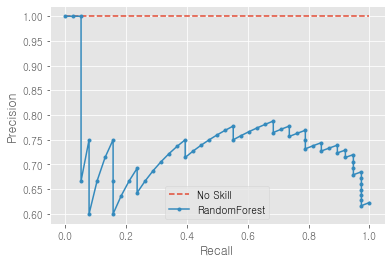

In [56]:

# optimal threshold for precision-recall curve with logistic regression model
from numpy import argmax
from sklearn.metrics import precision_recall_curve
# predict probabilities
yhat = model_best.predict_proba(x_val_base_rf_exp)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(y_val_base_rf_exp, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
print(np.where(recall > 0.89)[0][-1])
ix = np.where(recall > 0.89)[0][-1]
#ix = argmax(np.nan_to_num(recall))
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
plot_pr_curve(y_val_base_rf_exp, yhat,'RandomForest')


In [57]:

# optimal threshold for precision-recall curve with logistic regression model
from numpy import argmax
from sklearn.metrics import precision_recall_curve
# predict probabilities
yhat = model_best.predict_proba(x_test)
yhat = yhat[:, 1]
# keep probabilities for the positive outcome only
yhat[yhat>0.490695]=1
yhat[yhat !=1] = 0


In [58]:

accuracy = [accuracy_score(y_true=y_test,y_pred=yhat),]
recall = [recall_score(y_true=y_test, y_pred=yhat, pos_label=1),]
precision = [precision_score(y_true=y_test, y_pred=yhat),]
specificity = [recall_score(y_true=y_test, y_pred=yhat, pos_label=0),]
f1 = [f1_score(y_true=y_test, y_pred=yhat),]
pd.DataFrame([accuracy,recall,precision,specificity,f1])
#print(accuracy, recall,precision,specificity, f1 )

,0
0,0.712766
1,0.680851
2,0.727273
3,0.744681
4,0.703297


In [17]:


#kfold 방법

from numpy import argmax
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection  import KFold

best_thresholds = []

kf = KFold(n_splits = 10, shuffle = True, random_state = 50)


# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
for train_index, test_index in kf.split(x_train):
    X_train_exp, X_test_exp = x_train.loc[train_index], x_train.loc[test_index]
    y_train_exp, y_test_exp = y_train.loc[train_index], y_train.loc[test_index]

    model_best = RandomForestClassifier(n_estimators=230, max_depth= 1,oob_score=True, random_state=1234)
    model_best.fit(X_train_exp, y_train_exp['CIP'])

    
    # optimal threshold for precision-recall curve with logistic regression model
    # predict probabilities
    yhat = model_best.predict_proba(X_test_exp)
    # keep probabilities for the positive outcome only
    yhat = yhat[:, 1]
    # calculate roc curves
    precision, recall, thresholds = precision_recall_curve(y_test_exp['CIP'], yhat)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.where(recall > 0.87)[0][-1]
    #print(ix)
    print('VALID: .Best Threshold=%f,acc=%f, recall=%f, precision=%f, spec=%f, F-Score=%.3f' % (thresholds[ix],vaild_acc,recall[ix],precision[ix],valid_specificity,fscore[ix]))
    
    valid_accs.append(vaild_acc)
    valid_recalls.append(recall[ix])
    valid_precisions.append(precision[ix])
    valid_specificities.append(valid_specificity)
    valid_f1s.append(fscore[ix])    
    
    best_thresholds.append(thresholds[ix])
    # plot the roc curve for the model    
test_threshold = np.mean(best_thresholds)
#best_test_threshold = np.max(best_thresholds)
print(test_threshold)

#위에서는 threshold를 구하는 과정.


accs = []
recalls=[]
precisions=[]
specificities=[]
f1s=[]

# split 개수 스텝 만큼 test set에 대해 실험.
k_idx = 0
for train_index, test_index in kf.split(x_train):
    X_train_exp, X_test_exp = x_train.loc[train_index], x_train.loc[test_index]
    y_train_exp, y_test_exp = y_train.loc[train_index], y_train.loc[test_index]

    model_best = RandomForestClassifier(n_estimators=230, max_depth= 1,oob_score=True, random_state=1234)
    model_best.fit(X_train_exp, y_train_exp['CIP'])

    
    
    # optimal threshold for precision-recall curve with logistic regression model
    from numpy import argmax
    from sklearn.metrics import precision_recall_curve
    # predict probabilities
    yhat = model_best.predict_proba(x_test)
    yhat = yhat[:, 1]
    # keep probabilities for the positive outcome only
    yhat[yhat>best_thresholds[k_idx]]=1
    yhat[yhat !=1] = 0    
    
    accuracy = [accuracy_score(y_true=y_test,y_pred=yhat),]
    recall = [recall_score(y_true=y_test, y_pred=yhat, pos_label=1),]
    precision = [precision_score(y_true=y_test, y_pred=yhat),]
    specificity = [recall_score(y_true=y_test, y_pred=yhat, pos_label=0),]
    f1 = [f1_score(y_true=y_test, y_pred=yhat),]
    
    accs.append(accuracy)
    recalls.append(recall)
    precisions.append(precision)
    specificities.append(specificity)
    f1s.append(f1)
    
    #print(pd.DataFrame([accuracy,recall,precision,specificity,f1]))
    k_idx+=1
print("TEST: accs=%f recall=%f, precision=%f, specificity=%f, F-Score=%.3f" %(np.mean(accs),np.mean(recalls),np.mean(precisions),np.mean(specificities),np.mean(f1s)) ) 
    


VALID: .Best Threshold=0.425222, recall=0.900000, precision=0.600000, F-Score=0.720
VALID: .Best Threshold=0.464592, recall=0.894737, precision=0.629630, F-Score=0.739
VALID: .Best Threshold=0.433789, recall=0.888889, precision=0.500000, F-Score=0.640
VALID: .Best Threshold=0.438793, recall=0.875000, precision=0.500000, F-Score=0.636
VALID: .Best Threshold=0.444088, recall=0.875000, precision=0.608696, F-Score=0.718
VALID: .Best Threshold=0.485776, recall=0.888889, precision=0.640000, F-Score=0.744
VALID: .Best Threshold=0.440462, recall=0.933333, precision=0.482759, F-Score=0.636
VALID: .Best Threshold=0.459262, recall=0.913043, precision=0.954545, F-Score=0.933
VALID: .Best Threshold=0.401492, recall=0.913043, precision=0.636364, F-Score=0.750
VALID: .Best Threshold=0.436291, recall=0.900000, precision=0.620690, F-Score=0.735
0.4429767627319886
TEST: accs=0.634043 recall=0.814894, precision=0.607064, specificity=0.453191, F-Score=0.689


In [16]:
print("TEST: accs=%f recall=%f, precision=%f, specificity=%f, F-Score=%.3f" %(np.mean(accs),np.mean(recalls),np.mean(precisions),np.mean(specificities),np.mean(f1s)) ) 


TEST: accs=0.651064 recall=0.810638, precision=0.621646, specificity=0.491489, F-Score=0.698


# 변수 중요도



-  Weight : 변수 별 데이터를 분리하는데 쓰인 횟수 
-  Cover : 해당 변수로 분리된 데이터의 수
-  Gain : Feature을 사용했을 때 줄어드는 평균적인 training loss

3가지 방법을 통해 중요도를 나타낼 수 있다.

단점

1. 3가지 방법이 서로 다른 순위의 수치로 나타낸다면, 중요도를 파악하기 어렵다.
2. Positive or Negative 영향을 파악할 수 없다. (domain knowledge를 요구한다.)
3. Ensemble 모델에서 consistency가 보장되지 못한다. (특정 변수가 중요하다 판단하여 모델을 수정했는데, 오히려 중요도가 떨어질 수 있다.)


https://woolulu.tistory.com/28

# shap value

- shap value는 실제값과 예측값 사이의 차이를 이용해 중요도를 파악하는 방법
- 해당 변수의 값을 포함, 미포함 (수정) 의 차이를 구한다.

In [159]:

explainer = shap.TreeExplainer(model_best) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(x_test) # Shap Values 계산


In [160]:
x_test.shape

(94, 38)

In [161]:
shap.initjs() # javascript 초기화 (graph 초기화)
#shap.force_plot(explainer.expected_value[0], shap_values[0], x_train)

In [162]:
# 전체 검증 데이터 셋에 대해서 적용
#shap.force_plot(explainer.expected_value[0], shap_values[0], x_train) 

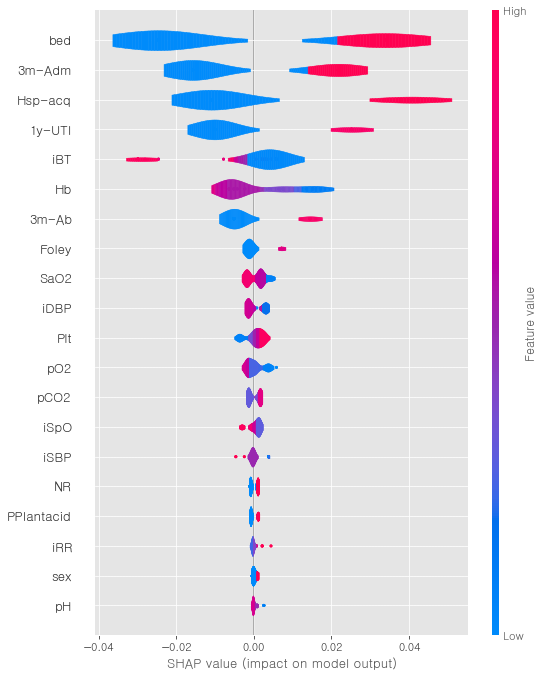

In [164]:
shap.summary_plot(shap_values[1], x_test, plot_type='violin')

내성을 양의 방향으로 Shap summary plot을 나타냈다.

결과, 총 20개의 유의한 변수를 추출했다. (기본적으로 20개만 추출된다.)

순서를 나타내면.

- category : bed, 3m-Adm, Hsp-acq, 1y-UTI,3m-Ab, Foley,PPlantacid,sex
- numeric : Hb, iBT, SaO2,iDBP,pO2,Plt pCO2,iSpO,NR,iSBP,iRR, iPR


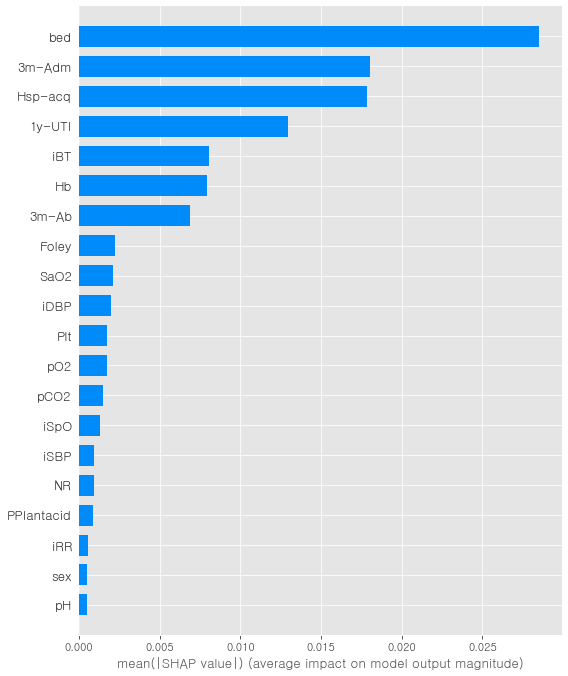

In [166]:
shap.summary_plot(shap_values[1], x_test, plot_type='bar',max_display=20)

In [167]:
print("column별 mean shap value")
mean_shap_values = []

for i,col in enumerate(list(x_train.columns)): 
    mean_shap = np.mean(np.abs(shap_values[1][:,i]))
    mean_shap_values.append(mean_shap)
    print("{}, {:.8f}".format(col,mean_shap))


column별 mean shap value
sex, 0.00051626
Age, 0.00000000
mc, 0.00000000
iSBP, 0.00095986
iDBP, 0.00200633
iPR, 0.00044919
iRR, 0.00056001
iBT, 0.00803923
iSpO, 0.00131934
Qsofa, 0.00000000
bed, 0.02848661
Foley, 0.00222391
Hsp-acq, 0.01786643
Nursing, 0.00000000
3m-Ab, 0.00688116
3m-Adm, 0.01804541
1y-UTI, 0.01296893
PPIantacid, 0.00090100
DM, 0.00000000
HTN, 0.00000000
CV, 0.00031758
CRF, 0.00000000
total malig, 0.00000000
NR, 0.00095292
pH, 0.00047267
pCO2, 0.00148041
pO2, 0.00173459
HCO3, 0.00037229
SaO2, 0.00209448
lactic acid, 0.00000000
Leukopenia, 0.00000000
WBC, 0.00044127
Hb, 0.00793742
Plt, 0.00173623
CRP, 0.00030865
Glu, 0.00000000
BUN, 0.00000000
Cr, 0.00026631


In [168]:
origin_shap_df=pd.DataFrame({ "col":list(x_train.columns),"mean_shap_values":mean_shap_values})
origin_shap_df=origin_shap_df.sort_values("mean_shap_values",ascending=False)
origin_shap_df.to_excel("origin_shap_val2.xlsx",index=False)

In [169]:
sorted_list=list(origin_shap_df.sort_values(by='mean_shap_values',ascending=False)['col'])

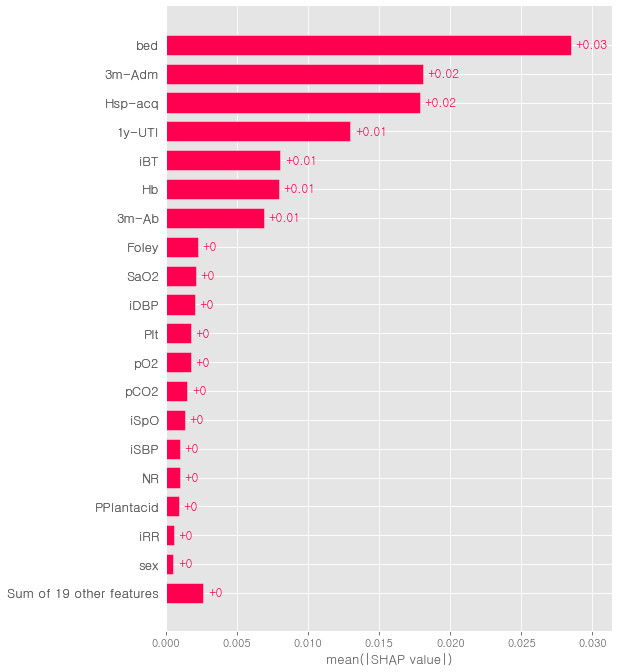

In [170]:
#전역 막대 플롯

shap.plots.bar(shap_values_bar[:,:,1],max_display=20)

# 변수 선택 및 분류

- logistic regression
- svm (종류?)
- random forest


5,10,15,20 증가시켜서 실험해본다.

In [13]:
origin_shap_df = pd.read_excel("./origin_shap_val.xlsx")
origin_shap_df

,col,mean_shap_values
0,bed,0.028555
1,3m-Adm,0.018249
2,Hsp-acq,0.017348
3,1y-UTI,0.014276
4,3m-Ab,0.007518
5,Hb,0.007509
6,iBT,0.007305
7,SaO2,0.002183
8,Foley,0.002119
9,iDBP,0.001949


In [14]:
col_all = origin_shap_df['col'].tolist()

In [15]:
#기초 전처리 데이터 출력
x_train_rftree = x_train.copy()
x_test_rftree = x_test.copy()

In [16]:
col_all[:20]

['bed',
 '3m-Adm',
 'Hsp-acq',
 '1y-UTI',
 '3m-Ab',
 'Hb',
 'iBT',
 'SaO2',
 'Foley',
 'iDBP',
 'pO2',
 'Plt',
 'pCO2',
 'iSpO',
 'NR',
 'PPIantacid',
 'iSBP',
 'iRR',
 'sex',
 'iPR']

## logistic regression

- https://bkshin.tistory.com/entry/DATA-22-%EB%A1%9C%EC%A7%80%EC%8A%A4%ED%8B%B1-%ED%9A%8C%EA%B7%80Logistic-Regression

- https://3months.tistory.com/28

In [18]:
test_logistic = pd.DataFrame(columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1'])
test_logistic

,name,AUC,ACC,RECALL,SPECIFICITY,F1


In [19]:
names=[]
aucs=[]
accs=[]
recalls_list=[]
specificitys=[]
f1s=[]

In [20]:
import statsmodels.api as sm

numeric_cols=[]
for idx,col in enumerate(x_train.columns):
    col_type = x_train[col].dtype
    if col_type.name !='category':
        numeric_cols.append(col)

In [21]:
#표준화


scaler = StandardScaler()

x_train_base_logistic = x_train.copy()
x_test_base_logistic = x_test.copy()


x_train_base_logistic[numeric_cols] = scaler.fit_transform(x_train_base_logistic[numeric_cols])
x_test_base_logistic[numeric_cols] = scaler.transform(x_test_base_logistic[numeric_cols])




In [22]:
x_train_rftree_logistic20=x_train_base_logistic[col_all[:20]]
x_test_rftree_logistic20=x_test_base_logistic[col_all[:20]]

x_train_rftree_logistic10=x_train_base_logistic[col_all[:10]]
x_test_rftree_logistic10=x_test_base_logistic[col_all[:10]]

x_train_rftree_logistic15=x_train_base_logistic[col_all[:15]]
x_test_rftree_logistic15=x_test_base_logistic[col_all[:15]]

x_train_rftree_logistic17=x_train_base_logistic[col_all[:17]]
x_test_rftree_logistic17=x_test_base_logistic[col_all[:17]]

x_train_rftree_logistic25=x_train_base_logistic[col_all[:25]]
x_test_rftree_logistic25=x_test_base_logistic[col_all[:25]]

x_train_rftree_logistic30=x_train_base_logistic[col_all[:30]]
x_test_rftree_logistic30=x_test_base_logistic[col_all[:30]]




### baseline

In [23]:
x_train_base_logistic

,sex,Age,mc,iSBP,iDBP,iPR,iRR,iBT,iSpO,Qsofa,...,SaO2,lactic acid,Leukopenia,WBC,Hb,Plt,CRP,Glu,BUN,Cr
0,1,-0.058608,1,-1.085320,-0.436054,-1.071046,-0.647628,-0.190722,0.944275,2,...,-0.063714,-0.144962,0,0.655870,-0.130783,-0.416052,-0.069916,-0.710952,-0.206676,-0.278879
1,1,0.630679,0,-0.287102,-0.770929,-0.459287,-0.119356,-0.119012,0.532907,0,...,-0.001792,-0.733284,0,-0.974371,-0.381665,0.726910,0.084745,-0.669646,-0.349045,-0.543982
2,0,-0.610037,0,2.011765,1.238321,1.288597,1.993733,0.046475,0.121540,1,...,-0.015061,0.014044,0,-0.657833,0.036472,0.434085,0.091326,0.135818,-0.265184,-0.435222
3,1,-0.334322,0,-0.414817,0.233696,-0.852560,-0.119356,-0.102463,0.327224,0,...,0.013689,1.445098,1,-1.733763,-0.121491,-1.115054,1.885832,-0.628341,-0.115014,0.142566
4,0,-1.161466,0,1.181619,0.345321,0.414655,-0.119356,0.018894,-0.701194,0,...,-0.085829,-0.579578,0,-0.157021,-0.028571,0.849708,0.308509,0.817365,-0.196925,-0.421627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,0,0.079250,0,0.830403,-0.212804,0.982717,-0.647628,0.013378,0.738591,0,...,0.002631,-0.547777,0,-0.351699,0.101516,0.282950,-0.739017,-0.173976,-0.331493,-0.496399
370,1,0.079250,1,-1.244964,-0.603491,0.764232,3.050277,-0.008687,0.121540,3,...,-0.110155,-0.266866,0,1.126961,0.017888,1.218101,0.420392,0.579856,0.680695,0.366883
371,1,0.492821,1,-0.638318,-0.603491,0.589443,0.937189,-0.113495,-3.169397,2,...,-0.256115,-0.558377,0,0.131281,-0.186535,1.680953,-0.613972,-1.423478,-0.079909,0.665973
372,0,0.630679,0,-0.223245,-0.603491,0.152472,-0.647628,-0.052817,0.327224,0,...,0.064553,-0.706783,0,-0.107980,-0.353790,3.069511,-0.635909,-0.700626,-0.374399,-0.346854


In [24]:


logit_mod = sm.Logit(y_train['CIP'], x_train_base_logistic)
results = logit_mod.fit()

#model_logistic = LogisticRegression( )
#model_logistic.fit( x_train_base_logistic, y_train['CIP'] )
#model_logistic.predict( x_test_base_logistic )

predicted = results.predict(x_test_base_logistic)
predicted = (predicted>0.5).astype(int)


print('Baseline accuracy : ' ,accuracy_score(y_pred = predicted, y_true = y_test['CIP']))
print('Baseline recall : ' ,recall_score(y_pred = predicted, y_true = y_test['CIP'],average=None)[1] )


Optimization terminated successfully.
         Current function value: 0.544607
         Iterations 9
Baseline accuracy :  0.6595744680851063
Baseline recall :  0.574468085106383


In [25]:
results.pvalues[results.pvalues<0.05]

iRR        0.031350
bed        0.037054
Hsp-acq    0.003533
1y-UTI     0.004924
HTN        0.002025
SaO2       0.037970
BUN        0.022823
Cr         0.014980
dtype: float64

In [26]:
results.params

sex           -0.324799
Age            0.085425
mc             0.182486
iSBP          -0.231583
iDBP           0.004754
iPR           -0.139792
iRR            0.386804
iBT           -0.128245
iSpO           0.173042
Qsofa         -0.498886
bed            0.862340
Foley         -0.223989
Hsp-acq        1.417703
Nursing        0.319970
3m-Ab          0.610933
3m-Adm        -0.045952
1y-UTI         0.923322
PPIantacid    -0.016709
DM             0.005928
HTN           -0.835299
CV             0.118674
CRF            0.276321
total malig   -0.538976
NR            -0.402984
pH             0.046258
pCO2           0.044448
pO2            0.087218
HCO3           0.263883
SaO2          -4.209524
lactic acid    0.067524
Leukopenia     0.256474
WBC            0.046932
Hb            -1.087778
Plt            0.018371
CRP           -0.012346
Glu            0.044601
BUN           -1.356735
Cr             0.867818
dtype: float64

In [27]:
params_logit=np.exp(results.params)
params_logit.sort_values(ascending=False)

Hsp-acq        4.127629
1y-UTI         2.517641
Cr             2.381708
bed            2.368696
3m-Ab          1.842149
iRR            1.472267
Nursing        1.377087
CRF            1.318271
HCO3           1.301976
Leukopenia     1.292365
mc             1.200197
iSpO           1.188916
CV             1.126003
pO2            1.091134
Age            1.089180
lactic acid    1.069856
WBC            1.048051
pH             1.047344
Glu            1.045611
pCO2           1.045451
Plt            1.018541
DM             1.005946
iDBP           1.004765
CRP            0.987730
PPIantacid     0.983430
3m-Adm         0.955088
iBT            0.879638
iPR            0.869539
Foley          0.799324
iSBP           0.793277
sex            0.722673
NR             0.668323
Qsofa          0.607207
total malig    0.583345
HTN            0.433745
Hb             0.336965
BUN            0.257500
SaO2           0.014853
dtype: float64

In [28]:
params_logit.to_csv("./stat_logit.csv",index=True)

In [29]:
confusion_matrix(y_pred = predicted,y_true = y_test['CIP'])

array([[35, 12],
       [20, 27]], dtype=int64)

In [30]:
print(classification_report(y_pred=predicted,y_true=y_test['CIP']) )

              precision    recall  f1-score   support

           0       0.64      0.74      0.69        47
           1       0.69      0.57      0.63        47

    accuracy                           0.66        94
   macro avg       0.66      0.66      0.66        94
weighted avg       0.66      0.66      0.66        94



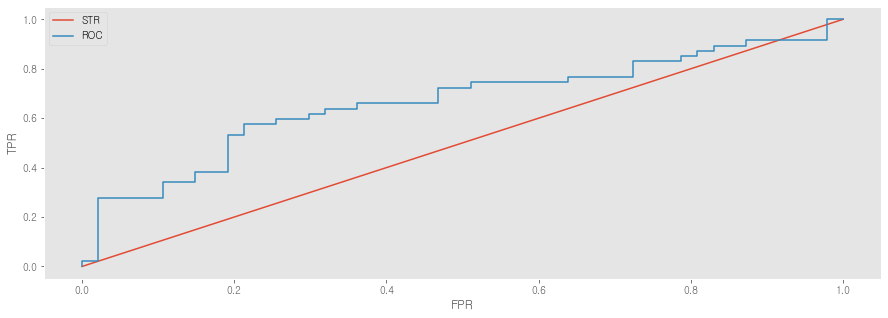

In [31]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=results.predict(x_test_base_logistic)
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [32]:
#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))




roc auc value 0.6636487098234495


In [33]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('logistic_base')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


#### logistic regression SHAP

linear explainer

In [57]:
model = LogisticRegression()
model.fit(x_train_base_logistic, y_train['CIP'])

LogisticRegression()

In [58]:
predicted = results.predict(x_test_base_logistic)
predicted = (predicted>0.5).astype(int)


print('Baseline accuracy : ' ,accuracy_score(y_pred = predicted, y_true = y_test['CIP']))
print('Baseline recall : ' ,recall_score(y_pred = predicted, y_true = y_test['CIP'],average=None)[1] )


Baseline accuracy :  0.6595744680851063
Baseline recall :  0.574468085106383


In [59]:
features=x_train_base_logistic.columns.tolist()

In [60]:
explainer = shap.Explainer(model,x_train_base_logistic) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(x_train_base_logistic)

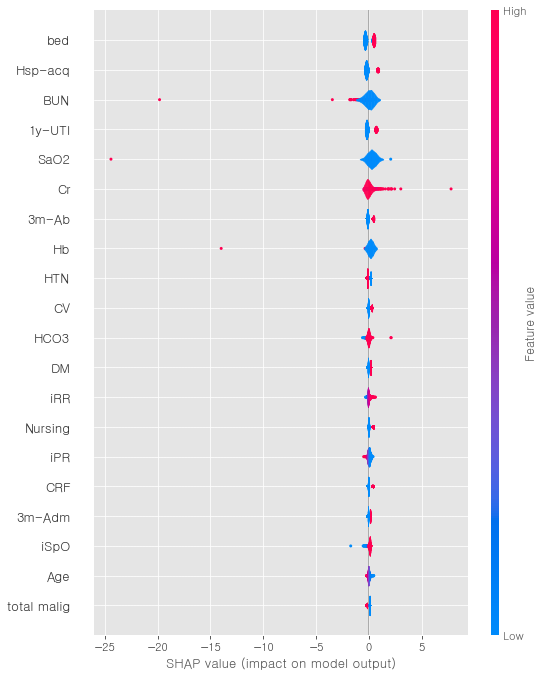

In [61]:
shap.summary_plot(shap_values,x_train_base_logistic,feature_names=features,plot_type='violin')

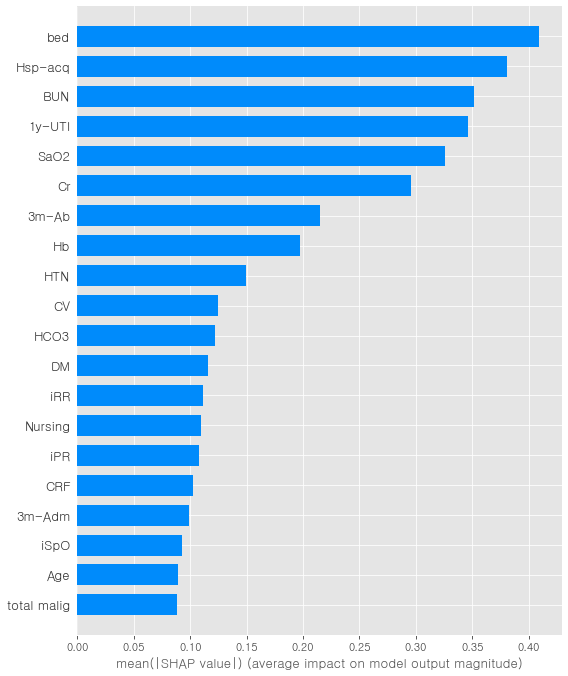

In [62]:
shap.summary_plot(shap_values, x_train_base_logistic, plot_type='bar',max_display=20)

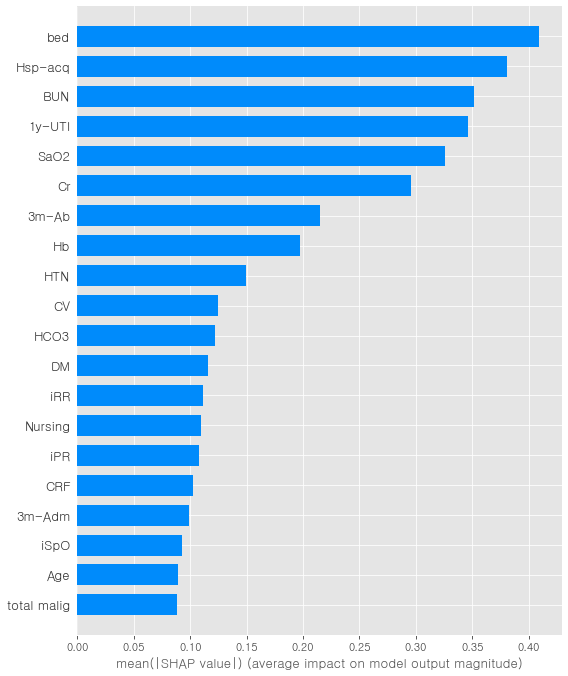

In [63]:
shap.summary_plot(shap_values, x_train_base_logistic, plot_type='bar',max_display=20,show=False)
plt.savefig('./FIGURES/logistic_shap.png')



In [64]:
shap_values.shape

(374, 38)

In [65]:
print("column별 mean shap value")
mean_shap_values = []

for i,col in enumerate(list(x_train_base_logistic.columns)): 
    mean_shap = np.mean(np.abs(shap_values[:,i]))
    mean_shap_values.append(mean_shap)
    print("{}, {:.8f}".format(col,mean_shap))


column별 mean shap value
sex, 0.00936237
Age, 0.08872737
mc, 0.02875933
iSBP, 0.05672659
iDBP, 0.03413366
iPR, 0.10798755
iRR, 0.11106018
iBT, 0.05980649
iSpO, 0.09264819
Qsofa, 0.00923973
bed, 0.40873734
Foley, 0.01017975
Hsp-acq, 0.38052245
Nursing, 0.10960415
3m-Ab, 0.21505767
3m-Adm, 0.09869635
1y-UTI, 0.34624134
PPIantacid, 0.08337337
DM, 0.11584022
HTN, 0.14950518
CV, 0.12433821
CRF, 0.10224901
total malig, 0.08838180
NR, 0.00520010
pH, 0.00503552
pCO2, 0.01138008
pO2, 0.03795187
HCO3, 0.12157856
SaO2, 0.32624371
lactic acid, 0.01177823
Leukopenia, 0.04052150
WBC, 0.03020425
Hb, 0.19750366
Plt, 0.02980481
CRP, 0.04192231
Glu, 0.02403241
BUN, 0.35109829
Cr, 0.29600571


In [67]:
origin_shap_df=pd.DataFrame({ "col":list(x_train.columns),"mean_shap_values":mean_shap_values})
origin_shap_df=origin_shap_df.sort_values("mean_shap_values",ascending=False)
origin_shap_df=origin_shap_df[:20]
origin_shap_df.to_excel("./values/logitic_shap_val.xlsx",index=False)

In [68]:
origin_shap_df[-1]/origin_shap_df[-20]

2.5552930745649616

### reduced (20개)

In [41]:
x_train_rftree_logistic20.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   bed         374 non-null    category
 1   3m-Adm      374 non-null    category
 2   Hsp-acq     374 non-null    category
 3   1y-UTI      374 non-null    category
 4   3m-Ab       374 non-null    category
 5   Hb          374 non-null    float64 
 6   iBT         374 non-null    float64 
 7   SaO2        374 non-null    float64 
 8   Foley       374 non-null    category
 9   iDBP        374 non-null    float64 
 10  pO2         374 non-null    float64 
 11  Plt         374 non-null    float64 
 12  pCO2        374 non-null    float64 
 13  iSpO        374 non-null    float64 
 14  NR          374 non-null    category
 15  PPIantacid  374 non-null    category
 16  iSBP        374 non-null    float64 
 17  iRR         374 non-null    float64 
 18  sex         374 non-null    category
 19  iPR     

In [192]:

logit_mod = sm.Logit(y_train['CIP'], x_train_rftree_logistic20)
results = logit_mod.fit()

predicted = results.predict(x_test_rftree_logistic20)
predicted = (predicted>0.5).astype(int)


print('Baseline accuracy : ' ,accuracy_score(y_pred=predicted,y_true=y_test['CIP']))
print('Baseline recall : ' ,recall_score(y_pred=predicted,y_true=y_test['CIP'],average=None)[1] )


Optimization terminated successfully.
         Current function value: 0.595257
         Iterations 9
Baseline accuracy :  0.6276595744680851
Baseline recall :  0.7446808510638298


In [193]:
confusion_matrix(y_pred = predicted,y_true = y_test['CIP'])

array([[24, 23],
       [12, 35]], dtype=int64)

In [194]:
print(classification_report(y_pred=predicted,y_true=y_test['CIP']) )

              precision    recall  f1-score   support

           0       0.67      0.51      0.58        47
           1       0.60      0.74      0.67        47

    accuracy                           0.63        94
   macro avg       0.64      0.63      0.62        94
weighted avg       0.64      0.63      0.62        94



In [195]:
results.pvalues[results.pvalues<0.05]

bed        0.040208
Hsp-acq    0.002366
1y-UTI     0.014583
NR         0.019446
dtype: float64

In [196]:
np.exp(results.params)

bed           1.967540
3m-Adm        0.841114
Hsp-acq       3.485929
1y-UTI        2.113642
iBT           0.868151
Hb            0.347754
3m-Ab         1.625347
Foley         0.944788
SaO2          0.228627
iDBP          0.987737
Plt           1.118579
pO2           0.961210
pCO2          1.149415
iSpO          1.073320
iSBP          0.879048
NR            0.511147
PPIantacid    0.676203
iRR           1.161667
sex           0.791998
pH            1.074920
dtype: float64

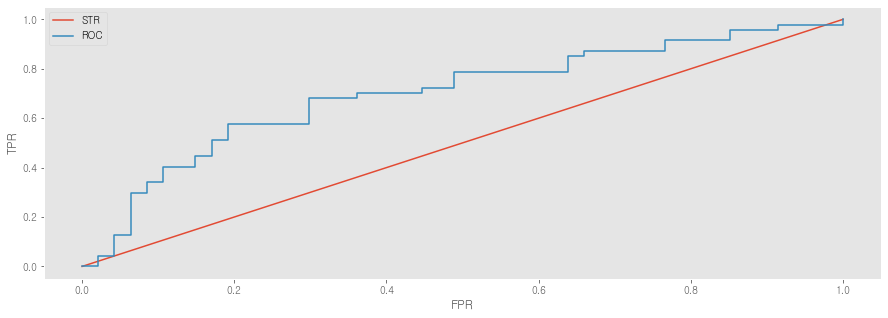

In [197]:
#logistic - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=results.predict(x_test_rftree_logistic20)
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [198]:
#logistic - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))


roc auc value 0.7003168854685378


In [199]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('logistic_20')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 10

In [200]:

logit_mod = sm.Logit(y_train['CIP'], x_train_rftree_logistic10)
results = logit_mod.fit()

predicted = results.predict(x_test_rftree_logistic10)
predicted = (predicted>0.5).astype(int)


print('Baseline accuracy : ' ,accuracy_score(y_pred=predicted,y_true=y_test['CIP']))
print('Baseline recall : ' ,recall_score(y_pred=predicted,y_true=y_test['CIP'],average=None)[1] )


Optimization terminated successfully.
         Current function value: 0.618277
         Iterations 8
Baseline accuracy :  0.5212765957446809
Baseline recall :  0.7872340425531915


In [201]:
confusion_matrix(y_pred = predicted,y_true = y_test['CIP'])

array([[12, 35],
       [10, 37]], dtype=int64)

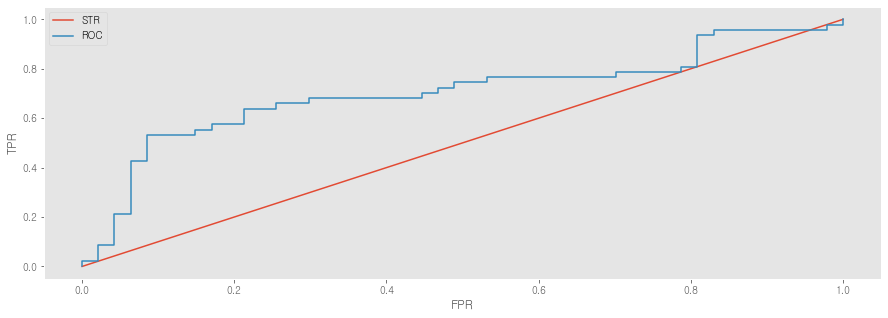

In [202]:
#logistic - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=results.predict(x_test_rftree_logistic10)
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [203]:
#logistic - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))


roc auc value 0.7025803531009507


In [204]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('logistic_10')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 15

In [205]:

logit_mod = sm.Logit(y_train['CIP'], x_train_rftree_logistic15)
results = logit_mod.fit()

predicted = results.predict(x_test_rftree_logistic15)
predicted = (predicted>0.5).astype(int)


print('Baseline accuracy : ' ,accuracy_score(y_pred=predicted,y_true=y_test['CIP']))
print('Baseline recall : ' ,recall_score(y_pred=predicted,y_true=y_test['CIP'],average=None)[1] )


Optimization terminated successfully.
         Current function value: 0.613340
         Iterations 10
Baseline accuracy :  0.648936170212766
Baseline recall :  0.851063829787234


In [206]:
confusion_matrix(y_pred = predicted,y_true = y_test['CIP'])

array([[21, 26],
       [ 7, 40]], dtype=int64)

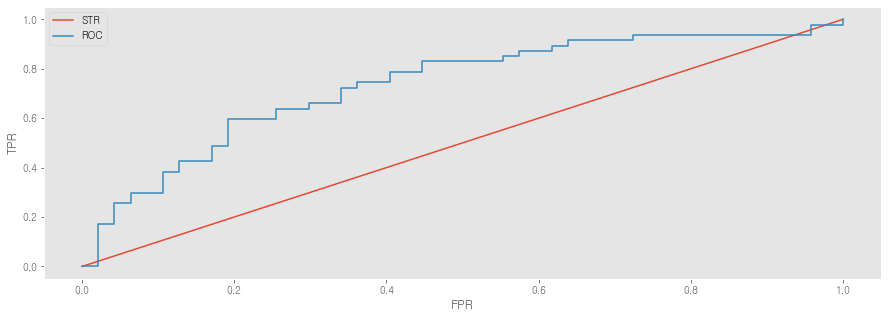

In [207]:
#logistic - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=results.predict(x_test_rftree_logistic15)
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [208]:
#logistic - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))


roc auc value 0.7333635129017655


In [209]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('logistic_15')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 17

In [210]:

logit_mod = sm.Logit(y_train['CIP'], x_train_rftree_logistic17)
results = logit_mod.fit()

predicted = results.predict(x_test_rftree_logistic17)
predicted = (predicted>0.5).astype(int)


print('Baseline accuracy : ' ,accuracy_score(y_pred=predicted,y_true=y_test['CIP']))
print('Baseline recall : ' ,recall_score(y_pred=predicted,y_true=y_test['CIP'],average=None)[1] )


Optimization terminated successfully.
         Current function value: 0.598576
         Iterations 9
Baseline accuracy :  0.5957446808510638
Baseline recall :  0.7659574468085106


In [211]:
confusion_matrix(y_pred = predicted,y_true = y_test['CIP'])

array([[20, 27],
       [11, 36]], dtype=int64)

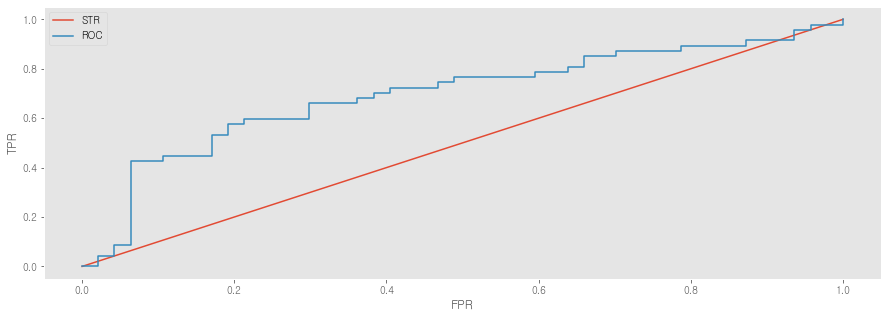

In [212]:
#logistic - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=results.predict(x_test_rftree_logistic17)
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [213]:
#logistic - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))


roc auc value 0.6962426437301947


In [214]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('logistic_17')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 25

In [215]:

logit_mod = sm.Logit(y_train['CIP'], x_train_rftree_logistic25)
results = logit_mod.fit()

predicted = results.predict(x_test_rftree_logistic25)
predicted = (predicted>0.5).astype(int)


print('Baseline accuracy : ' ,accuracy_score(y_pred=predicted,y_true=y_test['CIP']))
print('Baseline recall : ' ,recall_score(y_pred=predicted,y_true=y_test['CIP'],average=None)[1] )


Optimization terminated successfully.
         Current function value: 0.590603
         Iterations 9
Baseline accuracy :  0.648936170212766
Baseline recall :  0.7446808510638298


In [216]:
confusion_matrix(y_pred = predicted,y_true = y_test['CIP'])

array([[26, 21],
       [12, 35]], dtype=int64)

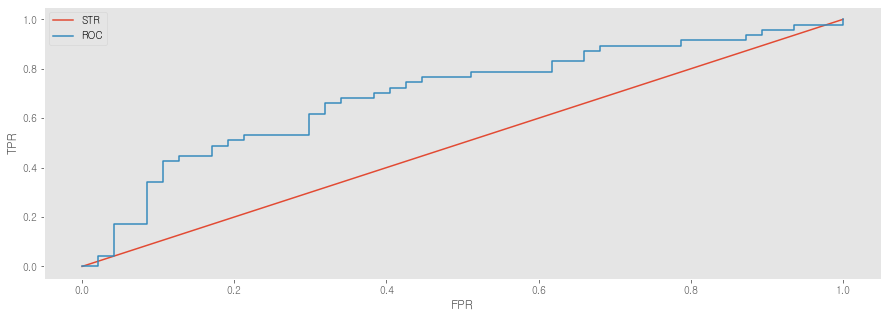

In [217]:
#logistic - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=results.predict(x_test_rftree_logistic25)
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [218]:
#logistic - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))


roc auc value 0.694884563150747


In [219]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('logistic_25')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 30

In [220]:

logit_mod = sm.Logit(y_train['CIP'], x_train_rftree_logistic30)
results = logit_mod.fit()

predicted = results.predict(x_test_rftree_logistic30)
predicted = (predicted>0.5).astype(int)


print('Baseline accuracy : ' ,accuracy_score(y_pred=predicted,y_true=y_test['CIP']))
print('Baseline recall : ' ,recall_score(y_pred=predicted,y_true=y_test['CIP'],average=None)[1] )


Optimization terminated successfully.
         Current function value: 0.579174
         Iterations 9
Baseline accuracy :  0.6276595744680851
Baseline recall :  0.723404255319149


In [221]:
confusion_matrix(y_pred = predicted,y_true = y_test['CIP'])

array([[25, 22],
       [13, 34]], dtype=int64)

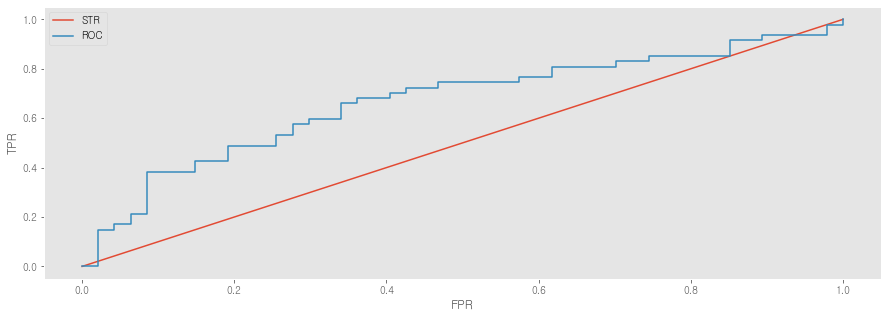

In [223]:
#logistic - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=results.predict(x_test_rftree_logistic30)
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [224]:
#logistic - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))


roc auc value 0.6686283386147578


In [225]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('logistic_30')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


In [226]:
test_logistic= pd.concat([pd.DataFrame(names),
                     pd.DataFrame(aucs),
                     pd.DataFrame(accs),
                     pd.DataFrame(recalls_list),
                     pd.DataFrame(specificitys),
                     pd.DataFrame(f1s)
                    ],axis=1)
test_logistic.columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1']

In [227]:
test_logistic.sort_values('name')

,name,AUC,ACC,RECALL,SPECIFICITY,F1
2,logistic_10,0.702580,0.521277,0.787234,0.255319,0.621849
3,logistic_15,0.733364,0.648936,0.851064,0.446809,0.707965
4,logistic_17,0.696243,0.595745,0.765957,0.425532,0.654545
1,logistic_20,0.700317,0.627660,0.744681,0.510638,0.666667
5,logistic_25,0.694885,0.648936,0.744681,0.553191,0.679612
6,logistic_30,0.668628,0.627660,0.723404,0.531915,0.660194
0,logistic_base,0.663649,0.659574,0.574468,0.744681,0.627907


## svm

- https://blog.naver.com/winddori2002/221667083964

### baseline

In [17]:
test_svm = pd.DataFrame(columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1'])
test_svm

,name,AUC,ACC,RECALL,SPECIFICITY,F1


In [18]:
names=[]
aucs=[]
accs=[]
recalls_list=[]
specificitys=[]
f1s=[]

In [19]:
import statsmodels.api as sm

numeric_cols=[]
for idx,col in enumerate(x_train.columns):
    col_type = x_train[col].dtype
    if col_type.name !='category':
        numeric_cols.append(col)

In [20]:
#표준화


scaler = StandardScaler()

x_train_rf_svm = x_train.copy()
x_test_rf_svm = x_test.copy()


x_train_rf_svm[numeric_cols] = scaler.fit_transform(x_train_rf_svm[numeric_cols])
x_test_rf_svm[numeric_cols] = scaler.transform(x_test_rf_svm[numeric_cols])




In [21]:
#변수들 선언

x_train_rftree_svm = x_train_rf_svm.copy() # 38개 변수
x_test_rftree_svm = x_test_rf_svm.copy()

x_train_rftree_svm20=x_train_rftree_svm[col_all[:20]] #norm 변환 완료된 20개 변수
x_test_rftree_svm20=x_test_rftree_svm[col_all[:20]]

x_train_rftree_svm10=x_train_rftree_svm[col_all[:10]]
x_test_rftree_svm10=x_test_rftree_svm[col_all[:10]]

x_train_rftree_svm15=x_train_rftree_svm[col_all[:15]]
x_test_rftree_svm15=x_test_rftree_svm[col_all[:15]]

x_train_rftree_svm17=x_train_rftree_svm[col_all[:17]]
x_test_rftree_svm17=x_test_rftree_svm[col_all[:17]]


x_train_rftree_svm25=x_train_rftree_svm[col_all[:25]]
x_test_rftree_svm25=x_test_rftree_svm[col_all[:25]]

x_train_rftree_svm30=x_train_rftree_svm[col_all[:30]]
x_test_rftree_svm30=x_test_rftree_svm[col_all[:30]]




In [76]:
import sklearn.svm as svm
import sklearn.metrics as mt
from sklearn.model_selection import GridSearchCV
# 테스트하고자 하는 파라미터 값들을 사전타입으로 정의

svm_clf = svm.SVC(kernel = 'linear',random_state=1234)
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 25, 50, 100]}

grid_svm = GridSearchCV(svm_clf,
                      param_grid = parameters, cv = 5)

grid_svm.fit(x_train_rftree_svm, y_train['CIP'])

result = pd.DataFrame(grid_svm.cv_results_['params'])
result['mean_test_score'] = grid_svm.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)


,C,mean_test_score
2,0.100,0.694955
1,0.010,0.668324
3,1.000,0.668216
4,10.000,0.652180
6,50.000,0.646847
7,100.000,0.646847
5,25.000,0.646811
0,0.001,0.502667


In [77]:

print('best params : ' ,grid_svm.best_params_)
model_best_svm = grid_svm.best_estimator_

best params :  {'C': 0.1}


In [78]:
from sklearn.metrics import accuracy_score


predicted = model_best_svm.predict(x_test_rftree_svm)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, average=None)

print(f'accuracy score: {accuracy:.3}')
print(f'recall score: {recall[1]:.3}')

accuracy score: 0.691
recall score: 0.574


In [79]:
#probs로 변환
model_best_svm = svm.SVC(kernel = 'linear',random_state=1234,C=0.1,probability=True)
model_best_svm.fit(x_train_rf_svm, y_train['CIP'])


SVC(C=0.1, kernel='linear', probability=True, random_state=1234)

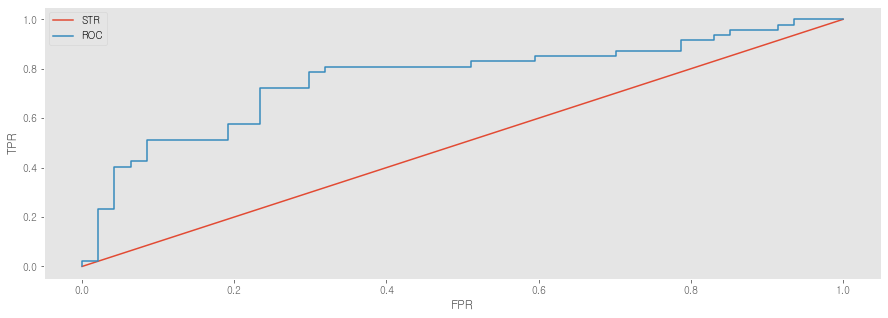

In [80]:
#svm - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=model_best_svm.predict_proba(x_test_rf_svm)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()

In [81]:
#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))


roc auc value 0.7596197374377547


In [82]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('svm_base')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


#### svm SHAP

In [83]:
features=x_train_rftree_svm.columns.tolist()

In [84]:
explainer = shap.KernelExplainer(model_best_svm.predict_proba,
                                 x_train_rftree_svm) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(x_train_rftree_svm,nsamples=100)

X does not have valid feature names, but SVC was fitted with feature names
Using 374 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/374 [00:00<?, ?it/s]

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardS

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardS

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardS

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardS

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardS

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:



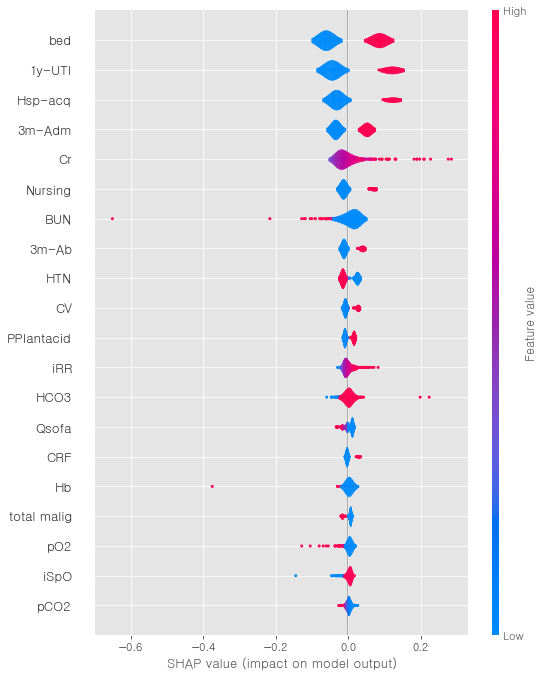

In [85]:
shap.summary_plot(shap_values[1],x_train_rftree_svm,feature_names=features,plot_type='violin')


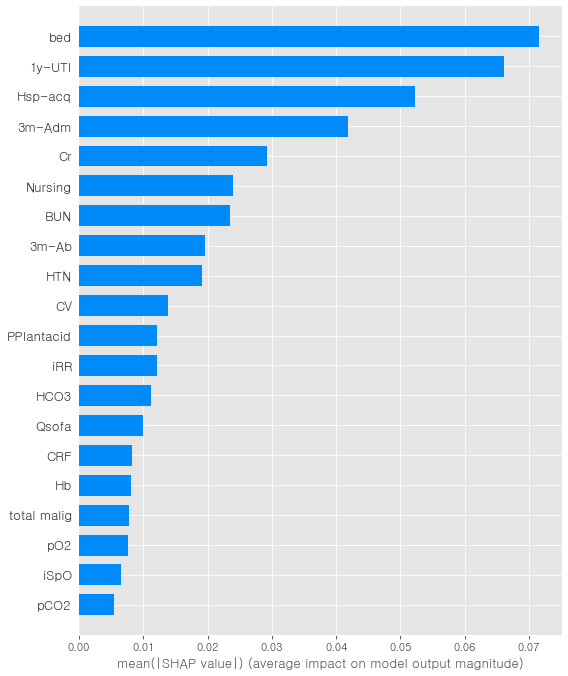

In [86]:
shap.summary_plot(shap_values[1], x_train_rftree_svm, plot_type='bar',max_display=20)

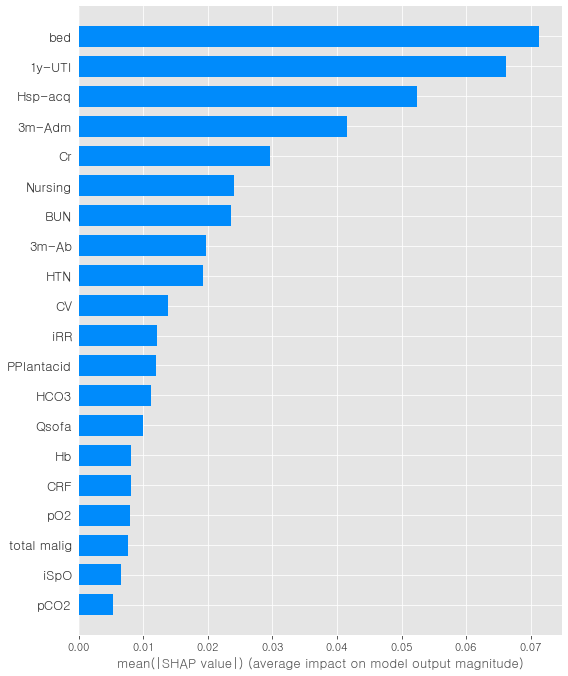

In [60]:
shap.summary_plot(shap_values[1], x_train_base_logistic, plot_type='bar',max_display=20,show=False)
plt.savefig('./FIGURES/svm_shap.png')

In [87]:
print("column별 mean shap value")
mean_shap_values = []

for i,col in enumerate(list(x_train.columns)): 
    mean_shap = np.mean(np.abs(shap_values[1][:,i]))
    mean_shap_values.append(mean_shap)
    print("{}, {:.8f}".format(col,mean_shap))


column별 mean shap value
sex, 0.00124170
Age, 0.00250456
mc, 0.00437337
iSBP, 0.00181269
iDBP, 0.00257396
iPR, 0.00468677
iRR, 0.01210881
iBT, 0.00239718
iSpO, 0.00654938
Qsofa, 0.00992701
bed, 0.07148968
Foley, 0.00477166
Hsp-acq, 0.05233889
Nursing, 0.02396748
3m-Ab, 0.01966830
3m-Adm, 0.04182864
1y-UTI, 0.06616577
PPIantacid, 0.01213401
DM, 0.00113703
HTN, 0.01912591
CV, 0.01391115
CRF, 0.00817576
total malig, 0.00772203
NR, 0.00359605
pH, 0.00084865
pCO2, 0.00550068
pO2, 0.00756934
HCO3, 0.01126046
SaO2, 0.00496015
lactic acid, 0.00364212
Leukopenia, 0.00116995
WBC, 0.00156233
Hb, 0.00813962
Plt, 0.00166002
CRP, 0.00293228
Glu, 0.00385110
BUN, 0.02348816
Cr, 0.02926386


In [88]:
origin_shap_df=pd.DataFrame({ "col":list(x_train.columns),"mean_shap_values":mean_shap_values})
origin_shap_df=origin_shap_df.sort_values("mean_shap_values",ascending=False)
origin_shap_df=origin_shap_df[:20]
origin_shap_df.to_excel("./values/svm_shap_val.xlsx",index=False)

### reduced (20개)

In [387]:
import sklearn.svm as svm
import sklearn.metrics as mt
from sklearn.model_selection import GridSearchCV
# 테스트하고자 하는 파라미터 값들을 사전타입으로 정의

svm_clf = svm.SVC(kernel = 'linear',random_state=1234)
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 25, 50, 100]}

grid_svm = GridSearchCV(svm_clf,
                      param_grid = parameters, cv = 5)

grid_svm.fit(x_train_rftree_svm20, y_train['CIP'])

result = pd.DataFrame(grid_svm.cv_results_['params'])
result['mean_test_score'] = grid_svm.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)


,C,mean_test_score
7,100.000,0.713658
2,0.100,0.713514
5,25.000,0.710991
6,50.000,0.710991
4,10.000,0.702991
3,1.000,0.702955
1,0.010,0.684324
0,0.001,0.502667


In [388]:

print('best params : ' ,grid_svm.best_params_)
model_best_svm = grid_svm.best_estimator_

best params :  {'C': 100}


In [389]:
from sklearn.metrics import accuracy_score

predicted = model_best_svm.predict(x_test_rftree_svm20)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, average=None)

print(f'accuracy score: {accuracy:.3}')
print(f'recall score: {recall[1]:.3}')

accuracy score: 0.713
recall score: 0.617


In [390]:
#probs로 변환
model_best_svm = svm.SVC(kernel = 'linear',random_state=1234,C=0.1,probability=True)
model_best_svm.fit(x_train_rftree_svm20, y_train['CIP'])



SVC(C=0.1, kernel='linear', probability=True, random_state=1234)

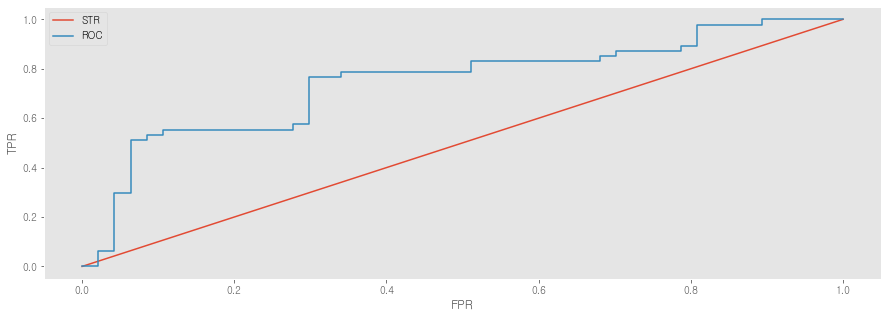

In [391]:
#svm - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=model_best_svm.predict_proba(x_test_rftree_svm20)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()

In [392]:
#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))


roc auc value 0.7451335445903123


In [393]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('svm_20')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 10

In [456]:
# 테스트하고자 하는 파라미터 값들을 사전타입으로 정의

svm_clf = svm.SVC(kernel = 'linear',random_state=1234)
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 25, 50, 100]}

grid_svm = GridSearchCV(svm_clf,
                      param_grid = parameters, cv = 5)

grid_svm.fit(x_train_rftree_svm10, y_train['CIP'])

result = pd.DataFrame(grid_svm.cv_results_['params'])
result['mean_test_score'] = grid_svm.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)


,C,mean_test_score
4,10.000,0.719027
6,50.000,0.719027
5,25.000,0.718991
3,1.000,0.716360
7,100.000,0.716324
2,0.100,0.716252
1,0.010,0.686955
0,0.001,0.502667


In [457]:

print('best params : ' ,grid_svm.best_params_)
model_best_svm = grid_svm.best_estimator_

best params :  {'C': 10}


In [458]:
from sklearn.metrics import accuracy_score

predicted = model_best_svm.predict(x_test_rftree_svm10)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, average=None)

print(f'accuracy score: {accuracy:.3}')
print(f'recall score: {recall[1]:.3}')

accuracy score: 0.745
recall score: 0.617


In [459]:
#probs로 변환
model_best_svm = svm.SVC(kernel = 'linear',random_state=1234,C=10,probability=True)
model_best_svm.fit(x_train_rftree_svm10, y_train['CIP'])



SVC(C=10, kernel='linear', probability=True, random_state=1234)

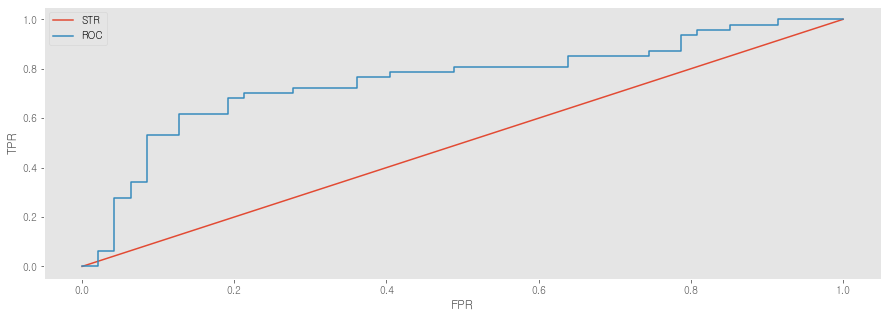

In [460]:
#svm - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=model_best_svm.predict_proba(x_test_rftree_svm10)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()

In [461]:
#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))


roc auc value 0.7532820280669986


In [462]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('svm_10')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


#### recall threshold change

In [22]:


#kfold 방법

from numpy import argmax
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection  import KFold

best_thresholds = []

kf = KFold(n_splits = 10, shuffle = True, random_state = 50)


valid_accs = []
valid_recalls=[]
valid_precisions=[]
valid_specificities=[]
valid_f1s=[]


# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
for train_index, test_index in kf.split(x_train_rftree_svm10):
    X_train_exp, X_test_exp = x_train_rftree_svm10.loc[train_index], x_train_rftree_svm10.loc[test_index]
    y_train_exp, y_test_exp = y_train.loc[train_index], y_train.loc[test_index]

    model_best_svm = svm.SVC(kernel = 'linear',random_state=1234,C=0.1,probability=True)
    model_best_svm.fit(X_train_exp, y_train_exp['CIP'])    
    
    # optimal threshold for precision-recall curve with logistic regression model
    # predict probabilities
    yhat = model_best_svm.predict_proba(X_test_exp)
    # keep probabilities for the positive outcome only
    yhat = yhat[:, 1]
    # calculate roc curves
    
    
    precision, recall, thresholds = precision_recall_curve(y_test_exp['CIP'], yhat)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.where(recall > 0.87)[0][-1]
    
    
    yhat[yhat>thresholds[ix]]=1
    yhat[yhat !=1] = 0
    vaild_acc = accuracy_score(y_true=y_test_exp,y_pred=yhat)
    valid_specificity = recall_score(y_true=y_test_exp, y_pred=yhat, pos_label=0)
    
    #print(ix)
    print('VALID: .Best Threshold=%f,acc=%f, recall=%f, precision=%f, spec=%f, F-Score=%.3f' % (vaild_acc,thresholds[ix],recall[ix],precision[ix],valid_specificity,fscore[ix]))
    
    valid_accs.append(vaild_acc)
    valid_recalls.append(recall[ix])
    valid_precisions.append(precision[ix])
    valid_specificities.append(valid_specificity)
    valid_f1s.append(fscore[ix])
    
    
    best_thresholds.append(thresholds[ix])
    # plot the roc curve for the model    
test_threshold=np.mean(best_thresholds)
print(test_threshold)
print("VALID: accs=%f recall=%f, precision=%f, specificity=%f, F-Score=%.3f" %(np.mean(valid_accs),np.mean(valid_recalls),np.mean(valid_precisions),np.mean(valid_specificities),np.mean(valid_f1s)) ) 

accs = []
recalls=[]
precisions=[]
specificities=[]
f1s=[]

# split 개수 스텝 만큼 test set에 대해 실험.
k_idx=0
for train_index, test_index in kf.split(x_train_rftree_svm10):
    X_train_exp, X_test_exp = x_train_rftree_svm10.loc[train_index], x_train_rftree_svm10.loc[test_index]
    y_train_exp, y_test_exp = y_train.loc[train_index], y_train.loc[test_index]

    model_best_svm = svm.SVC(kernel = 'linear',random_state=1234,C=0.1,probability=True)
    model_best_svm.fit(X_train_exp, y_train_exp['CIP'])
    test_threshold
    
    # optimal threshold for precision-recall curve with logistic regression model
    from numpy import argmax
    from sklearn.metrics import precision_recall_curve
    # predict probabilities
    yhat = model_best_svm.predict_proba(x_test_rftree_svm10)
    yhat = yhat[:, 1]
    # keep probabilities for the positive outcome only
    yhat[yhat>best_thresholds[k_idx]]=1
    yhat[yhat !=1] = 0    
    
    accuracy = [accuracy_score(y_true=y_test,y_pred=yhat),]
    recall = [recall_score(y_true=y_test, y_pred=yhat, pos_label=1),]
    precision = [precision_score(y_true=y_test, y_pred=yhat),]
    specificity = [recall_score(y_true=y_test, y_pred=yhat, pos_label=0),]
    f1 = [f1_score(y_true=y_test, y_pred=yhat),]
    
    accs.append(accuracy)
    recalls.append(recall)
    precisions.append(precision)
    specificities.append(specificity)
    f1s.append(f1)
    
    #print(pd.DataFrame([accuracy,recall,precision,specificity,f1]))
    k_idx+=1
print("TEST: accs=%f recall=%f, precision=%f, specificity=%f, F-Score=%.3f" %(np.mean(accs),np.mean(recalls),np.mean(precisions),np.mean(specificities),np.mean(f1s)) ) 
diffs=[np.mean(accs)-np.mean(valid_accs),
       np.mean(recalls)-np.mean(valid_recalls),
       np.mean(precisions)-np.mean(valid_precisions),
       np.mean(specificities)-np.mean(valid_specificities),
       np.mean(f1s)-np.mean(valid_f1s),
       ]
print("차이 : accs=%f recall=%f, precision=%f, specificity=%f, F-Score=%.3f"%(diffs[0],diffs[1],diffs[2],diffs[3],diffs[4]))


VALID: .Best Threshold=0.526316,acc=0.269520, recall=0.900000, precision=0.545455, spec=0.166667, F-Score=0.679
VALID: .Best Threshold=0.657895,acc=0.383090, recall=0.894737, precision=0.629630, spec=0.473684, F-Score=0.739
VALID: .Best Threshold=0.605263,acc=0.281997, recall=0.888889, precision=0.571429, spec=0.400000, F-Score=0.696
VALID: .Best Threshold=0.578947,acc=0.286576, recall=0.875000, precision=0.518519, spec=0.409091, F-Score=0.651
VALID: .Best Threshold=0.621622,acc=0.289079, recall=0.875000, precision=0.560000, spec=0.476190, F-Score=0.683
VALID: .Best Threshold=0.648649,acc=0.416699, recall=0.888889, precision=0.615385, spec=0.473684, F-Score=0.727
VALID: .Best Threshold=0.567568,acc=0.261369, recall=0.933333, precision=0.500000, spec=0.363636, F-Score=0.651
VALID: .Best Threshold=0.837838,acc=0.298670, recall=0.913043, precision=0.875000, spec=0.785714, F-Score=0.894
VALID: .Best Threshold=0.648649,acc=0.265875, recall=0.913043, precision=0.677419, spec=0.285714, F-Scor

### 변수 15

In [463]:
# 테스트하고자 하는 파라미터 값들을 사전타입으로 정의

svm_clf = svm.SVC(kernel = 'linear',random_state=1234)
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 25, 50, 100]}

grid_svm = GridSearchCV(svm_clf,
                      param_grid = parameters, cv = 5)

grid_svm.fit(x_train_rftree_svm15, y_train['CIP'])

result = pd.DataFrame(grid_svm.cv_results_['params'])
result['mean_test_score'] = grid_svm.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)


,C,mean_test_score
2,0.100,0.716252
5,25.000,0.713694
7,100.000,0.705658
4,10.000,0.705586
6,50.000,0.702919
3,1.000,0.697550
1,0.010,0.678955
0,0.001,0.502667


In [464]:

print('best params : ' ,grid_svm.best_params_)
model_best_svm = grid_svm.best_estimator_

best params :  {'C': 0.1}


In [465]:
from sklearn.metrics import accuracy_score

predicted = model_best_svm.predict(x_test_rftree_svm15)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, average=None)

print(f'accuracy score: {accuracy:.3}')
print(f'recall score: {recall[1]:.3}')

accuracy score: 0.713
recall score: 0.553


In [466]:
#probs로 변환
model_best_svm = svm.SVC(kernel = 'linear',random_state=1234,C=0.1,probability=True)
model_best_svm.fit(x_train_rftree_svm15, y_train['CIP'])



SVC(C=0.1, kernel='linear', probability=True, random_state=1234)

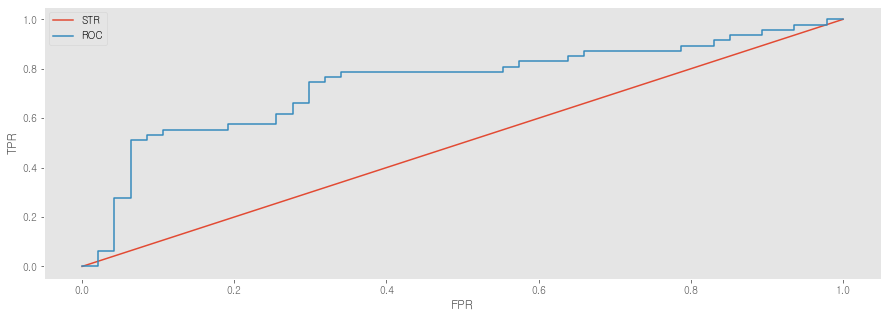

In [467]:
#svm - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=model_best_svm.predict_proba(x_test_rftree_svm15)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()

In [468]:
#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))


roc auc value 0.7406066093254866


In [469]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('svm_15')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 17

In [470]:
# 테스트하고자 하는 파라미터 값들을 사전타입으로 정의

svm_clf = svm.SVC(kernel = 'linear',random_state=1234)
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 25, 50, 100]}

grid_svm = GridSearchCV(svm_clf,
                      param_grid = parameters, cv = 5)

grid_svm.fit(x_train_rftree_svm17, y_train['CIP'])

result = pd.DataFrame(grid_svm.cv_results_['params'])
result['mean_test_score'] = grid_svm.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)


,C,mean_test_score
2,0.100,0.716252
7,100.000,0.713730
4,10.000,0.713694
5,25.000,0.713694
6,50.000,0.708324
3,1.000,0.702919
1,0.010,0.697694
0,0.001,0.502667


In [471]:

print('best params : ' ,grid_svm.best_params_)
model_best_svm = grid_svm.best_estimator_

best params :  {'C': 0.1}


In [472]:
from sklearn.metrics import accuracy_score

predicted = model_best_svm.predict(x_test_rftree_svm17)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, average=None)

print(f'accuracy score: {accuracy:.3}')
print(f'recall score: {recall[1]:.3}')

accuracy score: 0.713
recall score: 0.553


In [473]:
#probs로 변환
model_best_svm = svm.SVC(kernel = 'linear',random_state=1234,C=0.1,probability=True)
model_best_svm.fit(x_train_rftree_svm17, y_train['CIP'])



SVC(C=0.1, kernel='linear', probability=True, random_state=1234)

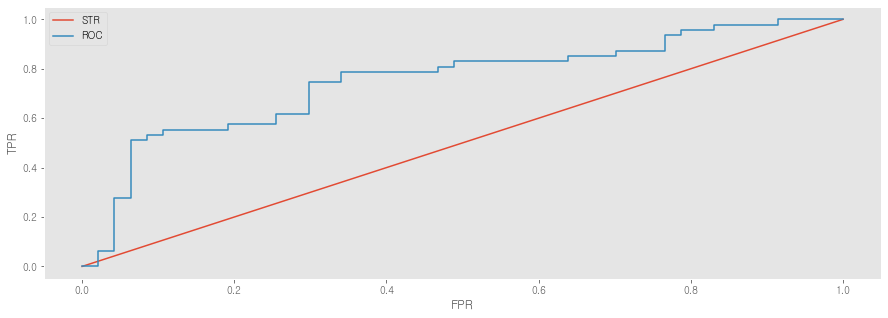

In [474]:
#svm - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=model_best_svm.predict_proba(x_test_rftree_svm17)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()

In [475]:
#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))


roc auc value 0.7514712539610683


In [476]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('svm_17')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 25

In [477]:
# 테스트하고자 하는 파라미터 값들을 사전타입으로 정의

svm_clf = svm.SVC(kernel = 'linear',random_state=1234)
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 25, 50, 100]}

grid_svm = GridSearchCV(svm_clf,
                      param_grid = parameters, cv = 5)

grid_svm.fit(x_train_rftree_svm25, y_train['CIP'])

result = pd.DataFrame(grid_svm.cv_results_['params'])
result['mean_test_score'] = grid_svm.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)


,C,mean_test_score
2,0.100,0.697514
4,10.000,0.694919
3,1.000,0.689622
1,0.010,0.684324
7,100.000,0.684252
5,25.000,0.681586
6,50.000,0.681586
0,0.001,0.502667


In [478]:

print('best params : ' ,grid_svm.best_params_)
model_best_svm = grid_svm.best_estimator_

best params :  {'C': 0.1}


In [479]:
from sklearn.metrics import accuracy_score

predicted = model_best_svm.predict(x_test_rftree_svm25)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, average=None)

print(f'accuracy score: {accuracy:.3}')
print(f'recall score: {recall[1]:.3}')

accuracy score: 0.723
recall score: 0.553


In [480]:
#probs로 변환
model_best_svm = svm.SVC(kernel = 'linear',random_state=1234,C=0.1,probability=True)
model_best_svm.fit(x_train_rftree_svm25, y_train['CIP'])



SVC(C=0.1, kernel='linear', probability=True, random_state=1234)

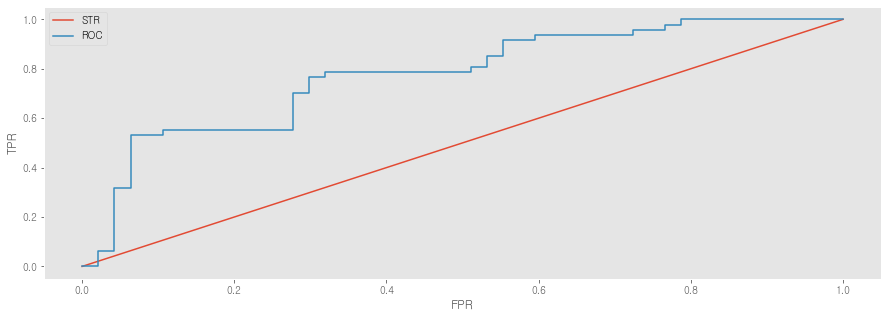

In [481]:
#svm - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=model_best_svm.predict_proba(x_test_rftree_svm25)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()

In [482]:
#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))


roc auc value 0.7750113173381621


In [483]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('svm_25')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


#### recall threshold change

In [30]:
# train valid 분리
# train,valid 나누기|
# exp : 학습 중이란 뜻
x_train_25_svm_exp, x_val_25_svm_exp,\
y_train_25_svm_exp, y_val_25_svm_exp = train_test_split(x_train_rftree_svm25,y_train,stratify=y_train,\
                                                  test_size=0.2,random_state=42)  # 훈련 데이터와 검증 데이터 분류



In [44]:


#kfold 방법

from numpy import argmax
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection  import KFold

best_thresholds = []

kf = KFold(n_splits = 10, shuffle = True, random_state = 50)

valid_accs = []
valid_recalls=[]
valid_precisions=[]
valid_specificities=[]
valid_f1s=[]


# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
for train_index, test_index in kf.split(x_train_rftree_svm25):
    X_train_exp, X_test_exp = x_train_rftree_svm25.loc[train_index], x_train_rftree_svm25.loc[test_index]
    y_train_exp, y_test_exp = y_train.loc[train_index], y_train.loc[test_index]

    model_best_svm = svm.SVC(kernel = 'linear',random_state=1234,C=0.1,probability=True)
    model_best_svm.fit(X_train_exp, y_train_exp['CIP'])    
    
    # optimal threshold for precision-recall curve with logistic regression model
    # predict probabilities
    yhat = model_best_svm.predict_proba(X_test_exp)
    # keep probabilities for the positive outcome only
    yhat = yhat[:, 1]
    # calculate roc curves
    precision, recall, thresholds = precision_recall_curve(y_test_exp['CIP'], yhat)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.where(recall > 0.87)[0][-1]
    
    yhat[yhat>thresholds[ix]]=1
    yhat[yhat !=1] = 0
    vaild_acc = accuracy_score(y_true=y_test_exp,y_pred=yhat)
    valid_specificity = recall_score(y_true=y_test_exp, y_pred=yhat, pos_label=0)
    
    #print(ix)
    print('VALID: .Best Threshold=%f,acc=%f, recall=%f, precision=%f, spec=%f, F-Score=%.3f' % (thresholds[ix],vaild_acc,recall[ix],precision[ix],valid_specificity,fscore[ix]))
    
    valid_accs.append(vaild_acc)
    valid_recalls.append(recall[ix])
    valid_precisions.append(precision[ix])
    valid_specificities.append(valid_specificity)
    valid_f1s.append(fscore[ix])
    
    
    best_thresholds.append(thresholds[ix])
    # plot the roc curve for the model    
test_threshold=np.mean(best_thresholds)
print("threshold mean : ",test_threshold)
print("VALID: accs=%f recall=%f, precision=%f, specificity=%f, F-Score=%.3f" %(np.mean(valid_accs),np.mean(valid_recalls),np.mean(valid_precisions),np.mean(valid_specificities),np.mean(valid_f1s)) ) 





accs = []
recalls=[]
precisions=[]
specificities=[]
f1s=[]

# split 개수 스텝 만큼 test set에 대해 실험.
k_idx=0
for train_index, test_index in kf.split(x_train_rftree_svm25):
    X_train_exp, X_test_exp = x_train_rftree_svm25.loc[train_index], x_train_rftree_svm25.loc[test_index]
    y_train_exp, y_test_exp = y_train.loc[train_index], y_train.loc[test_index]

    model_best_svm = svm.SVC(kernel = 'linear',random_state=1234,C=0.1,probability=True)
    model_best_svm.fit(X_train_exp, y_train_exp['CIP'])
    test_threshold
    
    # optimal threshold for precision-recall curve with logistic regression model
    from numpy import argmax
    from sklearn.metrics import precision_recall_curve
    # predict probabilities
    yhat = model_best_svm.predict_proba(x_test_rftree_svm25)
    yhat = yhat[:, 1]
    # keep probabilities for the positive outcome only
    yhat[yhat>best_thresholds[k_idx]]=1
    yhat[yhat !=1] = 0    
    
    accuracy = [accuracy_score(y_true=y_test,y_pred=yhat),]
    recall = [recall_score(y_true=y_test, y_pred=yhat, pos_label=1),]
    precision = [precision_score(y_true=y_test, y_pred=yhat),]
    specificity = [recall_score(y_true=y_test, y_pred=yhat, pos_label=0),]
    f1 = [f1_score(y_true=y_test, y_pred=yhat),]
    
    accs.append(accuracy)
    recalls.append(recall)
    precisions.append(precision)
    specificities.append(specificity)
    f1s.append(f1)
    
    #print(pd.DataFrame([accuracy,recall,precision,specificity,f1]))
    k_idx+=1
print("TEST: accs=%f recall=%f, precision=%f, specificity=%f, F-Score=%.3f" %(np.mean(accs),np.mean(recalls),np.mean(precisions),np.mean(specificities),np.mean(f1s)) ) 
diffs=[np.mean(accs)-np.mean(valid_accs),
       np.mean(recalls)-np.mean(valid_recalls),
       np.mean(precisions)-np.mean(valid_precisions),
       np.mean(specificities)-np.mean(valid_specificities),
       np.mean(f1s)-np.mean(valid_f1s),
       ]
print("차이 : accs=%f recall=%f, precision=%f, specificity=%f, F-Score=%.3f"%(diffs[0],diffs[1],diffs[2],diffs[3],diffs[4]))



VALID: .Best Threshold=0.305546,acc=0.552632, recall=0.900000, precision=0.562500, spec=0.222222, F-Score=0.692
VALID: .Best Threshold=0.390891,acc=0.657895, recall=0.894737, precision=0.629630, spec=0.473684, F-Score=0.739
VALID: .Best Threshold=0.316292,acc=0.500000, recall=0.888889, precision=0.500000, spec=0.200000, F-Score=0.640
VALID: .Best Threshold=0.310147,acc=0.552632, recall=0.875000, precision=0.500000, spec=0.363636, F-Score=0.636
VALID: .Best Threshold=0.299194,acc=0.540541, recall=0.875000, precision=0.500000, spec=0.333333, F-Score=0.636
VALID: .Best Threshold=0.423527,acc=0.621622, recall=0.888889, precision=0.592593, spec=0.421053, F-Score=0.711
VALID: .Best Threshold=0.273090,acc=0.459459, recall=0.933333, precision=0.437500, spec=0.181818, F-Score=0.596
VALID: .Best Threshold=0.349843,acc=0.837838, recall=0.913043, precision=0.875000, spec=0.785714, F-Score=0.894
VALID: .Best Threshold=0.340276,acc=0.648649, recall=0.913043, precision=0.677419, spec=0.285714, F-Scor

invalid value encountered in true_divide


TEST: accs=0.641489 recall=0.861702, precision=0.606206, specificity=0.421277, F-Score=0.707
차이 : accs=0.034092 recall=-0.036491, precision=0.009511, specificity=0.041618, F-Score=-0.003


In [42]:


#kfold 방법

from numpy import argmax
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection  import KFold

best_thresholds = []

kf = KFold(n_splits = 10, shuffle = True, random_state = 50)

# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
for train_index, test_index in kf.split(x_train_rftree_svm25):
    X_train_exp, X_test_exp = x_train_rftree_svm25.loc[train_index], x_train_rftree_svm25.loc[test_index]
    y_train_exp, y_test_exp = y_train.loc[train_index], y_train.loc[test_index]

    model_best_svm = svm.SVC(kernel = 'linear',random_state=1234,C=0.1,probability=True)
    model_best_svm.fit(X_train_exp, y_train_exp['CIP'])    
    
    # optimal threshold for precision-recall curve with logistic regression model
    # predict probabilities
    yhat = model_best_svm.predict_proba(X_test_exp)
    # keep probabilities for the positive outcome only
    yhat = yhat[:, 1]
    # calculate roc curves
    precision, recall, thresholds = precision_recall_curve(y_test_exp['CIP'], yhat)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    yhat[yhat>thresholds[ix]]=1
    yhat[yhat !=1] = 0
    vaild_acc = accuracy_score(y_true=y_test_exp,y_pred=yhat)
    valid_specificity = recall_score(y_true=y_test_exp, y_pred=yhat, pos_label=0)
    
    #print(ix)
    print('VALID: .Best Threshold=%f,acc=%f, recall=%f, precision=%f, spec=%f, F-Score=%.3f' % (thresholds[ix],vaild_acc,recall[ix],precision[ix],valid_specificity,fscore[ix]))
    
    valid_accs.append(vaild_acc)
    valid_recalls.append(recall[ix])
    valid_precisions.append(precision[ix])
    valid_specificities.append(valid_specificity)
    valid_f1s.append(fscore[ix])
    
    
    best_thresholds.append(thresholds[ix])
    # plot the roc curve for the model    
test_threshold=np.mean(best_thresholds)
print("threshold mean : ",test_threshold)
print("VALID: accs=%f recall=%f, precision=%f, specificity=%f, F-Score=%.3f" %(np.mean(valid_accs),np.mean(valid_recalls),np.mean(valid_precisions),np.mean(valid_specificities),np.mean(valid_f1s)) ) 





accs = []
recalls=[]
precisions=[]
specificities=[]
f1s=[]

# split 개수 스텝 만큼 test set에 대해 실험.
k_idx=0
for train_index, test_index in kf.split(x_train_rftree_svm25):
    #X_train_exp, X_test_exp = x_train_rftree_svm25.loc[train_index], x_train_rftree_svm25.loc[test_index]
    #y_train_exp, y_test_exp = y_train.loc[train_index], y_train.loc[test_index]

    model_best_svm = svm.SVC(kernel = 'linear',random_state=1234,C=0.1,probability=True)
    model_best_svm.fit(x_train_rftree_svm25, y_train['CIP'])
    test_threshold
    
    # optimal threshold for precision-recall curve with logistic regression model
    from numpy import argmax
    from sklearn.metrics import precision_recall_curve
    # predict probabilities
    yhat = model_best_svm.predict_proba(x_test_rftree_svm25)
    yhat = yhat[:, 1]
    # keep probabilities for the positive outcome only
    yhat[yhat>best_thresholds[k_idx]]=1
    yhat[yhat !=1] = 0    
    
    accuracy = [accuracy_score(y_true=y_test,y_pred=yhat),]
    recall = [recall_score(y_true=y_test, y_pred=yhat, pos_label=1),]
    precision = [precision_score(y_true=y_test, y_pred=yhat),]
    specificity = [recall_score(y_true=y_test, y_pred=yhat, pos_label=0),]
    f1 = [f1_score(y_true=y_test, y_pred=yhat),]
    
    accs.append(accuracy)
    recalls.append(recall)
    precisions.append(precision)
    specificities.append(specificity)
    f1s.append(f1)
    
    #print(pd.DataFrame([accuracy,recall,precision,specificity,f1]))
    k_idx+=1
print("TEST: accs=%f recall=%f, precision=%f, specificity=%f, F-Score=%.3f" %(np.mean(accs),np.mean(recalls),np.mean(precisions),np.mean(specificities),np.mean(f1s)) ) 
diffs=[np.mean(accs)-np.mean(valid_accs),
       np.mean(recalls)-np.mean(valid_recalls),
       np.mean(precisions)-np.mean(valid_precisions),
       np.mean(specificities)-np.mean(valid_specificities),
       np.mean(f1s)-np.mean(valid_f1s),
       ]
print("차이 : accs=%f recall=%f, precision=%f, specificity=%f, F-Score=%.3f"%(diffs[0],diffs[1],diffs[2],diffs[3],diffs[4]))



VALID: .Best Threshold=0.317290,acc=0.578947, recall=0.850000, precision=0.586207, spec=0.333333, F-Score=0.694
VALID: .Best Threshold=0.323146,acc=0.657895, recall=0.894737, precision=0.586207, spec=0.421053, F-Score=0.708
VALID: .Best Threshold=0.322134,acc=0.578947, recall=0.833333, precision=0.517241, spec=0.350000, F-Score=0.638
VALID: .Best Threshold=0.310147,acc=0.552632, recall=0.875000, precision=0.500000, spec=0.363636, F-Score=0.636
VALID: .Best Threshold=0.299194,acc=0.540541, recall=0.875000, precision=0.500000, spec=0.333333, F-Score=0.636
VALID: .Best Threshold=0.435798,acc=0.594595, recall=0.777778, precision=0.583333, spec=0.473684, F-Score=0.667
VALID: .Best Threshold=0.279318,acc=0.594595, recall=0.800000, precision=0.480000, spec=0.454545, F-Score=0.600
VALID: .Best Threshold=0.340024,acc=0.810811, recall=0.913043, precision=0.777778, spec=0.642857, F-Score=0.840
VALID: .Best Threshold=0.378987,acc=0.729730, recall=0.869565, precision=0.714286, spec=0.500000, F-Scor

invalid value encountered in true_divide


TEST: accs=0.685106 recall=0.802128, precision=0.652757, specificity=0.568085, F-Score=0.718
차이 : accs=0.050366 recall=-0.061090, precision=0.056268, specificity=0.128323, F-Score=0.016


In [37]:
best_thresholds

[0.3172896638480229,
 0.3231462116792631,
 0.32213352746117013,
 0.3101467143565338,
 0.299193592297954,
 0.43579752535328165,
 0.2793175082504779,
 0.34002378683262047,
 0.37898695321656306,
 0.39739908954754555]

In [38]:
recalls,precisions,specificities,f1s

([[0.8297872340425532],
  [0.8085106382978723],
  [0.9574468085106383],
  [0.9148936170212766],
  [0.9148936170212766],
  [0.7021276595744681],
  [0.8085106382978723],
  [0.8723404255319149],
  [0.7872340425531915],
  [0.7872340425531915]],
 [[0.6190476190476191],
  [0.6333333333333333],
  [0.5769230769230769],
  [0.5733333333333334],
  [0.581081081081081],
  [0.7333333333333333],
  [0.5846153846153846],
  [0.6212121212121212],
  [0.6491228070175439],
  [0.6851851851851852]],
 [[0.48936170212765956],
  [0.5319148936170213],
  [0.2978723404255319],
  [0.3191489361702128],
  [0.3404255319148936],
  [0.7446808510638298],
  [0.425531914893617],
  [0.46808510638297873],
  [0.574468085106383],
  [0.6382978723404256]],
 [[0.7090909090909091],
  [0.7102803738317757],
  [0.7200000000000001],
  [0.7049180327868853],
  [0.7107438016528925],
  [0.7173913043478262],
  [0.6785714285714286],
  [0.7256637168141593],
  [0.7115384615384615],
  [0.7326732673267328]])

In [24]:
np.mean(accs),np.mean(recalls),np.mean(precisions),np.mean(specificities),np.mean(f1s)

(0.6606382978723404,
 0.8382978723404255,
 0.6257187275082011,
 0.4829787234042553,
 0.7120871295961071)

### 변수 30

In [484]:
# 테스트하고자 하는 파라미터 값들을 사전타입으로 정의

svm_clf = svm.SVC(kernel = 'linear',random_state=1234)
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 25, 50, 100]}

grid_svm = GridSearchCV(svm_clf,
                      param_grid = parameters, cv = 5)

grid_svm.fit(x_train_rftree_svm30, y_train['CIP'])

result = pd.DataFrame(grid_svm.cv_results_['params'])
result['mean_test_score'] = grid_svm.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)


,C,mean_test_score
3,1.000,0.694883
2,0.100,0.692144
4,10.000,0.678847
1,0.010,0.671027
6,50.000,0.670847
7,100.000,0.668180
5,25.000,0.668144
0,0.001,0.502667


In [485]:

print('best params : ' ,grid_svm.best_params_)
model_best_svm = grid_svm.best_estimator_

best params :  {'C': 1}


In [486]:
from sklearn.metrics import accuracy_score

predicted = model_best_svm.predict(x_test_rftree_svm30)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, average=None)

print(f'accuracy score: {accuracy:.3}')
print(f'recall score: {recall[1]:.3}')

accuracy score: 0.713
recall score: 0.617


In [487]:
#probs로 변환
model_best_svm = svm.SVC(kernel = 'linear',random_state=1234,C=0.1,probability=True)
model_best_svm.fit(x_train_rftree_svm30, y_train['CIP'])



SVC(C=0.1, kernel='linear', probability=True, random_state=1234)

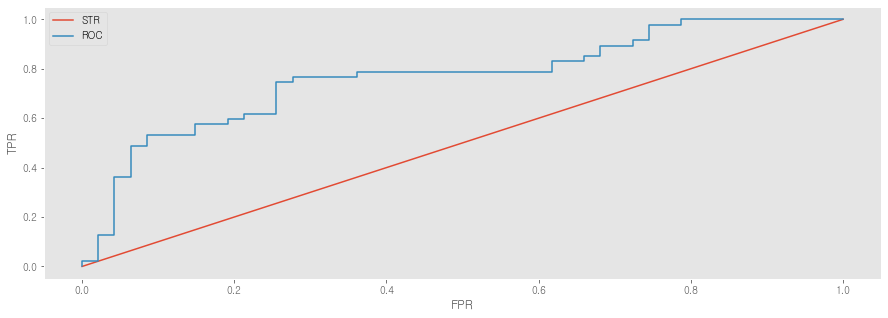

In [488]:
#svm - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=model_best_svm.predict_proba(x_test_rftree_svm30)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()

In [489]:
#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))


roc auc value 0.7659574468085106


In [490]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('svm_30')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


In [491]:
aucs

[0.7596197374377547,
 0.7532820280669986,
 0.7406066093254866,
 0.7514712539610683,
 0.7750113173381621,
 0.7659574468085106]

In [492]:
test_svm= pd.concat([pd.DataFrame(names),
                     pd.DataFrame(aucs),
                     pd.DataFrame(accs),
                     pd.DataFrame(recalls_list),
                     pd.DataFrame(specificitys),
                     pd.DataFrame(f1s)
                    ],axis=1)
test_svm.columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1']

In [493]:
test_svm.sort_values('name')

,name,AUC,ACC,RECALL,SPECIFICITY,F1
1,svm_10,0.753282,0.744681,0.617021,0.872340,0.707317
2,svm_15,0.740607,0.712766,0.553191,0.872340,0.658228
3,svm_17,0.751471,0.712766,0.553191,0.872340,0.658228
4,svm_25,0.775011,0.723404,0.553191,0.893617,0.666667
5,svm_30,0.765957,0.712766,0.617021,0.808511,0.682353
0,svm_base,0.759620,0.691489,0.574468,0.808511,0.650602


## random forest

In [46]:
test_rf = pd.DataFrame(columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1'])
test_rf

,name,AUC,ACC,RECALL,SPECIFICITY,F1


In [47]:
names=[]
aucs=[]
accs=[]
recalls_list=[]
specificitys=[]
f1s=[]

In [48]:
#변수들 선언

x_train_rftree_rf = x_train.copy() # 38개 변수
x_test_rftree_rf = x_test.copy()

x_train_rftree_rf20=x_train_rftree_rf[col_all[:20]] #norm 변환 완료된 20개 변수
x_test_rftree_rf20=x_test_rftree_rf[col_all[:20]]

x_train_rftree_rf10=x_train_rftree_rf[col_all[:10]]
x_test_rftree_rf10=x_test_rftree_rf[col_all[:10]]

x_train_rftree_rf15=x_train_rftree_rf[col_all[:15]]
x_test_rftree_rf15=x_test_rftree_rf[col_all[:15]]

x_train_rftree_rf17=x_train_rftree_rf[col_all[:17]]
x_test_rftree_rf17=x_test_rftree_rf[col_all[:17]]


x_train_rftree_rf25=x_train_rftree_rf[col_all[:25]]
x_test_rftree_rf25=x_test_rftree_rf[col_all[:25]]

x_train_rftree_rf30=x_train_rftree_rf[col_all[:30]]
x_test_rftree_rf30=x_test_rftree_rf[col_all[:30]]

### reduced (20개)

In [497]:

param_list = {"n_estimators": list(range(10, 500, 10)),
              "max_depth": [1,2,3,4,5],}

rf2 = RandomForestClassifier(random_state=1234)

rf2_random_search = RandomizedSearchCV(
        estimator=rf2,
        param_distributions = param_list,
        n_iter = 50,
        cv = 5,
        scoring = 'accuracy')

rf2_random_search.fit(x_train_rftree_rf20, y_train['CIP'])


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
                   n_iter=50,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         120, 130, 140, 150,
                                                         160, 170, 180, 190,
                                                         200, 210, 220, 230,
                                                         240, 250, 260, 270,
                                                         280, 290, 300, ...]},
                   scoring='accuracy')

In [498]:
print('best params : ' ,rf2_random_search.best_params_)
model_best2=rf2_random_search.best_estimator_

best params :  {'n_estimators': 130, 'max_depth': 2}


In [499]:
from sklearn.metrics import accuracy_score

predicted = model_best2.predict(x_test_rftree_rf20)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, average=None)

print(f'accuracy score: {accuracy:.3}')
print(f'recall score: {recall[1]:.3}')

accuracy score: 0.67
recall score: 0.596


<AxesSubplot:>

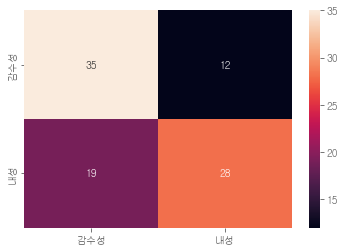

In [500]:
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=predicted), columns=['감수성','내성'], index=['감수성','내성'])
sns.heatmap(cm, annot=True)

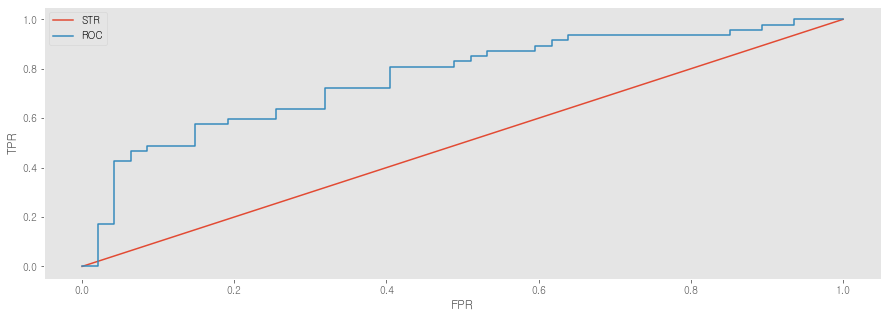

In [501]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label = model_best2.predict_proba(x_test_rftree_rf20)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [502]:
#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test, pred_positive_label) ))



roc auc value 0.7627885921231328


In [503]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('rf_20')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


변수를 축약하여, 오히려 accuracy, recall이 조금 상승했다.

### 변수 10

In [504]:

param_list = {"n_estimators": list(range(10, 500, 10)),
              "max_depth": [1,2,3,4,5],}

rf2 = RandomForestClassifier(random_state=1234)

rf2_random_search = RandomizedSearchCV(
        estimator=rf2,
        param_distributions = param_list,
        n_iter = 50,
        cv = 5,
        scoring = 'accuracy')

rf2_random_search.fit(x_train_rftree_rf10, y_train['CIP'])


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
                   n_iter=50,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         120, 130, 140, 150,
                                                         160, 170, 180, 190,
                                                         200, 210, 220, 230,
                                                         240, 250, 260, 270,
                                                         280, 290, 300, ...]},
                   scoring='accuracy')

In [505]:
print('best params : ' ,rf2_random_search.best_params_)
model_best2=rf2_random_search.best_estimator_

best params :  {'n_estimators': 90, 'max_depth': 1}


In [506]:
model_best2= RandomForestClassifier(n_estimators=390,max_depth=1,random_state=1234)
model_best2.fit(x_train_rftree_rf10, y_train['CIP'])

RandomForestClassifier(max_depth=1, n_estimators=390, random_state=1234)

In [507]:
from sklearn.metrics import accuracy_score

predicted = model_best2.predict(x_test_rftree_rf10)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, average=None)

print(f'accuracy score: {accuracy:.3}')
print(f'recall score: {recall[1]:.3}')

accuracy score: 0.702
recall score: 0.553


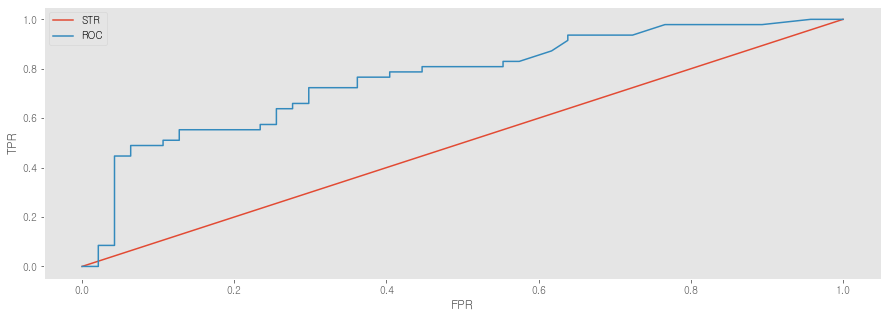

In [508]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=model_best2.predict_proba(x_test_rftree_rf10)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [509]:

#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))



roc auc value 0.7639203259393391


In [510]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('rf_10')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


#### recall threshold change

In [70]:
def plot_pr_curve(test_y, model_probs,clf_name):
    # calculate the no skill line as the proportion of the positive class
    no_skill = len(test_y[test_y==1]) / len(test_y)
    # plot the no skill precision-recall curve
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # plot model precision-recall curve
    precision, recall, _ = precision_recall_curve(test_y, model_probs)
    plt.plot(recall, precision, marker='.', label=clf_name)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

38
Best Threshold=0.403480, F-Score=0.720


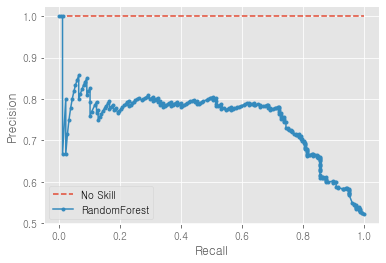

In [72]:

# optimal threshold for precision-recall curve with logistic regression model
from numpy import argmax
from sklearn.metrics import precision_recall_curve
# predict probabilities
yhat = model_best2.predict_proba(x_train_rftree_rf10)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(y_train['CIP'], yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
print(np.where(recall > 0.90)[0][-1])
ix = np.where(recall > 0.90)[0][-1]
#ix = argmax(np.nan_to_num(recall))
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
plot_pr_curve(y_train, yhat,'RandomForest')


In [73]:

# optimal threshold for precision-recall curve with logistic regression model
from numpy import argmax
from sklearn.metrics import precision_recall_curve
# predict probabilities
yhat = model_best2.predict_proba(x_test_rftree_rf10)
yhat = yhat[:, 1]
# keep probabilities for the positive outcome only
yhat[yhat>0.403480]=1
yhat[yhat !=1] = 0


In [74]:

accuracy = [accuracy_score(y_true=y_test,y_pred=yhat),]
recall = [recall_score(y_true=y_test, y_pred=yhat, pos_label=1),]
precision = [precision_score(y_true=y_test, y_pred=yhat),]
specificity = [recall_score(y_true=y_test, y_pred=yhat, pos_label=0),]
f1 = [f1_score(y_true=y_test, y_pred=yhat),]
pd.DataFrame([accuracy,recall,precision,specificity,f1])
#print(accuracy, recall,precision,specificity, f1 )

,0
0,0.617021
1,0.893617
2,0.575342
3,0.340426
4,0.700000


In [50]:
yhat

array([0.39892248, 0.43152031, 0.51926728, 0.43047137, 0.45537666,
       0.6480085 , 0.54966922, 0.54726769, 0.5142527 , 0.46451935,
       0.39774395, 0.53991745, 0.42205046, 0.35842026, 0.49659797,
       0.39669501, 0.39516585, 0.64240204, 0.50180478, 0.42671474,
       0.35854984, 0.53467048, 0.39787353, 0.3941169 , 0.6455717 ,
       0.42205046, 0.71738526, 0.65023597, 0.52403172, 0.51093546,
       0.39141293, 0.54924495, 0.39774395, 0.52970297, 0.39774395,
       0.36230371, 0.52605226, 0.46558973])

In [52]:


#kfold 방법

from numpy import argmax
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection  import KFold

best_thresholds = []

kf = KFold(n_splits = 10, shuffle = True, random_state = 50)

valid_accs = []
valid_recalls=[]
valid_precisions=[]
valid_specificities=[]
valid_f1s=[]

# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
for train_index, test_index in kf.split(x_train_rftree_rf10):
    X_train_exp, X_test_exp = x_train_rftree_rf10.loc[train_index], x_train_rftree_rf10.loc[test_index]
    y_train_exp, y_test_exp = y_train.loc[train_index], y_train.loc[test_index]

    model_best = RandomForestClassifier(n_estimators=230, max_depth= 1,oob_score=True, random_state=1234)
    model_best.fit(X_train_exp, y_train_exp['CIP'])
    
    # optimal threshold for precision-recall curve with logistic regression model
    # predict probabilities
    yhat = model_best.predict_proba(X_test_exp)
    # keep probabilities for the positive outcome only
    yhat = yhat[:, 1]
    # calculate roc curves
    precision, recall, thresholds = precision_recall_curve(y_test_exp['CIP'], yhat)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    
    ix = np.where(recall > 0.87)[0][-1]
    print(ix)    
    yhat[yhat>thresholds[ix]]=1
    yhat[yhat !=1] = 0
    vaild_acc = accuracy_score(y_true=y_test_exp,y_pred=yhat)
    valid_specificity = recall_score(y_true=y_test_exp, y_pred=yhat, pos_label=0)
    


    print('Best Threshold=%f, recall=%f, precision=%f, F-Score=%.3f' % (thresholds[ix],recall[ix],precision[ix] ,fscore[ix]))
    valid_accs.append(vaild_acc)
    valid_recalls.append(recall[ix])
    valid_precisions.append(precision[ix])
    valid_specificities.append(valid_specificity)
    valid_f1s.append(fscore[ix])    
    
    best_thresholds.append(thresholds[ix])
    # plot the roc curve for the model    
test_threshold=np.mean(best_thresholds)
print(test_threshold)


accs = []
recalls=[]
precisions=[]
specificities=[]
f1s=[]

# split 개수 스텝 만큼 test set에 대해 실험.
k_idx=0
for train_index, test_index in kf.split(x_train_rftree_rf10):
    X_train_exp, X_test_exp = x_train_rftree_rf10.loc[train_index], x_train_rftree_rf10.loc[test_index]
    y_train_exp, y_test_exp = y_train.loc[train_index], y_train.loc[test_index]

    model_best = RandomForestClassifier(n_estimators=230, max_depth= 1,oob_score=True, random_state=1234)
    model_best.fit(X_train_exp, y_train_exp['CIP'])    
    
    test_threshold
    
    # optimal threshold for precision-recall curve with logistic regression model
    from numpy import argmax
    from sklearn.metrics import precision_recall_curve
    # predict probabilities
    yhat = model_best.predict_proba(x_test_rftree_rf10)
    yhat = yhat[:, 1]
    # keep probabilities for the positive outcome only
    yhat[yhat>best_thresholds[k_idx]]=1
    yhat[yhat !=1] = 0    
    
    accuracy = [accuracy_score(y_true=y_test,y_pred=yhat),]
    recall = [recall_score(y_true=y_test, y_pred=yhat, pos_label=1),]
    precision = [precision_score(y_true=y_test, y_pred=yhat),]
    specificity = [recall_score(y_true=y_test, y_pred=yhat, pos_label=0),]
    f1 = [f1_score(y_true=y_test, y_pred=yhat),]
    
    accs.append(accuracy)
    recalls.append(recall)
    precisions.append(precision)
    specificities.append(specificity)
    f1s.append(f1)
    
    #print(pd.DataFrame([accuracy,recall,precision,specificity,f1]))
    k_idx+=1
print("TEST: accs=%f recall=%f, precision=%f, specificity=%f, F-Score=%.3f" %(np.mean(accs),np.mean(recalls),np.mean(precisions),np.mean(specificities),np.mean(f1s)) ) 
diffs=[np.mean(accs)-np.mean(valid_accs),
       np.mean(recalls)-np.mean(valid_recalls),
       np.mean(precisions)-np.mean(valid_precisions),
       np.mean(specificities)-np.mean(valid_specificities),
       np.mean(f1s)-np.mean(valid_f1s),
       ]
print("차이 : accs=%f recall=%f, precision=%f, specificity=%f, F-Score=%.3f"%(diffs[0],diffs[1],diffs[2],diffs[3],diffs[4]))


2
Best Threshold=0.397744, recall=0.950000, precision=0.612903, F-Score=0.745
7
Best Threshold=0.463594, recall=0.894737, precision=0.629630, F-Score=0.739
5
Best Threshold=0.410273, recall=0.888889, precision=0.533333, F-Score=0.667
2
Best Threshold=0.423169, recall=0.875000, precision=0.518519, F-Score=0.651
4
Best Threshold=0.419680, recall=0.875000, precision=0.636364, F-Score=0.737
10
Best Threshold=0.475515, recall=0.888889, precision=0.666667, F-Score=0.762
2
Best Threshold=0.411881, recall=0.933333, precision=0.424242, F-Score=0.583
7
Best Threshold=0.416250, recall=0.913043, precision=0.913043, F-Score=0.913
4
Best Threshold=0.380238, recall=0.913043, precision=0.656250, F-Score=0.764
5
Best Threshold=0.424722, recall=0.900000, precision=0.692308, F-Score=0.783
0.42230665693129205
TEST: accs=0.643617 recall=0.814894, precision=0.614450, specificity=0.472340, F-Score=0.695
차이 : accs=-0.014704 recall=-0.088300, precision=-0.013876, specificity=-0.001290, F-Score=-0.039


### 변수 15

In [511]:

param_list = {"n_estimators": list(range(10, 500, 10)),
              "max_depth": [1,2,3,4,5],}

rf2 = RandomForestClassifier(random_state=1234)

rf2_random_search = RandomizedSearchCV(
        estimator=rf2,
        param_distributions = param_list,
        n_iter = 50,
        cv = 5,
        scoring = 'accuracy')

rf2_random_search.fit(x_train_rftree_rf15, y_train['CIP'])


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
                   n_iter=50,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         120, 130, 140, 150,
                                                         160, 170, 180, 190,
                                                         200, 210, 220, 230,
                                                         240, 250, 260, 270,
                                                         280, 290, 300, ...]},
                   scoring='accuracy')

In [512]:
print('best params : ' ,rf2_random_search.best_params_)
model_best2=rf2_random_search.best_estimator_

best params :  {'n_estimators': 90, 'max_depth': 4}


In [513]:
model_best2 = RandomForestClassifier(n_estimators=120,max_depth=2,random_state=1234)
model_best2.fit(x_train_rftree_rf15, y_train['CIP'])

RandomForestClassifier(max_depth=2, n_estimators=120, random_state=1234)

In [514]:
from sklearn.metrics import accuracy_score

predicted = model_best2.predict(x_test_rftree_rf15)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, average=None)

print(f'accuracy score: {accuracy:.3}')
print(f'recall score: {recall[1]:.3}')

accuracy score: 0.713
recall score: 0.638


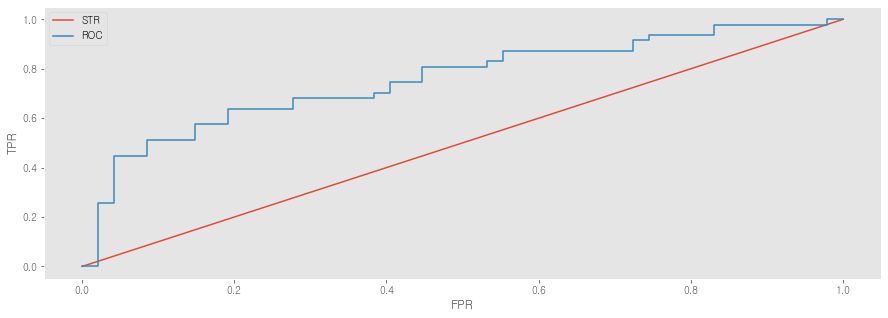

In [515]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=model_best2.predict_proba(x_test_rftree_rf15)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [516]:

#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))



roc auc value 0.7559981892258941


In [517]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('rf_15')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 17

In [518]:

param_list = {"n_estimators": list(range(10, 500, 10)),
              "max_depth": [1,2,3,4,5],}

rf2 = RandomForestClassifier(random_state=1234)

rf2_random_search = RandomizedSearchCV(
        estimator=rf2,
        param_distributions = param_list,
        n_iter = 50,
        cv = 5,
        scoring = 'accuracy')

rf2_random_search.fit(x_train_rftree_rf17, y_train['CIP'])


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
                   n_iter=50,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         120, 130, 140, 150,
                                                         160, 170, 180, 190,
                                                         200, 210, 220, 230,
                                                         240, 250, 260, 270,
                                                         280, 290, 300, ...]},
                   scoring='accuracy')

In [519]:
print('best params : ' ,rf2_random_search.best_params_)
model_best2=rf2_random_search.best_estimator_

best params :  {'n_estimators': 440, 'max_depth': 2}


In [520]:
model_best2 = RandomForestClassifier(n_estimators=120,max_depth=2,random_state=1234)
model_best2.fit(x_train_rftree_rf17, y_train['CIP'])

RandomForestClassifier(max_depth=2, n_estimators=120, random_state=1234)

In [521]:
from sklearn.metrics import accuracy_score

predicted = model_best2.predict(x_test_rftree_rf17)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, average=None)

print(f'accuracy score: {accuracy:.3}')
print(f'recall score: {recall[1]:.3}')

accuracy score: 0.691
recall score: 0.574


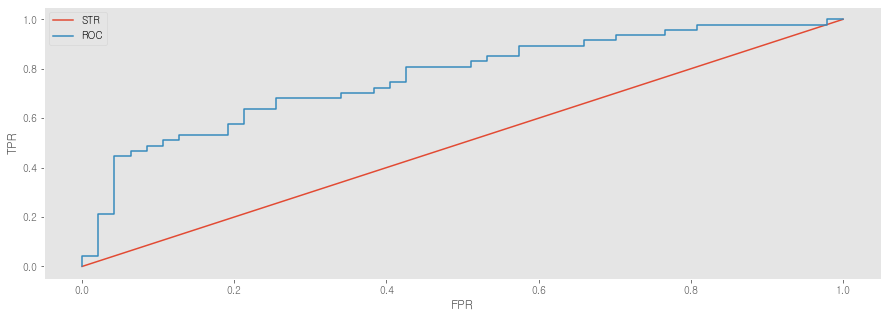

In [522]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=model_best2.predict_proba(x_test_rftree_rf17)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [523]:

#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))



roc auc value 0.7645993662290629


In [524]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('rf_17')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 25

In [525]:

param_list = {"n_estimators": list(range(10, 500, 10)),
              "max_depth": [1,2,3,4,5],}

rf2 = RandomForestClassifier(random_state=1234)

rf2_random_search = RandomizedSearchCV(
        estimator=rf2,
        param_distributions = param_list,
        n_iter = 50,
        cv = 5,
        scoring = 'accuracy')

rf2_random_search.fit(x_train_rftree_rf25, y_train['CIP'])


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
                   n_iter=50,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         120, 130, 140, 150,
                                                         160, 170, 180, 190,
                                                         200, 210, 220, 230,
                                                         240, 250, 260, 270,
                                                         280, 290, 300, ...]},
                   scoring='accuracy')

In [526]:
print('best params : ' ,rf2_random_search.best_params_)
model_best2=rf2_random_search.best_estimator_

best params :  {'n_estimators': 240, 'max_depth': 2}


In [527]:
model_best2 = RandomForestClassifier(n_estimators=120,max_depth=2,random_state=1234)
model_best2.fit(x_train_rftree_rf25, y_train['CIP'])

RandomForestClassifier(max_depth=2, n_estimators=120, random_state=1234)

In [528]:
from sklearn.metrics import accuracy_score

predicted = model_best2.predict(x_test_rftree_rf25)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, average=None)

print(f'accuracy score: {accuracy:.3}')
print(f'recall score: {recall[1]:.3}')

accuracy score: 0.67
recall score: 0.553


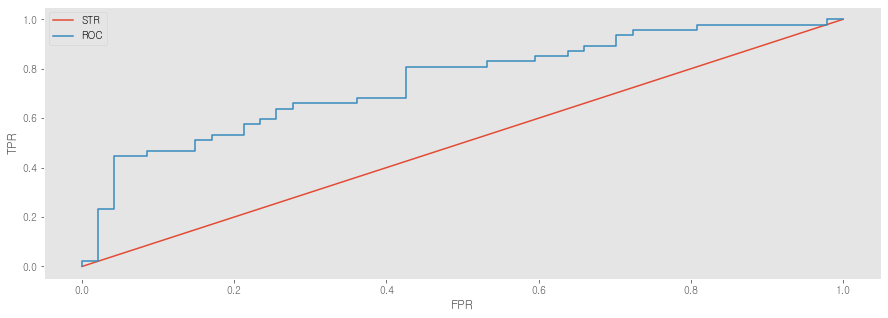

In [529]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=model_best2.predict_proba(x_test_rftree_rf25)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [530]:

#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))



roc auc value 0.7469443186962427


In [531]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('rf_25')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 30

In [532]:

param_list = {"n_estimators": list(range(10, 500, 10)),
              "max_depth": [1,2,3,4,5],}

rf2 = RandomForestClassifier(random_state=1234)

rf2_random_search = RandomizedSearchCV(
        estimator=rf2,
        param_distributions = param_list,
        n_iter = 50,
        cv = 5,
        scoring = 'accuracy')

rf2_random_search.fit(x_train_rftree_rf30, y_train['CIP'])


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
                   n_iter=50,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         120, 130, 140, 150,
                                                         160, 170, 180, 190,
                                                         200, 210, 220, 230,
                                                         240, 250, 260, 270,
                                                         280, 290, 300, ...]},
                   scoring='accuracy')

In [533]:
print('best params : ' ,rf2_random_search.best_params_)
model_best2=rf2_random_search.best_estimator_

best params :  {'n_estimators': 410, 'max_depth': 1}


In [534]:
model_best2 = RandomForestClassifier(n_estimators=120,max_depth=2,random_state=1234)
model_best2.fit(x_train_rftree_rf30, y_train['CIP'])

RandomForestClassifier(max_depth=2, n_estimators=120, random_state=1234)

In [535]:
from sklearn.metrics import accuracy_score

predicted = model_best2.predict(x_test_rftree_rf30)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, average=None)

print(f'accuracy score: {accuracy:.3}')
print(f'recall score: {recall[1]:.3}')

accuracy score: 0.681
recall score: 0.617


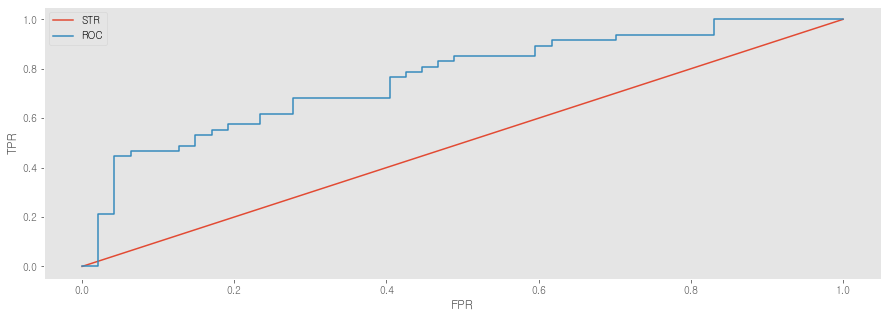

In [536]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=model_best2.predict_proba(x_test_rftree_rf30)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [537]:

#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))



roc auc value 0.7600724309642373


In [538]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('rf_30')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


In [539]:
test_rf= pd.concat([pd.DataFrame(names),
                     pd.DataFrame(aucs),
                     pd.DataFrame(accs),
                     pd.DataFrame(recalls_list),
                     pd.DataFrame(specificitys),
                     pd.DataFrame(f1s)
                    ],axis=1)
test_rf.columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1']

In [540]:


test_rf=test_rf.append({'name':'rf_base','AUC':0.7618,'ACC':0.691,'RECALL':0.574,'SPECIFICITY':0.809,'F1':0.651},ignore_index=True)
test_rf

,name,AUC,ACC,RECALL,SPECIFICITY,F1
0,rf_20,0.762789,0.670213,0.595745,0.744681,0.643678
1,rf_10,0.763920,0.702128,0.553191,0.851064,0.650000
2,rf_15,0.755998,0.712766,0.638298,0.787234,0.689655
3,rf_17,0.764599,0.691489,0.574468,0.808511,0.650602
4,rf_25,0.746944,0.670213,0.553191,0.787234,0.626506
5,rf_30,0.760072,0.680851,0.617021,0.744681,0.659091
6,rf_base,0.761800,0.691000,0.574000,0.809000,0.651000


In [ ]:
STOP....

## Gradient Boost

In [91]:
test_gbm = pd.DataFrame(columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1'])
test_gbm

,name,AUC,ACC,RECALL,SPECIFICITY,F1


In [92]:
names=[]
aucs=[]
accs=[]
recalls_list=[]
specificitys=[]
f1s=[]

In [93]:

x_train_base_gbm = x_train.copy()
x_test_base_gbm = x_test.copy()



In [94]:
x_train_rftree_gbm20=x_train_base_gbm[col_all[:20]]
x_test_rftree_gbm20=x_test_base_gbm[col_all[:20]]

x_train_rftree_gbm10=x_train_base_gbm[col_all[:10]]
x_test_rftree_gbm10=x_test_base_gbm[col_all[:10]]

x_train_rftree_gbm15=x_train_base_gbm[col_all[:15]]
x_test_rftree_gbm15=x_test_base_gbm[col_all[:15]]

x_train_rftree_gbm17=x_train_base_gbm[col_all[:17]]
x_test_rftree_gbm17=x_test_base_gbm[col_all[:17]]

x_train_rftree_gbm25=x_train_base_gbm[col_all[:25]]
x_test_rftree_gbm25=x_test_base_gbm[col_all[:25]]

x_train_rftree_gbm30=x_train_base_gbm[col_all[:30]]
x_test_rftree_gbm30=x_test_base_gbm[col_all[:30]]




### baseline

In [100]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time

# GBM 수행 시간 측정해보기 - 시작하는 시간
start_time = time.time()

gb_clf = GradientBoostingClassifier()
gb_clf.fit(x_train_base_gbm, y_train['CIP'])
gb_pred = gb_clf.predict(x_test_base_gbm)
gb_acc = accuracy_score(y_test, gb_pred)

print(f"기본 모델 정확도 : {gb_acc :.4f}")
print(f"학습 시간 : {time.time()-start_time :.4f}")

## GridSearchCV 이용해서 교차검증&최적의 파라미터 찾기
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': list(range(10, 500, 10)),
    'learning_rate':list(np.arange(0.01, 0.1, 0.01))
}

#param_list = {"n_estimators": list(range(10, 500, 10)),
#              "max_depth": [1,2,3,4,5],}


grid_cv = GridSearchCV(gb_clf, param_grid=params,
                      n_jobs=-1, cv=5, verbose=2)
grid_cv.fit(x_train_base_gbm, y_train)
print("최적의 파라미터:", grid_cv.best_params_)
print("최고의 정확도 :", grid_cv.best_score_)

기본 모델 정확도 : 0.6809
학습 시간 : 0.1534
Fitting 5 folds for each of 441 candidates, totalling 2205 fits


KeyboardInterrupt: 

In [95]:
gb_clf = GradientBoostingClassifier(learning_rate = 0.07, n_estimators= 10,random_state=123)
gb_clf.fit(x_train_base_gbm, y_train['CIP'])
predicted = gb_clf.predict(x_test_base_gbm)
gb_acc = accuracy_score(y_test, predicted)
print(f"최적화 모델 정확도 : {gb_acc :.4f}")

최적화 모델 정확도 : 0.7021


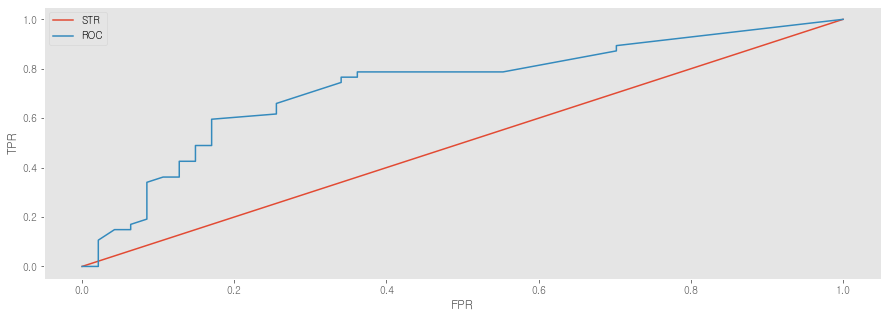

In [96]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=gb_clf.predict_proba(x_test_base_gbm)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [97]:
#baseline - rf tree / auc score
from sklearn.metrics import roc_auc_score

print('roc auc value {}'.format(roc_auc_score(y_test,pred_positive_label) ))


roc auc value 0.7283838841104572


In [98]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('gbm_base')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


#### GBM SHAP

In [99]:
features=x_train_base_gbm.columns.tolist()


In [100]:
explainer = shap.KernelExplainer(gb_clf.predict_proba,x_train_base_gbm) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(x_train_base_gbm,nsamples=100)

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
Using 374 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/374 [00:00<?, ?it/s]

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = 

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessin

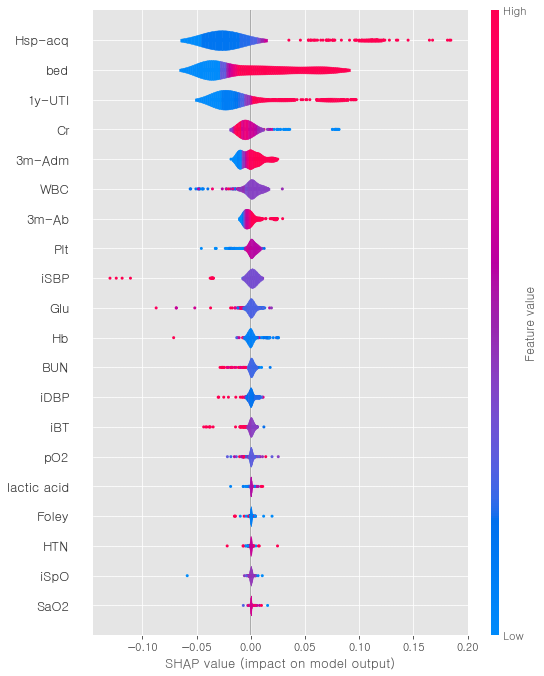

In [101]:
shap.summary_plot(shap_values[1],x_train_base_gbm,feature_names=features,plot_type='violin')

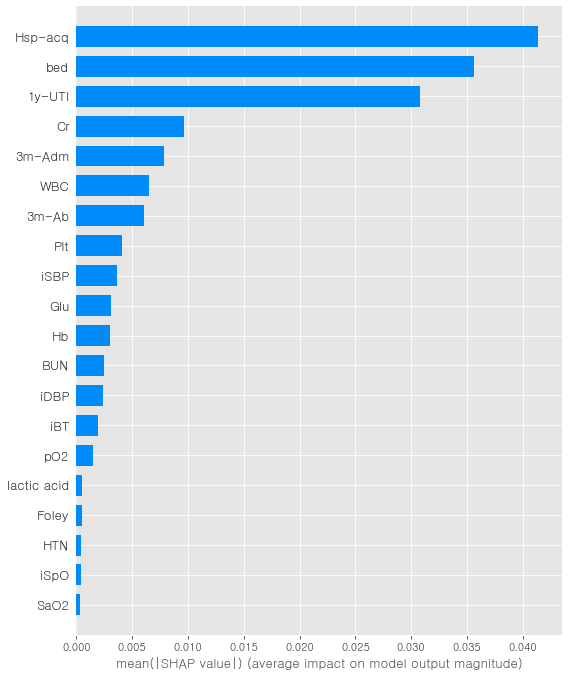

In [102]:
shap.summary_plot(shap_values[1], x_train_base_gbm, plot_type='bar',max_display=20)

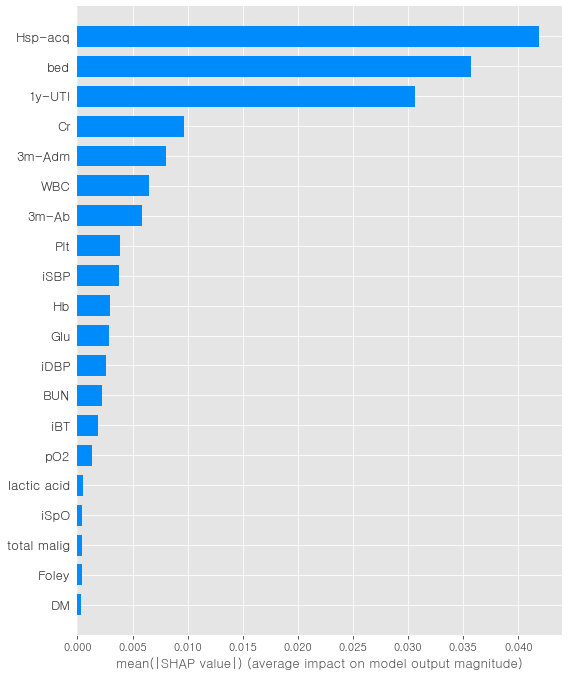

In [76]:
shap.summary_plot(shap_values[1], x_train, plot_type='bar',max_display=20,show=False)
plt.savefig('./FIGURES/gbm_shap.png')

In [103]:
print("column별 mean shap value")
mean_shap_values = []

for i,col in enumerate(list(x_train.columns)): 
    mean_shap = np.mean(np.abs(shap_values[1][:,i]))
    mean_shap_values.append(mean_shap)
    print("{}, {:.8f}".format(col,mean_shap))


column별 mean shap value
sex, 0.00022421
Age, 0.00033315
mc, 0.00023008
iSBP, 0.00361159
iDBP, 0.00241963
iPR, 0.00022108
iRR, 0.00027287
iBT, 0.00190538
iSpO, 0.00041436
Qsofa, 0.00025902
bed, 0.03563024
Foley, 0.00049860
Hsp-acq, 0.04142018
Nursing, 0.00024633
3m-Ab, 0.00601148
3m-Adm, 0.00785755
1y-UTI, 0.03075545
PPIantacid, 0.00032052
DM, 0.00027745
HTN, 0.00042996
CV, 0.00023461
CRF, 0.00025930
total malig, 0.00023635
NR, 0.00024242
pH, 0.00027302
pCO2, 0.00024383
pO2, 0.00149257
HCO3, 0.00021200
SaO2, 0.00034031
lactic acid, 0.00050562
Leukopenia, 0.00023785
WBC, 0.00648517
Hb, 0.00299815
Plt, 0.00406475
CRP, 0.00033453
Glu, 0.00307884
BUN, 0.00251378
Cr, 0.00961349


In [104]:
origin_shap_df=pd.DataFrame({ "col":list(x_train.columns),"mean_shap_values":mean_shap_values})
origin_shap_df=origin_shap_df.sort_values("mean_shap_values",ascending=False)
origin_shap_df=origin_shap_df[:20]
origin_shap_df.to_excel("./values/gbm_shap_val.xlsx",index=False)

### reduced (20)

In [65]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time

# GBM 수행 시간 측정해보기 - 시작하는 시간
start_time = time.time()

gb_clf = GradientBoostingClassifier()
gb_clf.fit(x_train_rftree_gbm20, y_train['CIP'])
gb_pred = gb_clf.predict(x_test_rftree_gbm20)
gb_acc = accuracy_score(y_test, gb_pred)

print(f"기본 모델 정확도 : {gb_acc :.4f}")
print(f"학습 시간 : {time.time()-start_time :.4f}")

## GridSearchCV 이용해서 교차검증&최적의 파라미터 찾기
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': list(range(1, 200, 5)),
    'learning_rate':list(np.arange(0.01, 0.1, 0.01))
}

#param_list = {"n_estimators": list(range(10, 500, 10)),
#              "max_depth": [1,2,3,4,5],}


grid_cv = GridSearchCV(gb_clf, param_grid=params,
                      n_jobs=-1, cv=5, verbose=1)
grid_cv.fit(x_train_base_gbm, y_train)
print("최적의 파라미터:", grid_cv.best_params_)
print("최고의 정확도 :", grid_cv.best_score_)

기본 모델 정확도 : 0.6596
학습 시간 : 0.0952
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
최적의 파라미터: {'learning_rate': 0.02, 'n_estimators': 26}
최고의 정확도 : 0.7005405405405405


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [205]:
gb_clf = GradientBoostingClassifier(learning_rate = 0.02, n_estimators= 26,random_state=123)
gb_clf.fit(x_train_rftree_gbm20, y_train['CIP'])
predicted = gb_clf.predict(x_test_rftree_gbm20)
gb_acc = accuracy_score(y_test, predicted)
print(f"최적화 모델 정확도 : {gb_acc :.4f}")

최적화 모델 정확도 : 0.7021


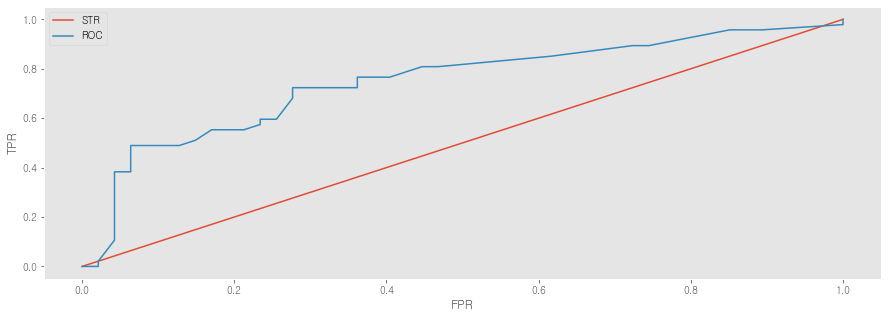

In [207]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=gb_clf.predict_proba(x_test_rftree_gbm20)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [208]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('gbm_20')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 10

In [209]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time

# GBM 수행 시간 측정해보기 - 시작하는 시간
start_time = time.time()

gb_clf = GradientBoostingClassifier()
gb_clf.fit(x_train_rftree_gbm10, y_train['CIP'])
gb_pred = gb_clf.predict(x_test_rftree_gbm10)
gb_acc = accuracy_score(y_test, gb_pred)

print(f"기본 모델 정확도 : {gb_acc :.4f}")
print(f"학습 시간 : {time.time()-start_time :.4f}")

## GridSearchCV 이용해서 교차검증&최적의 파라미터 찾기
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': list(range(1, 200, 5)),
    'learning_rate':list(np.arange(0.01, 0.1, 0.01))
}

#param_list = {"n_estimators": list(range(10, 500, 10)),
#              "max_depth": [1,2,3,4,5],}


grid_cv = GridSearchCV(gb_clf, param_grid=params,
                      n_jobs=-1, cv=5, verbose=1)
grid_cv.fit(x_train_base_gbm, y_train)
print("최적의 파라미터:", grid_cv.best_params_)
print("최고의 정확도 :", grid_cv.best_score_)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [210]:
gb_clf = GradientBoostingClassifier(learning_rate = 0.05, n_estimators= 16,random_state=123)
gb_clf.fit(x_train_rftree_gbm10, y_train['CIP'])
predicted = gb_clf.predict(x_test_rftree_gbm10)
gb_acc = accuracy_score(y_test, predicted)
print(f"최적화 모델 정확도 : {gb_acc :.4f}")

최적화 모델 정확도 : 0.7021


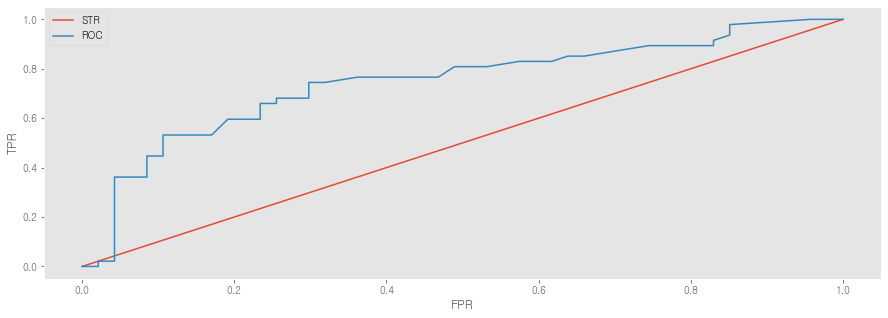

In [211]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=gb_clf.predict_proba(x_test_rftree_gbm10)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [212]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('gbm_10')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 15

In [73]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time

# GBM 수행 시간 측정해보기 - 시작하는 시간
start_time = time.time()

gb_clf = GradientBoostingClassifier()
gb_clf.fit(x_train_rftree_gbm15, y_train['CIP'])
gb_pred = gb_clf.predict(x_test_rftree_gbm15)
gb_acc = accuracy_score(y_test, gb_pred)

print(f"기본 모델 정확도 : {gb_acc :.4f}")
print(f"학습 시간 : {time.time()-start_time :.4f}")

## GridSearchCV 이용해서 교차검증&최적의 파라미터 찾기
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': list(range(1, 200, 5)),
    'learning_rate':list(np.arange(0.01, 0.1, 0.01))
}

#param_list = {"n_estimators": list(range(10, 500, 10)),
#              "max_depth": [1,2,3,4,5],}


grid_cv = GridSearchCV(gb_clf, param_grid=params,
                      n_jobs=-1, cv=5, verbose=1)
grid_cv.fit(x_train_base_gbm, y_train)
print("최적의 파라미터:", grid_cv.best_params_)
print("최고의 정확도 :", grid_cv.best_score_)

기본 모델 정확도 : 0.6809
학습 시간 : 0.0800
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
최적의 파라미터: {'learning_rate': 0.02, 'n_estimators': 26}
최고의 정확도 : 0.7032072072072072


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [213]:
gb_clf = GradientBoostingClassifier(learning_rate = 0.02, n_estimators= 26,random_state=123)
gb_clf.fit(x_train_rftree_gbm15, y_train['CIP'])
predicted = gb_clf.predict(x_test_rftree_gbm15)
gb_acc = accuracy_score(y_test, predicted)
print(f"최적화 모델 정확도 : {gb_acc :.4f}")

최적화 모델 정확도 : 0.6809


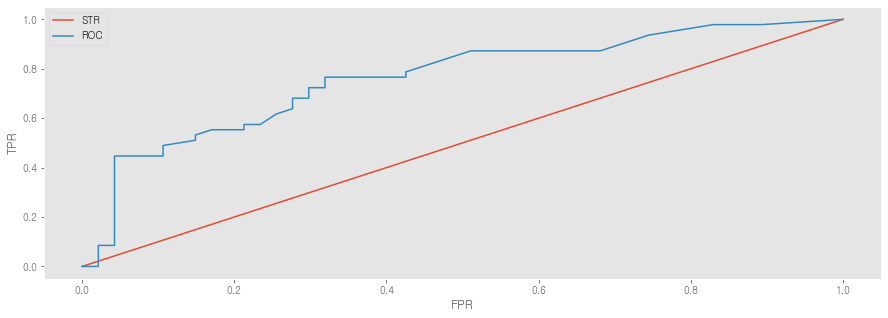

In [214]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=gb_clf.predict_proba(x_test_rftree_gbm15)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [215]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('gbm_15')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 17

In [77]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time

# GBM 수행 시간 측정해보기 - 시작하는 시간
start_time = time.time()

gb_clf = GradientBoostingClassifier()
gb_clf.fit(x_train_rftree_gbm17, y_train['CIP'])
gb_pred = gb_clf.predict(x_test_rftree_gbm17)
gb_acc = accuracy_score(y_test, gb_pred)

print(f"기본 모델 정확도 : {gb_acc :.4f}")
print(f"학습 시간 : {time.time()-start_time :.4f}")

## GridSearchCV 이용해서 교차검증&최적의 파라미터 찾기
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': list(range(1, 200, 5)),
    'learning_rate':list(np.arange(0.01, 0.1, 0.01))
}

#param_list = {"n_estimators": list(range(10, 500, 10)),
#              "max_depth": [1,2,3,4,5],}


grid_cv = GridSearchCV(gb_clf, param_grid=params,
                      n_jobs=-1, cv=5, verbose=1)
grid_cv.fit(x_train_base_gbm, y_train)
print("최적의 파라미터:", grid_cv.best_params_)
print("최고의 정확도 :", grid_cv.best_score_)

기본 모델 정확도 : 0.6915
학습 시간 : 0.0889
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
최적의 파라미터: {'learning_rate': 0.06999999999999999, 'n_estimators': 11}
최고의 정확도 : 0.7032072072072072


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [216]:
gb_clf = GradientBoostingClassifier(learning_rate = 0.07, n_estimators= 11,random_state=123)
gb_clf.fit(x_train_rftree_gbm17, y_train['CIP'])
predicted = gb_clf.predict(x_test_rftree_gbm17)
gb_acc = accuracy_score(y_test, predicted)
print(f"최적화 모델 정확도 : {gb_acc :.4f}")

최적화 모델 정확도 : 0.7128


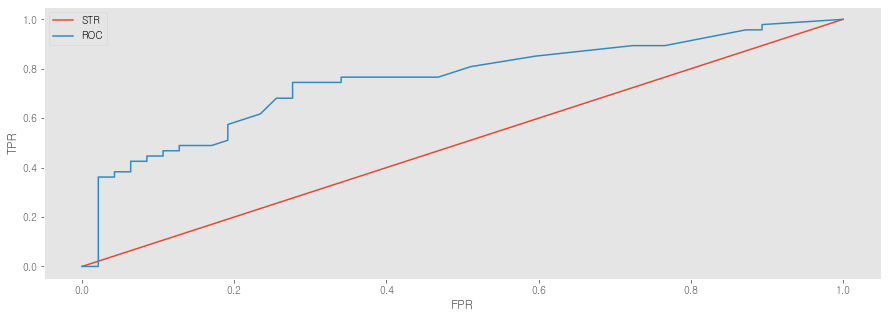

In [217]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=gb_clf.predict_proba(x_test_rftree_gbm17)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [218]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('gbm_17')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 25

In [81]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time

# GBM 수행 시간 측정해보기 - 시작하는 시간
start_time = time.time()

gb_clf = GradientBoostingClassifier()
gb_clf.fit(x_train_rftree_gbm25, y_train['CIP'])
gb_pred = gb_clf.predict(x_test_rftree_gbm25)
gb_acc = accuracy_score(y_test, gb_pred)

print(f"기본 모델 정확도 : {gb_acc :.4f}")
print(f"학습 시간 : {time.time()-start_time :.4f}")

## GridSearchCV 이용해서 교차검증&최적의 파라미터 찾기
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': list(range(1, 200, 5)),
    'learning_rate':list(np.arange(0.01, 0.1, 0.01))
}

#param_list = {"n_estimators": list(range(10, 500, 10)),
#              "max_depth": [1,2,3,4,5],}


grid_cv = GridSearchCV(gb_clf, param_grid=params,
                      n_jobs=-1, cv=5, verbose=1)
grid_cv.fit(x_train_base_gbm, y_train)
print("최적의 파라미터:", grid_cv.best_params_)
print("최고의 정확도 :", grid_cv.best_score_)

기본 모델 정확도 : 0.6277
학습 시간 : 0.1210
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
최적의 파라미터: {'learning_rate': 0.06999999999999999, 'n_estimators': 11}
최고의 정확도 : 0.7032072072072072


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [219]:
gb_clf = GradientBoostingClassifier(learning_rate = 0.07, n_estimators= 11,random_state=123)
gb_clf.fit(x_train_rftree_gbm25, y_train['CIP'])
predicted = gb_clf.predict(x_test_rftree_gbm25)
gb_acc = accuracy_score(y_test, predicted)
print(f"최적화 모델 정확도 : {gb_acc :.4f}")

최적화 모델 정확도 : 0.6915


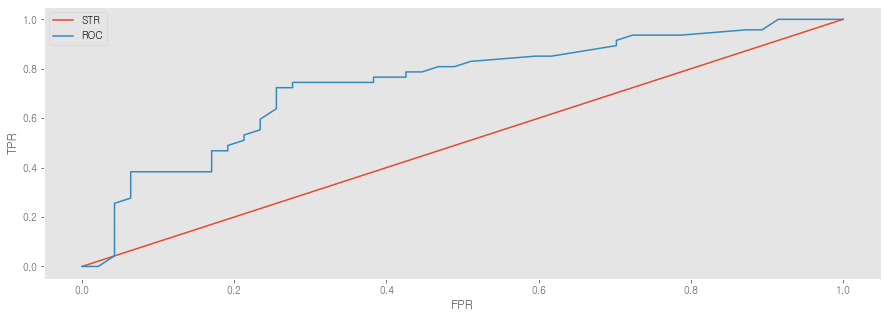

In [220]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=gb_clf.predict_proba(x_test_rftree_gbm25)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [221]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('gbm_25')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 30

In [85]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time

# GBM 수행 시간 측정해보기 - 시작하는 시간
start_time = time.time()

gb_clf = GradientBoostingClassifier()
gb_clf.fit(x_train_rftree_gbm30, y_train['CIP'])
gb_pred = gb_clf.predict(x_test_rftree_gbm30)
gb_acc = accuracy_score(y_test, gb_pred)

print(f"기본 모델 정확도 : {gb_acc :.4f}")
print(f"학습 시간 : {time.time()-start_time :.4f}")

## GridSearchCV 이용해서 교차검증&최적의 파라미터 찾기
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': list(range(1, 200, 5)),
    'learning_rate':list(np.arange(0.01, 0.1, 0.01))
}

#param_list = {"n_estimators": list(range(10, 500, 10)),
#              "max_depth": [1,2,3,4,5],}


grid_cv = GridSearchCV(gb_clf, param_grid=params,
                      n_jobs=-1, cv=5, verbose=1)
grid_cv.fit(x_train_base_gbm, y_train)
print("최적의 파라미터:", grid_cv.best_params_)
print("최고의 정확도 :", grid_cv.best_score_)

기본 모델 정확도 : 0.6702
학습 시간 : 0.1330
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
최적의 파라미터: {'learning_rate': 0.02, 'n_estimators': 26}
최고의 정확도 : 0.7005405405405405


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [222]:
gb_clf = GradientBoostingClassifier(learning_rate = 0.02, n_estimators= 26,random_state=123)
gb_clf.fit(x_train_rftree_gbm30, y_train['CIP'])
predicted = gb_clf.predict(x_test_rftree_gbm30)
gb_acc = accuracy_score(y_test, predicted)
print(f"최적화 모델 정확도 : {gb_acc :.4f}")

최적화 모델 정확도 : 0.6915


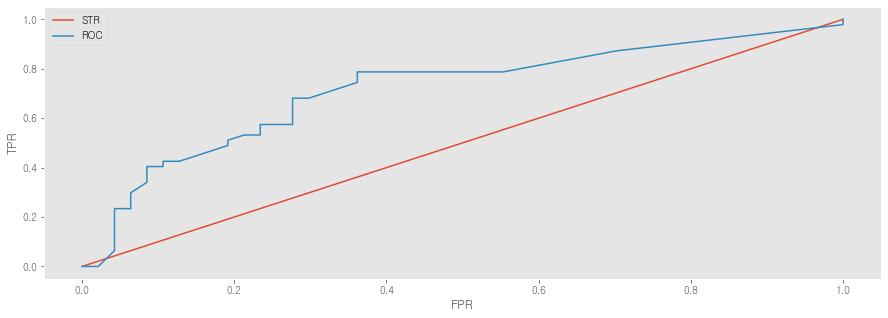

In [223]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=gb_clf.predict_proba(x_test_rftree_gbm30)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [224]:
auc=roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('gbm_30')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


In [225]:
test_gbm= pd.concat([pd.DataFrame(names),
                     pd.DataFrame(aucs),
                     pd.DataFrame(accs),
                     pd.DataFrame(recalls_list),
                     pd.DataFrame(specificitys),
                     pd.DataFrame(f1s)
                    ],axis=1)
test_gbm.columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1']

In [226]:
test_gbm.sort_values("name")

,name,AUC,ACC,RECALL,SPECIFICITY,F1
2,gbm_10,0.744228,0.702128,0.638298,0.765957,0.681818
3,gbm_15,0.762336,0.680851,0.617021,0.744681,0.659091
4,gbm_17,0.752377,0.712766,0.680851,0.744681,0.703297
1,gbm_20,0.746944,0.702128,0.680851,0.723404,0.695652
5,gbm_25,0.737890,0.691489,0.638298,0.744681,0.674157
6,gbm_30,0.716161,0.691489,0.659574,0.723404,0.681319
0,gbm_base,0.728384,0.702128,0.574468,0.829787,0.658537


In [ ]:
STOP....

## MLP

In [105]:
test_mlp = pd.DataFrame(columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1'])
test_mlp

,name,AUC,ACC,RECALL,SPECIFICITY,F1


In [106]:
names=[]
aucs=[]
accs=[]
recalls_list=[]
specificitys=[]
f1s=[]

In [107]:
x_train_base_mlp = x_train.copy()
x_test_base_mlp = x_test.copy()

import statsmodels.api as sm

numeric_cols=[]
for idx,col in enumerate(x_train.columns):
    col_type = x_train[col].dtype
    if col_type.name !='category':
        numeric_cols.append(col)

scaler = StandardScaler()


x_train_base_mlp[numeric_cols] = scaler.fit_transform(x_train_base_mlp[numeric_cols])
x_test_base_mlp[numeric_cols] = scaler.transform(x_test_base_mlp[numeric_cols])


In [108]:
x_train_rftree_mlp20=x_train_base_mlp[col_all[:20]]
x_test_rftree_mlp20=x_test_base_mlp[col_all[:20]]

x_train_rftree_mlp10=x_train_base_mlp[col_all[:10]]
x_test_rftree_mlp10=x_test_base_mlp[col_all[:10]]

x_train_rftree_mlp15=x_train_base_mlp[col_all[:15]]
x_test_rftree_mlp15=x_test_base_mlp[col_all[:15]]

x_train_rftree_mlp17=x_train_base_mlp[col_all[:17]]
x_test_rftree_mlp17=x_test_base_mlp[col_all[:17]]

x_train_rftree_mlp25=x_train_base_mlp[col_all[:25]]
x_test_rftree_mlp25=x_test_base_mlp[col_all[:25]]

x_train_rftree_mlp30=x_train_base_mlp[col_all[:30]]
x_test_rftree_mlp30=x_test_base_mlp[col_all[:30]]




### baseline

In [111]:
# train,valid 나누기
# exp : 학습 중이란 뜻
x_train_base_mlp_exp, x_val_base_mlp_exp,\
y_train_base_mlp_exp, y_val_base_mlp_exp = train_test_split(x_train_base_mlp,y_train,stratify=y_train,\
                                                  test_size=0.2,random_state=42)  # 훈련 데이터와 검증 데이터 분류
print("train :{} / valid : {} ".format(y_train_base_mlp_exp.shape[0],y_val_base_mlp_exp.shape[0] ))

train :299 / valid : 75 


In [110]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 4,log=False)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 20, 100,log=False))
    clf = MLPClassifier(hidden_layer_sizes=tuple(layers),
                                                activation='relu', \
                                                solver='adam', alpha=0.01, batch_size=32, \
                                                learning_rate_init=0.1, max_iter=500,random_state=42)
    clf.fit(x_train_base_mlp_exp, np.ravel(y_train_base_mlp_exp))

    return clf.score(x_val_base_mlp_exp, np.ravel(y_val_base_mlp_exp))

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

Training interrupted by user.
Training interrupted by user.
[W 2022-09-30 18:00:50,115] Trial 40 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "C:\Users\dlwhd\miniconda3\envs\localtorch\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\dlwhd\AppData\Local\Temp/ipykernel_19484/573204333.py", line 6, in objective
    layers.append(trial.suggest_int(f'n_units_{i}', 20, 100,log=False))
  File "C:\Users\dlwhd\miniconda3\envs\localtorch\lib\site-packages\optuna\trial\_trial.py", line 315, in suggest_int
    return int(self._suggest(name, distribution))
  File "C:\Users\dlwhd\miniconda3\envs\localtorch\lib\site-packages\optuna\trial\_trial.py", line 596, in _suggest
    study, trial, name, distribution
  File "C:\Users\dlwhd\miniconda3\envs\localtorch\lib\site-packages\optuna\samplers\_tpe\sampler.py", line 479, in sample_independent
    log_likelihoods_above = mpe_abo

KeyboardInterrupt: 

In [ ]:
print("best params : ",study.best_params)
mlp = MLPClassifier(hidden_layer_sizes = list(study.best_params.values())[1:],
                    activation='relu', \
                    solver='adam', alpha=0.01, batch_size=32, \
                    learning_rate_init=0.1, max_iter=500,random_state=42)  # 객체 생성

mlp.fit(x_train_base_mlp_exp, np.ravel(y_train_base_mlp_exp))    # 훈련하기

print("훈련 세트 정확도: {:.3f}".format(mlp.score(x_train_base_mlp_exp, np.ravel(y_train_base_mlp_exp) ) ) )
print("검증 세트 정확도: {:.3f}".format(mlp.score(x_val_base_mlp_exp, np.ravel(y_val_base_mlp_exp) ) ) )
print("테스트 세트 정확도: {:.3f}".format(mlp.score(x_test_base_mlp, np.ravel(y_test) ) ) )
predicted = mlp.predict(x_test_base_mlp)

In [112]:
## parameter 저장용
#stop()
mlp = MLPClassifier(hidden_layer_sizes = [73,],
                    activation='relu', \
                    solver='adam', alpha=0.01, batch_size=32, \
                    learning_rate_init=0.1, max_iter=500,random_state=42)  # 객체 생성

mlp.fit(x_train_base_mlp_exp, np.ravel(y_train_base_mlp_exp))    # 훈련하기

print("훈련 세트 정확도: {:.3f}".format(mlp.score(x_train_base_mlp_exp, np.ravel(y_train_base_mlp_exp) ) ) )
print("검증 세트 정확도: {:.3f}".format(mlp.score(x_val_base_mlp_exp, np.ravel(y_val_base_mlp_exp) ) ) )
print("테스트 세트 정확도: {:.3f}".format(mlp.score(x_test_base_mlp, np.ravel(y_test) ) ) )
predicted = mlp.predict(x_test_base_mlp)

훈련 세트 정확도: 0.903
검증 세트 정확도: 0.760
테스트 세트 정확도: 0.628


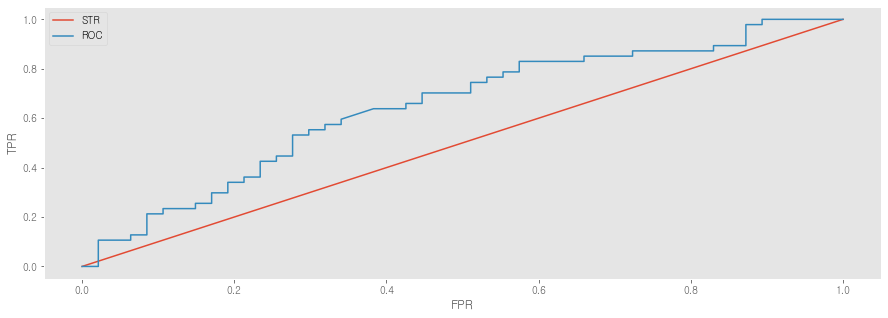

In [113]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=mlp.predict_proba(x_test_base_mlp)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [114]:
auc = roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('mlp_base')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


In [115]:
test_mlp= pd.concat([pd.DataFrame(names),
                     pd.DataFrame(aucs),
                     pd.DataFrame(accs),
                     pd.DataFrame(recalls_list),
                     pd.DataFrame(specificitys),
                     pd.DataFrame(f1s)
                    ],axis=1)
test_mlp.columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1']

In [116]:
test_mlp

,name,AUC,ACC,RECALL,SPECIFICITY,F1
0,mlp_base,0.646446,0.62766,0.702128,0.553191,0.653465


#### MLP SHAP

In [117]:
features=x_train_base_mlp_exp.columns.tolist()


In [118]:
explainer = shap.KernelExplainer(mlp.predict,x_train_base_mlp_exp) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(x_train_base_mlp_exp,nsamples=100)

X does not have valid feature names, but MLPClassifier was fitted with feature names
Using 299 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/299 [00:00<?, ?it/s]

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will b

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will b

X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will b

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will b

X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will b

X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will b

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will b

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will b

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will b

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will b

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will b

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will b

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will b

X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will b

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will b

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will b

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will b

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will b

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will b

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will b

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will b

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will b

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will b

X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the

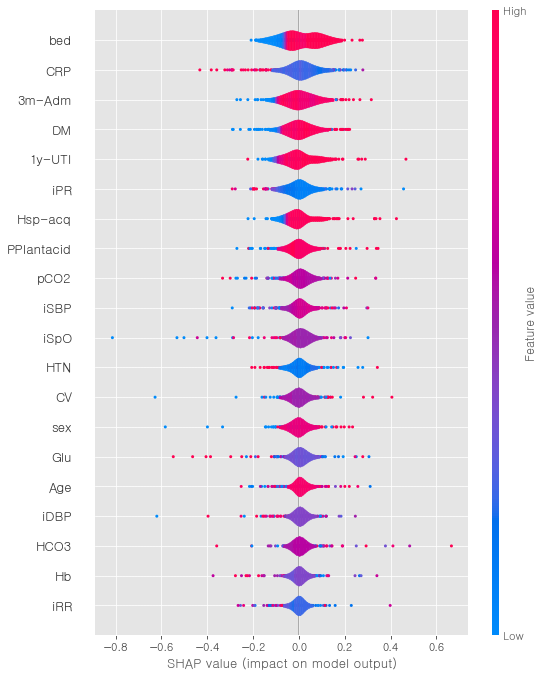

In [119]:
shap.summary_plot(shap_values,x_train_base_mlp_exp,feature_names=features,plot_type='violin')

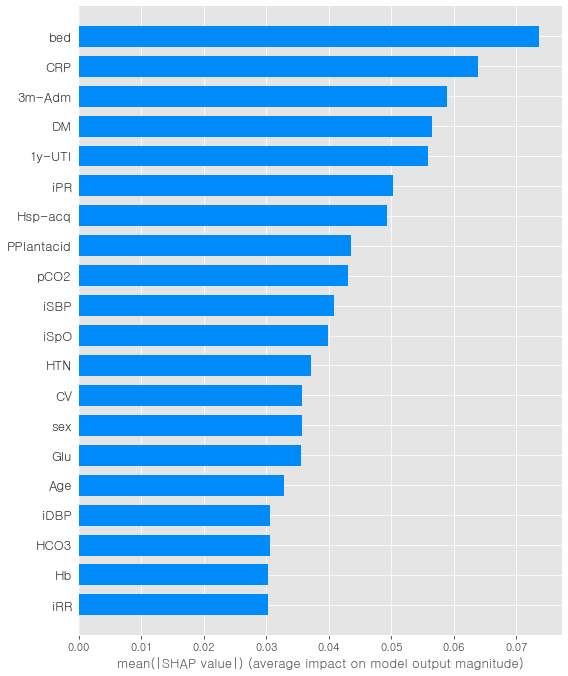

In [120]:
shap.summary_plot(shap_values, x_train_base_mlp_exp, plot_type='bar',max_display=20)

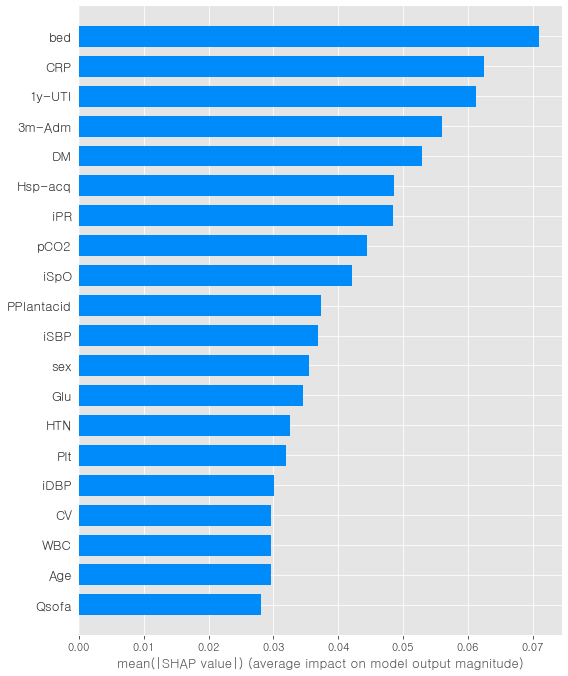

In [101]:
shap.summary_plot(shap_values, x_train_base_mlp_exp, plot_type='bar',max_display=20,show=False)
plt.savefig('./FIGURES/mlp_shap.png')

In [121]:
print("column별 mean shap value")
mean_shap_values = []

for i,col in enumerate(list(x_train.columns)): 
    mean_shap = np.mean(np.abs(shap_values[:,i]))
    mean_shap_values.append(mean_shap)
    print("{}, {:.8f}".format(col,mean_shap))


column별 mean shap value
sex, 0.03570749
Age, 0.03276631
mc, 0.02174813
iSBP, 0.04074380
iDBP, 0.03051268
iPR, 0.05028665
iRR, 0.03018582
iBT, 0.02534548
iSpO, 0.03990811
Qsofa, 0.02902692
bed, 0.07354546
Foley, 0.02445788
Hsp-acq, 0.04921068
Nursing, 0.01980945
3m-Ab, 0.03006686
3m-Adm, 0.05890285
1y-UTI, 0.05577447
PPIantacid, 0.04359670
DM, 0.05650042
HTN, 0.03715680
CV, 0.03570953
CRF, 0.02733901
total malig, 0.02316514
NR, 0.02947232
pH, 0.01811071
pCO2, 0.04310067
pO2, 0.02817919
HCO3, 0.03050663
SaO2, 0.01749450
lactic acid, 0.02638582
Leukopenia, 0.01992903
WBC, 0.03010094
Hb, 0.03024823
Plt, 0.02918256
CRP, 0.06379951
Glu, 0.03545869
BUN, 0.02747389
Cr, 0.02674003


In [122]:
origin_shap_df=pd.DataFrame({ "col":list(x_train.columns),"mean_shap_values":mean_shap_values})
origin_shap_df=origin_shap_df.sort_values("mean_shap_values",ascending=False)
origin_shap_df=origin_shap_df[:20]
origin_shap_df.to_excel("./values/mlp_shap_val.xlsx",index=False)

### reduced (20)

In [47]:
# train,valid 나누기
# exp : 학습 중이란 뜻
x_train_rftree_mlp20_exp, x_val_rftree_mlp20_exp,\
y_train_rftree_mlp20_exp, y_val_rftree_mlp20_exp = train_test_split(x_train_rftree_mlp20,y_train,stratify=y_train,\
                                                  test_size=0.2,random_state=42)  # 훈련 데이터와 검증 데이터 분류


In [48]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 4,log=False)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 20, 100,log=False))
    clf = MLPClassifier(hidden_layer_sizes=tuple(layers),
                                                activation='relu', \
                                                solver='adam', alpha=0.01, batch_size=32, \
                                                learning_rate_init=0.1, max_iter=500,random_state=42)
    clf.fit(x_train_rftree_mlp20_exp, np.ravel(y_train_rftree_mlp20_exp))

    return clf.score(x_val_rftree_mlp20_exp, np.ravel(y_val_rftree_mlp20_exp))

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

In [49]:
print("best params : ",study.best_params)
mlp = MLPClassifier(hidden_layer_sizes = list(study.best_params.values())[1:],
                    activation='relu', \
                    solver='adam', alpha=0.01, batch_size=32, \
                    learning_rate_init=0.1, max_iter=500,random_state=42)  # 객체 생성

mlp.fit(x_train_rftree_mlp20_exp, np.ravel(y_train_rftree_mlp20_exp))    # 훈련하기

print("훈련 세트 정확도: {:.3f}".format(mlp.score(x_train_rftree_mlp20_exp, np.ravel(y_train_rftree_mlp20_exp) ) ) )
print("검증 세트 정확도: {:.3f}".format(mlp.score(x_val_rftree_mlp20_exp, np.ravel(y_val_rftree_mlp20_exp) ) ) )
print("테스트 세트 정확도: {:.3f}".format(mlp.score(x_test_rftree_mlp20, np.ravel(y_test) ) ) )
predicted = mlp.predict(x_test_rftree_mlp20)

best params :  {'n_layers': 2, 'n_units_0': 40, 'n_units_1': 27}
훈련 세트 정확도: 0.883
검증 세트 정확도: 0.773
테스트 세트 정확도: 0.702


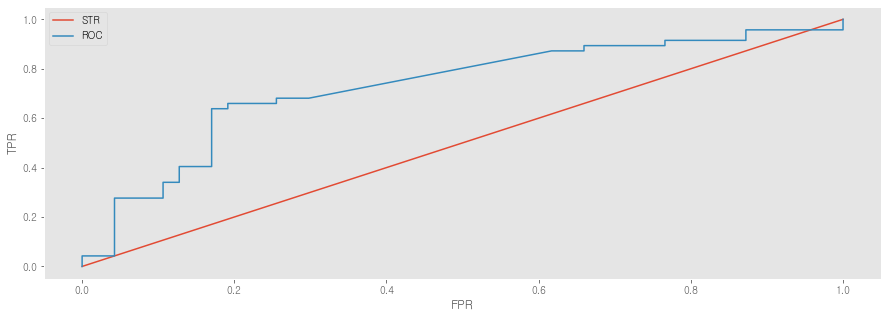

In [50]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=mlp.predict_proba(x_test_rftree_mlp20)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [51]:
auc = roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('mlp_20')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


In [52]:
test_mlp= pd.concat([pd.DataFrame(names),
                     pd.DataFrame(aucs),
                     pd.DataFrame(accs),
                     pd.DataFrame(recalls_list),
                     pd.DataFrame(specificitys),
                     pd.DataFrame(f1s)
                    ],axis=1)
test_mlp.columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1']

In [53]:
test_mlp

,name,AUC,ACC,RECALL,SPECIFICITY,F1
0,mlp_base,0.646446,0.627660,0.702128,0.553191,0.653465
1,mlp_20,0.728158,0.702128,0.659574,0.744681,0.688889


### 변수 10

In [55]:
# train,valid 나누기
# exp : 학습 중이란 뜻
x_train_rftree_mlp10_exp, x_val_rftree_mlp10_exp,\
y_train_rftree_mlp10_exp, y_val_rftree_mlp10_exp = train_test_split(x_train_rftree_mlp10,y_train,stratify=y_train,\
                                                  test_size=0.2,random_state=42)  # 훈련 데이터와 검증 데이터 분류


In [56]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 4,log=False)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 20, 100,log=False))
    clf = MLPClassifier(hidden_layer_sizes=tuple(layers),
                                                activation='relu', \
                                                solver='adam', alpha=0.01, batch_size=32, \
                                                learning_rate_init=0.1, max_iter=500,random_state=42)
    clf.fit(x_train_rftree_mlp10_exp, np.ravel(y_train_rftree_mlp10_exp))

    return clf.score(x_val_rftree_mlp10_exp, np.ravel(y_val_rftree_mlp10_exp))

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

In [57]:
print("best params : ",study.best_params)
mlp = MLPClassifier(hidden_layer_sizes = list(study.best_params.values())[1:],
                    activation='relu', \
                    solver='adam', alpha=0.01, batch_size=32, \
                    learning_rate_init=0.1, max_iter=500,random_state=42)  # 객체 생성

mlp.fit(x_train_rftree_mlp10_exp, np.ravel(y_train_rftree_mlp10_exp))    # 훈련하기

print("훈련 세트 정확도: {:.3f}".format(mlp.score(x_train_rftree_mlp10_exp, np.ravel(y_train_rftree_mlp10_exp) ) ) )
print("검증 세트 정확도: {:.3f}".format(mlp.score(x_val_rftree_mlp10_exp, np.ravel(y_val_rftree_mlp10_exp) ) ) )
print("테스트 세트 정확도: {:.3f}".format(mlp.score(x_test_rftree_mlp10, np.ravel(y_test) ) ) )
predicted = mlp.predict(x_test_rftree_mlp10)

best params :  {'n_layers': 4, 'n_units_0': 29, 'n_units_1': 26, 'n_units_2': 90, 'n_units_3': 27}
훈련 세트 정확도: 0.749
검증 세트 정확도: 0.813
테스트 세트 정확도: 0.681


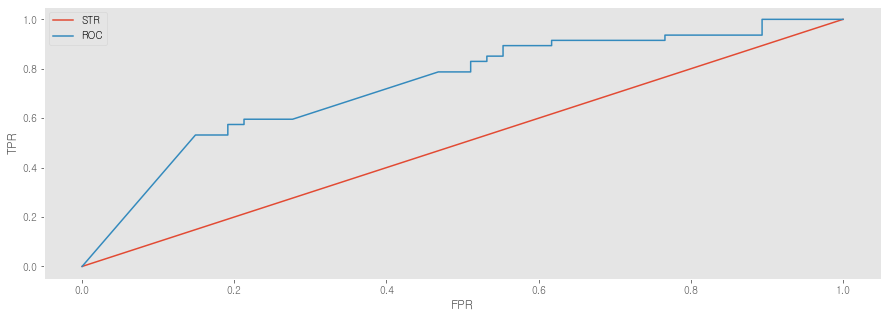

In [58]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=mlp.predict_proba(x_test_rftree_mlp10)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [59]:
auc = roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('mlp_10')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


In [60]:
test_mlp= pd.concat([pd.DataFrame(names),
                     pd.DataFrame(aucs),
                     pd.DataFrame(accs),
                     pd.DataFrame(recalls_list),
                     pd.DataFrame(specificitys),
                     pd.DataFrame(f1s)
                    ],axis=1)
test_mlp.columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1']

In [61]:
test_mlp

,name,AUC,ACC,RECALL,SPECIFICITY,F1
0,mlp_base,0.646446,0.627660,0.702128,0.553191,0.653465
1,mlp_20,0.728158,0.702128,0.659574,0.744681,0.688889
2,mlp_10,0.733364,0.680851,0.595745,0.765957,0.651163


### 변수 15

In [62]:
# train,valid 나누기
# exp : 학습 중이란 뜻
x_train_rftree_mlp15_exp, x_val_rftree_mlp15_exp,\
y_train_rftree_mlp15_exp, y_val_rftree_mlp15_exp = train_test_split(x_train_rftree_mlp15,y_train,stratify=y_train,\
                                                  test_size=0.2,random_state=42)  # 훈련 데이터와 검증 데이터 분류


In [64]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 4,log=False)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 20, 100,log=False))
    clf = MLPClassifier(hidden_layer_sizes=tuple(layers),
                                                activation='relu', \
                                                solver='adam', alpha=0.01, batch_size=32, \
                                                learning_rate_init=0.1, max_iter=500,random_state=42)
    clf.fit(x_train_rftree_mlp15_exp, np.ravel(y_train_rftree_mlp15_exp))

    return clf.score(x_val_rftree_mlp15_exp, np.ravel(y_val_rftree_mlp15_exp))

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

In [65]:
print("best params : ",study.best_params)
mlp = MLPClassifier(hidden_layer_sizes = list(study.best_params.values())[1:],
                    activation='relu', \
                    solver='adam', alpha=0.01, batch_size=32, \
                    learning_rate_init=0.1, max_iter=500,random_state=42)  # 객체 생성

mlp.fit(x_train_rftree_mlp15_exp, np.ravel(y_train_rftree_mlp15_exp))    # 훈련하기

print("훈련 세트 정확도: {:.3f}".format(mlp.score(x_train_rftree_mlp15_exp, np.ravel(y_train_rftree_mlp15_exp) ) ) )
print("검증 세트 정확도: {:.3f}".format(mlp.score(x_val_rftree_mlp15_exp, np.ravel(y_val_rftree_mlp15_exp) ) ) )
print("테스트 세트 정확도: {:.3f}".format(mlp.score(x_test_rftree_mlp15, np.ravel(y_test) ) ) )
predicted = mlp.predict(x_test_rftree_mlp15)

best params :  {'n_layers': 4, 'n_units_0': 37, 'n_units_1': 62, 'n_units_2': 50, 'n_units_3': 97}
훈련 세트 정확도: 0.756
검증 세트 정확도: 0.813
테스트 세트 정확도: 0.670


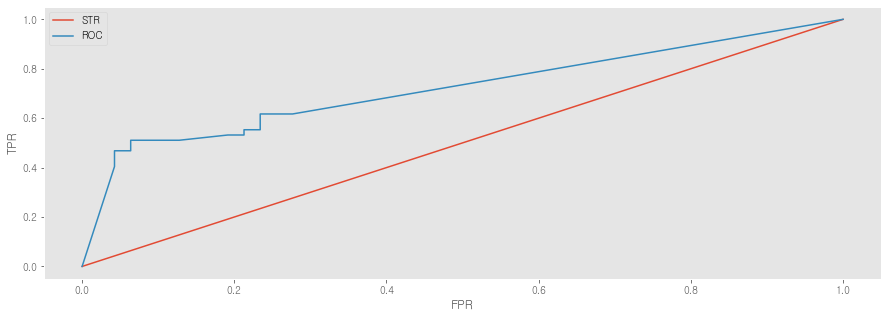

In [66]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=mlp.predict_proba(x_test_rftree_mlp15)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [67]:
auc = roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('mlp_15')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 17

In [70]:
# train,valid 나누기
# exp : 학습 중이란 뜻
x_train_rftree_mlp17_exp, x_val_rftree_mlp17_exp,\
y_train_rftree_mlp17_exp, y_val_rftree_mlp17_exp = train_test_split(x_train_rftree_mlp17,y_train,stratify=y_train,\
                                                  test_size=0.2,random_state=42)  # 훈련 데이터와 검증 데이터 분류


In [69]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 4,log=False)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 20, 100,log=False))
    clf = MLPClassifier(hidden_layer_sizes=tuple(layers),
                                                activation='relu', \
                                                solver='adam', alpha=0.01, batch_size=32, \
                                                learning_rate_init=0.1, max_iter=500,random_state=42)
    clf.fit(x_train_rftree_mlp17_exp, np.ravel(y_train_rftree_mlp17_exp))

    return clf.score(x_val_rftree_mlp17_exp, np.ravel(y_val_rftree_mlp17_exp))

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

In [71]:
print("best params : ",study.best_params)
mlp = MLPClassifier(hidden_layer_sizes = list(study.best_params.values())[1:],
                    activation='relu', \
                    solver='adam', alpha=0.01, batch_size=32, \
                    learning_rate_init=0.1, max_iter=500,random_state=42)  # 객체 생성

mlp.fit(x_train_rftree_mlp17_exp, np.ravel(y_train_rftree_mlp17_exp))    # 훈련하기

print("훈련 세트 정확도: {:.3f}".format(mlp.score(x_train_rftree_mlp17_exp, np.ravel(y_train_rftree_mlp17_exp) ) ) )
print("검증 세트 정확도: {:.3f}".format(mlp.score(x_val_rftree_mlp17_exp, np.ravel(y_val_rftree_mlp17_exp) ) ) )
print("테스트 세트 정확도: {:.3f}".format(mlp.score(x_test_rftree_mlp17, np.ravel(y_test) ) ) )
predicted = mlp.predict(x_test_rftree_mlp17)

best params :  {'n_layers': 3, 'n_units_0': 61, 'n_units_1': 33, 'n_units_2': 100}
훈련 세트 정확도: 0.779
검증 세트 정확도: 0.773
테스트 세트 정확도: 0.702


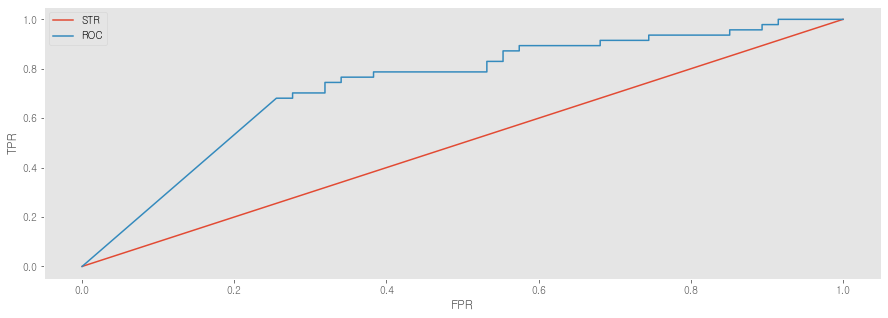

In [72]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=mlp.predict_proba(x_test_rftree_mlp17)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [73]:
auc = roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('mlp_17')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 25

In [75]:
# train,valid 나누기
# exp : 학습 중이란 뜻
x_train_rftree_mlp25_exp, x_val_rftree_mlp25_exp,\
y_train_rftree_mlp25_exp, y_val_rftree_mlp25_exp = train_test_split(x_train_rftree_mlp25,y_train,stratify=y_train,\
                                                  test_size=0.2,random_state=42)  # 훈련 데이터와 검증 데이터 분류


In [76]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 4,log=False)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 20, 100,log=False))
    clf = MLPClassifier(hidden_layer_sizes=tuple(layers),
                                                activation='relu', \
                                                solver='adam', alpha=0.01, batch_size=32, \
                                                learning_rate_init=0.1, max_iter=500,random_state=42)
    clf.fit(x_train_rftree_mlp25_exp, np.ravel(y_train_rftree_mlp25_exp))

    return clf.score(x_val_rftree_mlp25_exp, np.ravel(y_val_rftree_mlp25_exp))

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

In [77]:
print("best params : ",study.best_params)
mlp = MLPClassifier(hidden_layer_sizes = list(study.best_params.values())[1:],
                    activation='relu', \
                    solver='adam', alpha=0.01, batch_size=32, \
                    learning_rate_init=0.1, max_iter=500,random_state=42)  # 객체 생성

mlp.fit(x_train_rftree_mlp25_exp, np.ravel(y_train_rftree_mlp25_exp))    # 훈련하기

print("훈련 세트 정확도: {:.3f}".format(mlp.score(x_train_rftree_mlp25_exp, np.ravel(y_train_rftree_mlp25_exp) ) ) )
print("검증 세트 정확도: {:.3f}".format(mlp.score(x_val_rftree_mlp25_exp, np.ravel(y_val_rftree_mlp25_exp) ) ) )
print("테스트 세트 정확도: {:.3f}".format(mlp.score(x_test_rftree_mlp25, np.ravel(y_test) ) ) )
predicted = mlp.predict(x_test_rftree_mlp25)

best params :  {'n_layers': 3, 'n_units_0': 57, 'n_units_1': 33, 'n_units_2': 42}
훈련 세트 정확도: 0.753
검증 세트 정확도: 0.760
테스트 세트 정확도: 0.691


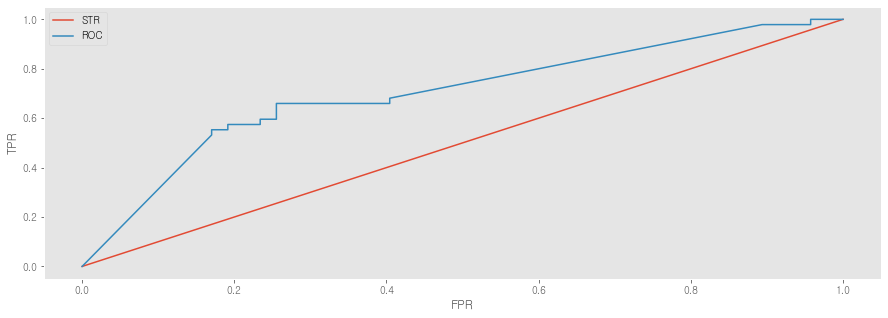

In [78]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=mlp.predict_proba(x_test_rftree_mlp25)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [79]:
auc = roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('mlp_25')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 30

In [81]:
# train,valid 나누기
# exp : 학습 중이란 뜻
x_train_rftree_mlp30_exp, x_val_rftree_mlp30_exp,\
y_train_rftree_mlp30_exp, y_val_rftree_mlp30_exp = train_test_split(x_train_rftree_mlp30,y_train,stratify=y_train,\
                                                  test_size=0.2,random_state=42)  # 훈련 데이터와 검증 데이터 분류


In [82]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 4,log=False)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 20, 100,log=False))
    clf = MLPClassifier(hidden_layer_sizes=tuple(layers),
                                                activation='relu', \
                                                solver='adam', alpha=0.01, batch_size=32, \
                                                learning_rate_init=0.1, max_iter=500,random_state=42)
    clf.fit(x_train_rftree_mlp30_exp, np.ravel(y_train_rftree_mlp30_exp))

    return clf.score(x_val_rftree_mlp30_exp, np.ravel(y_val_rftree_mlp30_exp))

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

In [84]:
print("best params : ",study.best_params)
mlp = MLPClassifier(hidden_layer_sizes = list(study.best_params.values())[1:],
                    activation='relu', \
                    solver='adam', alpha=0.01, batch_size=32, \
                    learning_rate_init=0.1, max_iter=500,random_state=42)  # 객체 생성

mlp.fit(x_train_rftree_mlp30_exp, np.ravel(y_train_rftree_mlp30_exp))    # 훈련하기

print("훈련 세트 정확도: {:.3f}".format(mlp.score(x_train_rftree_mlp30_exp, np.ravel(y_train_rftree_mlp30_exp) ) ) )
print("검증 세트 정확도: {:.3f}".format(mlp.score(x_val_rftree_mlp30_exp, np.ravel(y_val_rftree_mlp30_exp) ) ) )
print("테스트 세트 정확도: {:.3f}".format(mlp.score(x_test_rftree_mlp30, np.ravel(y_test) ) ) )
predicted = mlp.predict(x_test_rftree_mlp30)

best params :  {'n_layers': 2, 'n_units_0': 96, 'n_units_1': 74}
훈련 세트 정확도: 0.843
검증 세트 정확도: 0.787
테스트 세트 정확도: 0.628


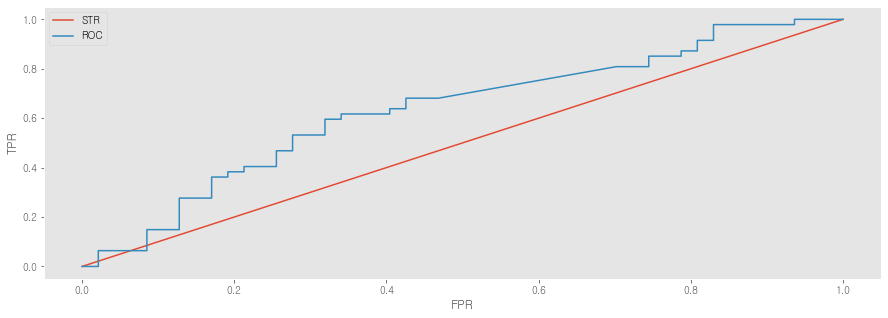

In [85]:
#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label=mlp.predict_proba(x_test_rftree_mlp30)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()


In [86]:
auc = roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('mlp_30')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


In [87]:
test_mlp= pd.concat([pd.DataFrame(names),
                     pd.DataFrame(aucs),
                     pd.DataFrame(accs),
                     pd.DataFrame(recalls_list),
                     pd.DataFrame(specificitys),
                     pd.DataFrame(f1s)
                    ],axis=1)
test_mlp.columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1']

In [88]:
test_mlp.sort_values("name")

,name,AUC,ACC,RECALL,SPECIFICITY,F1
2,mlp_10,0.733364,0.680851,0.595745,0.765957,0.651163
3,mlp_15,0.718651,0.670213,0.553191,0.787234,0.626506
4,mlp_17,0.732911,0.702128,0.723404,0.680851,0.708333
1,mlp_20,0.728158,0.702128,0.659574,0.744681,0.688889
5,mlp_25,0.703486,0.691489,0.659574,0.723404,0.681319
6,mlp_30,0.633318,0.627660,0.680851,0.574468,0.646465
0,mlp_base,0.646446,0.627660,0.702128,0.553191,0.653465


## Ensemble

In [123]:
numeric_cols=[]
for idx,col in enumerate(x_train.columns):
    col_type = x_train[col].dtype
    if col_type.name !='category':
        numeric_cols.append(col)

In [124]:
#표준화
scaler = StandardScaler()

x_train_base_ensemble = x_train.copy()
x_test_base_ensemble = x_test.copy()


x_train_base_ensemble[numeric_cols] = scaler.fit_transform(x_train_base_ensemble[numeric_cols])
x_test_base_ensemble[numeric_cols] = scaler.transform(x_test_base_ensemble[numeric_cols])




In [125]:
x_train_rftree_ensemble20=x_train_base_ensemble[col_all[:20]]
x_test_rftree_ensemble20=x_test_base_ensemble[col_all[:20]]

x_train_rftree_ensemble10=x_train_base_ensemble[col_all[:10]]
x_test_rftree_ensemble10=x_test_base_ensemble[col_all[:10]]

x_train_rftree_ensemble15=x_train_base_ensemble[col_all[:15]]
x_test_rftree_ensemble15=x_test_base_ensemble[col_all[:15]]

x_train_rftree_ensemble17=x_train_base_ensemble[col_all[:17]]
x_test_rftree_ensemble17=x_test_base_ensemble[col_all[:17]]

x_train_rftree_ensemble25=x_train_base_ensemble[col_all[:25]]
x_test_rftree_ensemble25=x_test_base_ensemble[col_all[:25]]

x_train_rftree_ensemble30=x_train_base_ensemble[col_all[:30]]
x_test_rftree_ensemble30=x_test_base_ensemble[col_all[:30]]




### baseline

In [126]:
test_ensemble = pd.DataFrame(columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1'])
test_ensemble

,name,AUC,ACC,RECALL,SPECIFICITY,F1


In [127]:
names=[]
aucs=[]
accs=[]
recalls_list=[]
specificitys=[]
f1s=[]

In [128]:
# ensemble 할 model 정의
models = [
    ('gbc', GradientBoostingClassifier(learning_rate= 0.067,n_estimators=10,random_state=42 ) ),
    ('rfc', RandomForestClassifier(n_estimators=230, max_depth= 1,random_state=42) ),
    ('svc', svm.SVC(C=0.1,probability=True,random_state=42)),
    ('lr', LogisticRegressionCV(random_state=42)),
    ('mlp',MLPClassifier(hidden_layer_sizes=(73,), activation='relu', \
                    solver='adam', alpha=0.01, batch_size=32, \
                    learning_rate_init=0.1, max_iter=500,random_state=42))
]


# soft vote
soft_vote  = VotingClassifier(models, voting='soft')
#soft_vote_cv = cross_validate(soft_vote, x_train_base_ensemble, np.ravel(y_train), cv=5)
soft_vote.fit(x_train_base_ensemble, np.ravel(y_train))
print(soft_vote)

VotingClassifier(estimators=[('gbc',
                              GradientBoostingClassifier(learning_rate=0.067,
                                                         n_estimators=10,
                                                         random_state=42)),
                             ('rfc',
                              RandomForestClassifier(max_depth=1,
                                                     n_estimators=230,
                                                     random_state=42)),
                             ('svc',
                              SVC(C=0.1, probability=True, random_state=42)),
                             ('lr', LogisticRegressionCV(random_state=42)),
                             ('mlp',
                              MLPClassifier(alpha=0.01, batch_size=32,
                                            hidden_layer_sizes=(73,),
                                            learning_rate_init=0.1,
                                            max_iter

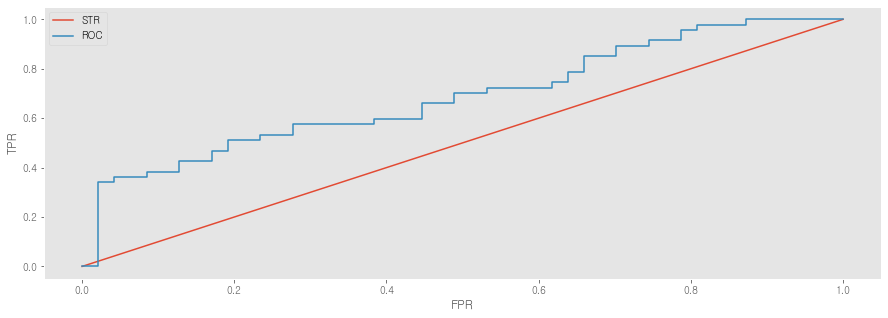

In [129]:
predicted=soft_vote.predict(x_test_base_ensemble)

#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label = soft_vote.predict_proba(x_test_base_ensemble)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()



In [130]:
auc = roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('ensemble_base')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


In [131]:
test_ensemble= pd.concat([pd.DataFrame(names),
                     pd.DataFrame(aucs),
                     pd.DataFrame(accs),
                     pd.DataFrame(recalls_list),
                     pd.DataFrame(specificitys),
                     pd.DataFrame(f1s)
                    ],axis=1)
test_ensemble.columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1']

In [132]:
test_ensemble

,name,AUC,ACC,RECALL,SPECIFICITY,F1
0,ensemble_base,0.686283,0.62766,0.574468,0.680851,0.606742


### reduced (20)

In [133]:
# ensemble 할 model 정의
models = [
    ('gbc', GradientBoostingClassifier(learning_rate= 0.02,n_estimators=26,random_state=42)),
    ('rfc', RandomForestClassifier(n_estimators=240, max_depth= 1,random_state=42) ),
    ('svc', svm.SVC(C=0.1,probability=True,random_state=42)),
    ('lr', LogisticRegressionCV(random_state=42)),
    ('mlp',MLPClassifier(hidden_layer_sizes=(40,27), activation='relu', \
                    solver='adam', alpha=0.01, batch_size=32, \
                    learning_rate_init=0.1, max_iter=500,random_state=42))
]


# soft vote
soft_vote  = VotingClassifier(models, voting='soft')
#soft_vote_cv = cross_validate(soft_vote, x_train_base_ensemble, np.ravel(y_train), cv=5)
soft_vote.fit(x_train_rftree_ensemble20, np.ravel(y_train))
print(soft_vote)

VotingClassifier(estimators=[('gbc',
                              GradientBoostingClassifier(learning_rate=0.02,
                                                         n_estimators=26,
                                                         random_state=42)),
                             ('rfc',
                              RandomForestClassifier(max_depth=1,
                                                     n_estimators=240,
                                                     random_state=42)),
                             ('svc',
                              SVC(C=0.1, probability=True, random_state=42)),
                             ('lr', LogisticRegressionCV(random_state=42)),
                             ('mlp',
                              MLPClassifier(alpha=0.01, batch_size=32,
                                            hidden_layer_sizes=(40, 27),
                                            learning_rate_init=0.1,
                                            max_it

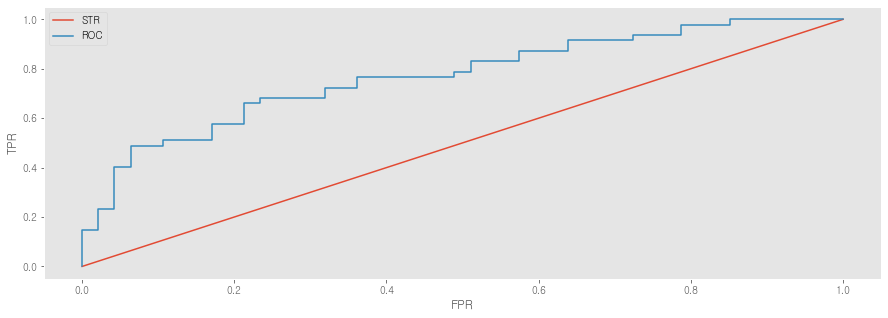

In [134]:
predicted=soft_vote.predict(x_test_rftree_ensemble20)

#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label = soft_vote.predict_proba(x_test_rftree_ensemble20)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()



In [135]:
auc = roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('ensemble_20')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 10

In [136]:
# ensemble 할 model 정의
models = [
    ('gbc', GradientBoostingClassifier(learning_rate= 0.02,n_estimators=26,random_state=42)),
    ('rfc', RandomForestClassifier(n_estimators=200, max_depth= 3,random_state=42) ),
    ('svc', svm.SVC(C=10,probability=True,random_state=42)),
    ('lr', LogisticRegressionCV(random_state=42)),
    ('mlp',MLPClassifier(hidden_layer_sizes=(29,26,90,27), activation='relu', \
                    solver='adam', alpha=0.01, batch_size=32, \
                    learning_rate_init=0.1, max_iter=500,random_state=42))
]


# soft vote
soft_vote  = VotingClassifier(models, voting='soft')
#soft_vote_cv = cross_validate(soft_vote, x_train_base_ensemble, np.ravel(y_train), cv=5)
soft_vote.fit(x_train_rftree_ensemble10, np.ravel(y_train))
print(soft_vote)

VotingClassifier(estimators=[('gbc',
                              GradientBoostingClassifier(learning_rate=0.02,
                                                         n_estimators=26,
                                                         random_state=42)),
                             ('rfc',
                              RandomForestClassifier(max_depth=3,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('svc',
                              SVC(C=10, probability=True, random_state=42)),
                             ('lr', LogisticRegressionCV(random_state=42)),
                             ('mlp',
                              MLPClassifier(alpha=0.01, batch_size=32,
                                            hidden_layer_sizes=(29, 26, 90, 27),
                                            learning_rate_init=0.1,
                                           

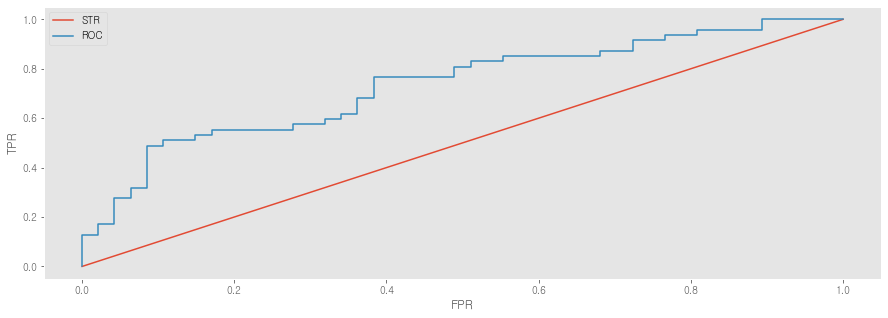

In [137]:
predicted=soft_vote.predict(x_test_rftree_ensemble10)

#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label = soft_vote.predict_proba(x_test_rftree_ensemble10)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()



In [138]:
auc = roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('ensemble_10')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 15

In [139]:
# ensemble 할 model 정의
models = [
    ('gbc', GradientBoostingClassifier(learning_rate= 0.02,n_estimators=26,random_state=42)),
    ('rfc', RandomForestClassifier(n_estimators=200, max_depth= 3,random_state=42) ),
    ('svc', svm.SVC(C=0.1,probability=True,random_state=42)),
    ('lr', LogisticRegressionCV(random_state=42)),
    ('mlp',MLPClassifier(hidden_layer_sizes=(37,62,50,97), activation='relu', \
                    solver='adam', alpha=0.01, batch_size=32, \
                    learning_rate_init=0.1, max_iter=500,random_state=42))
]


# soft vote
soft_vote  = VotingClassifier(models, voting='soft')
#soft_vote_cv = cross_validate(soft_vote, x_train_base_ensemble, np.ravel(y_train), cv=5)
soft_vote.fit(x_train_rftree_ensemble15, np.ravel(y_train))
print(soft_vote)

VotingClassifier(estimators=[('gbc',
                              GradientBoostingClassifier(learning_rate=0.02,
                                                         n_estimators=26,
                                                         random_state=42)),
                             ('rfc',
                              RandomForestClassifier(max_depth=3,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('svc',
                              SVC(C=0.1, probability=True, random_state=42)),
                             ('lr', LogisticRegressionCV(random_state=42)),
                             ('mlp',
                              MLPClassifier(alpha=0.01, batch_size=32,
                                            hidden_layer_sizes=(37, 62, 50, 97),
                                            learning_rate_init=0.1,
                                          

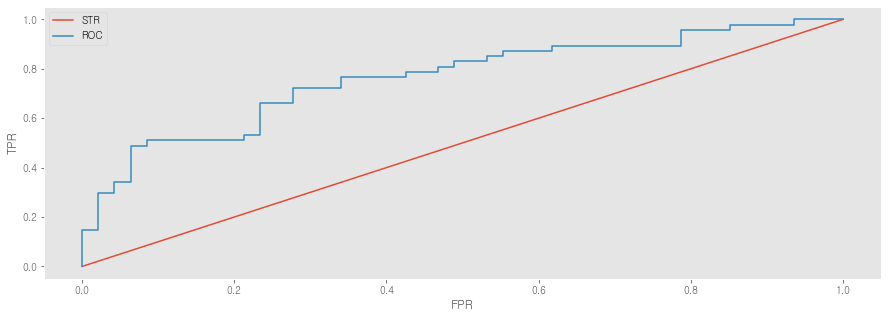

In [140]:
predicted=soft_vote.predict(x_test_rftree_ensemble15)

#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label = soft_vote.predict_proba(x_test_rftree_ensemble15)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()



In [141]:
auc = roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('ensemble_15')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 17

In [142]:
# ensemble 할 model 정의
models = [
    ('gbc', GradientBoostingClassifier(learning_rate= 0.07,n_estimators=11,random_state=42)),
    ('rfc', RandomForestClassifier(n_estimators=240, max_depth= 2,random_state=42) ),
    ('svc', svm.SVC(C=0.1,probability=True,random_state=42)),
    ('lr', LogisticRegressionCV(random_state=42)),
    ('mlp',MLPClassifier(hidden_layer_sizes=(61,33,100), activation='relu', \
                    solver='adam', alpha=0.01, batch_size=32, \
                    learning_rate_init=0.1, max_iter=500,random_state=42))
]


# soft vote
soft_vote  = VotingClassifier(models, voting='soft')
#soft_vote_cv = cross_validate(soft_vote, x_train_base_ensemble, np.ravel(y_train), cv=5)
soft_vote.fit(x_train_rftree_ensemble17, np.ravel(y_train))
print(soft_vote)

VotingClassifier(estimators=[('gbc',
                              GradientBoostingClassifier(learning_rate=0.07,
                                                         n_estimators=11,
                                                         random_state=42)),
                             ('rfc',
                              RandomForestClassifier(max_depth=2,
                                                     n_estimators=240,
                                                     random_state=42)),
                             ('svc',
                              SVC(C=0.1, probability=True, random_state=42)),
                             ('lr', LogisticRegressionCV(random_state=42)),
                             ('mlp',
                              MLPClassifier(alpha=0.01, batch_size=32,
                                            hidden_layer_sizes=(61, 33, 100),
                                            learning_rate_init=0.1,
                                            m

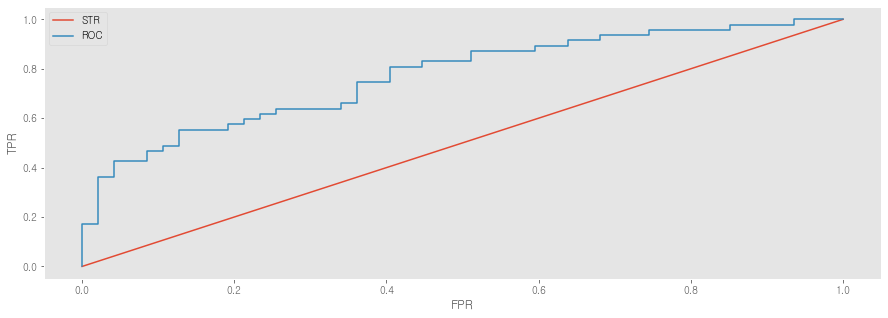

In [143]:
predicted=soft_vote.predict(x_test_rftree_ensemble17)

#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label = soft_vote.predict_proba(x_test_rftree_ensemble17)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()



In [144]:
auc = roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('ensemble_17')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 25

In [114]:
# ensemble 할 model 정의
models = [
    ('gbc', GradientBoostingClassifier(learning_rate= 0.07,n_estimators=11,random_state=42)),
    ('rfc', RandomForestClassifier(n_estimators=180, max_depth= 3,random_state=42) ),
    ('svc', svm.SVC(C=0.1,probability=True,random_state=42)),
    ('lr', LogisticRegressionCV(random_state=42)),
    ('mlp',MLPClassifier(hidden_layer_sizes=(57,33,42), activation='relu', \
                    solver='adam', alpha=0.01, batch_size=32, \
                    learning_rate_init=0.1, max_iter=500,random_state=42))
]


# soft vote
soft_vote  = VotingClassifier(models, voting='soft')
#soft_vote_cv = cross_validate(soft_vote, x_train_base_ensemble, np.ravel(y_train), cv=5)
soft_vote.fit(x_train_rftree_ensemble25, np.ravel(y_train))
print(soft_vote)

VotingClassifier(estimators=[('gbc',
                              GradientBoostingClassifier(learning_rate=0.07,
                                                         n_estimators=11,
                                                         random_state=42)),
                             ('rfc',
                              RandomForestClassifier(max_depth=3,
                                                     n_estimators=180,
                                                     random_state=42)),
                             ('svc',
                              SVC(C=0.1, probability=True, random_state=42)),
                             ('lr', LogisticRegressionCV(random_state=42)),
                             ('mlp',
                              MLPClassifier(alpha=0.01, batch_size=32,
                                            hidden_layer_sizes=(57, 33, 42),
                                            learning_rate_init=0.1,
                                            ma

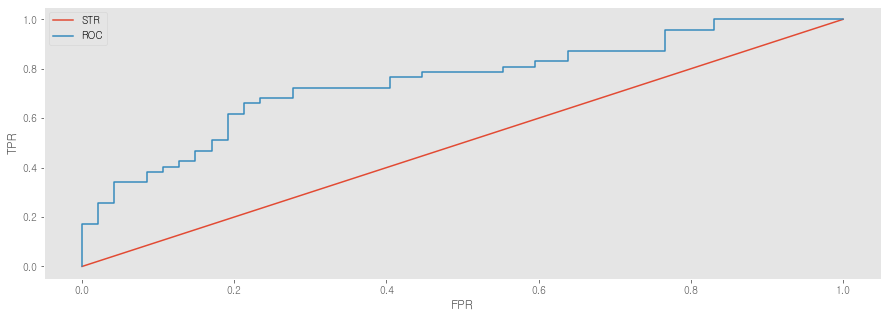

In [115]:
predicted=soft_vote.predict(x_test_rftree_ensemble25)

#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label = soft_vote.predict_proba(x_test_rftree_ensemble25)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()



In [116]:
auc = roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('ensemble_25')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


### 변수 30

In [117]:
# ensemble 할 model 정의
models = [
    ('gbc', GradientBoostingClassifier(learning_rate= 0.02,n_estimators=26,random_state=42)),
    ('rfc', RandomForestClassifier(n_estimators=240, max_depth= 1,random_state=42) ),
    ('svc', svm.SVC(C=0.1,probability=True,random_state=42)),
    ('lr', LogisticRegressionCV(random_state=42)),
    ('mlp',MLPClassifier(hidden_layer_sizes=(96,74), activation='relu', \
                    solver='adam', alpha=0.01, batch_size=32, \
                    learning_rate_init=0.1, max_iter=500,random_state=42))
]


# soft vote
soft_vote  = VotingClassifier(models, voting='soft')
#soft_vote_cv = cross_validate(soft_vote, x_train_base_ensemble, np.ravel(y_train), cv=5)
soft_vote.fit(x_train_rftree_ensemble30, np.ravel(y_train))
print(soft_vote)

VotingClassifier(estimators=[('gbc',
                              GradientBoostingClassifier(learning_rate=0.02,
                                                         n_estimators=26,
                                                         random_state=42)),
                             ('rfc',
                              RandomForestClassifier(max_depth=1,
                                                     n_estimators=240,
                                                     random_state=42)),
                             ('svc',
                              SVC(C=0.1, probability=True, random_state=42)),
                             ('lr', LogisticRegressionCV(random_state=42)),
                             ('mlp',
                              MLPClassifier(alpha=0.01, batch_size=32,
                                            hidden_layer_sizes=(96, 74),
                                            learning_rate_init=0.1,
                                            max_it

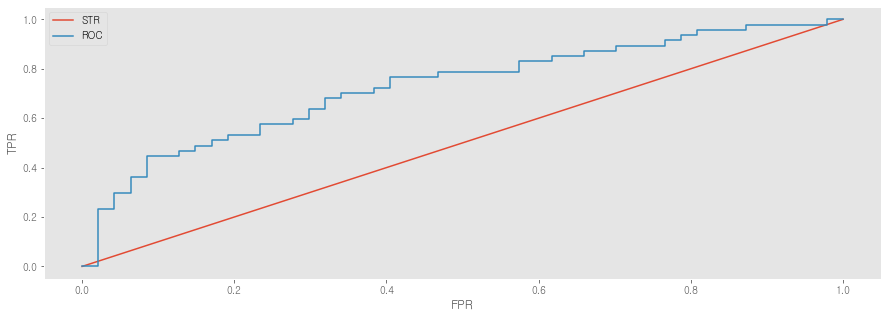

In [118]:
predicted=soft_vote.predict(x_test_rftree_ensemble30)

#baseline - rf tree / roc curve
from sklearn.metrics import roc_curve
#레이블 1일때 예측 확률
pred_positive_label = soft_vote.predict_proba(x_test_rftree_ensemble30)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_positive_label)
precisions,recalls,thresholds = roc_curve(y_test,pred_positive_label)


plt.figure(figsize=(15,5))

#diagonal
plt.plot([0,1],[0,1],label='STR')

#ROC

plt.plot(fprs,tprs,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()



In [119]:
auc = roc_auc_score(y_test,pred_positive_label)
accuracy = accuracy_score(y_true=y_test,y_pred=predicted)
recall = recall_score(y_true=y_test, y_pred=predicted, pos_label=1)
specificity = recall_score(y_true=y_test, y_pred=predicted, pos_label=0)
f1 = f1_score(y_true=y_test, y_pred=predicted)


names.append('ensemble_30')
aucs.append(auc)
accs.append(accuracy)
recalls_list.append(recall)
specificitys.append(specificity)
f1s.append(f1)


In [120]:
test_ensemble= pd.concat([pd.DataFrame(names),
                     pd.DataFrame(aucs),
                     pd.DataFrame(accs),
                     pd.DataFrame(recalls_list),
                     pd.DataFrame(specificitys),
                     pd.DataFrame(f1s)
                    ],axis=1)
test_ensemble.columns=['name','AUC','ACC','RECALL','SPECIFICITY','F1']

In [121]:
test_ensemble.sort_values("name")

,name,AUC,ACC,RECALL,SPECIFICITY,F1
2,ensemble_10,0.732458,0.627660,0.574468,0.680851,0.606742
3,ensemble_15,0.763241,0.670213,0.574468,0.765957,0.635294
4,ensemble_17,0.770484,0.691489,0.595745,0.787234,0.658824
1,ensemble_20,0.769579,0.712766,0.680851,0.744681,0.703297
5,ensemble_25,0.747397,0.712766,0.659574,0.765957,0.696629
6,ensemble_30,0.726573,0.659574,0.574468,0.744681,0.627907
0,ensemble_base,0.686283,0.627660,0.574468,0.680851,0.606742


# 전체 비교

In [188]:
test_logistic.sort_values("name")

,name,AUC,ACC,RECALL,SPECIFICITY,F1
2,logistic_10,0.702580,0.521277,0.787234,0.255319,0.621849
3,logistic_15,0.699411,0.638298,0.808511,0.468085,0.690909
4,logistic_17,0.696243,0.595745,0.765957,0.425532,0.654545
1,logistic_20,0.701675,0.648936,0.765957,0.531915,0.685714
5,logistic_25,0.694885,0.648936,0.744681,0.553191,0.679612
6,logistic_30,0.668628,0.627660,0.723404,0.531915,0.660194
0,logistic_base,0.663649,0.659574,0.574468,0.744681,0.627907


In [189]:
test_svm.sort_values("name")

,name,AUC,ACC,RECALL,SPECIFICITY,F1
2,svm_10,0.753282,0.744681,0.617021,0.872340,0.707317
3,svm_15,0.747850,0.712766,0.553191,0.872340,0.658228
4,svm_17,0.751471,0.712766,0.553191,0.872340,0.658228
1,svm_20,0.745586,0.712766,0.553191,0.872340,0.658228
5,svm_25,0.775011,0.723404,0.553191,0.893617,0.666667
6,svm_30,0.765957,0.712766,0.617021,0.808511,0.682353
0,svm_base,0.759620,0.691489,0.574468,0.808511,0.650602


In [62]:
test_rf.sort_values("name")

,name,AUC,ACC,RECALL,SPECIFICITY,F1
0,rf_10,0.762336,0.702128,0.553191,0.851064,0.650000
1,rf_15,0.758262,0.702128,0.595745,0.808511,0.666667
2,rf_17,0.749208,0.670213,0.553191,0.787234,0.626506
3,rf_25,0.753735,0.670213,0.553191,0.787234,0.626506
4,rf_30,0.751471,0.691489,0.638298,0.744681,0.674157
5,rf_base,0.761800,0.691000,0.574000,0.809000,0.651000


In [94]:
test_mlp.sort_values("name")

,name,AUC,ACC,RECALL,SPECIFICITY,F1
2,mlp_10,0.733364,0.680851,0.595745,0.765957,0.651163
3,mlp_15,0.718651,0.670213,0.553191,0.787234,0.626506
4,mlp_17,0.732911,0.702128,0.723404,0.680851,0.708333
1,mlp_20,0.728158,0.702128,0.659574,0.744681,0.688889
5,mlp_25,0.703486,0.691489,0.659574,0.723404,0.681319
6,mlp_30,0.633318,0.627660,0.680851,0.574468,0.646465
0,mlp_base,0.646446,0.627660,0.702128,0.553191,0.653465


In [122]:
test_ensemble.sort_values("name")

,name,AUC,ACC,RECALL,SPECIFICITY,F1
2,ensemble_10,0.732458,0.627660,0.574468,0.680851,0.606742
3,ensemble_15,0.763241,0.670213,0.574468,0.765957,0.635294
4,ensemble_17,0.770484,0.691489,0.595745,0.787234,0.658824
1,ensemble_20,0.769579,0.712766,0.680851,0.744681,0.703297
5,ensemble_25,0.747397,0.712766,0.659574,0.765957,0.696629
6,ensemble_30,0.726573,0.659574,0.574468,0.744681,0.627907
0,ensemble_base,0.686283,0.627660,0.574468,0.680851,0.606742


# metric

In [2]:
def get_precision_by_f1_recall(f1,recall):
    precision = f1*recall/(2*(recall-f1/2))
    return precision

In [4]:
print(get_precision_by_f1_recall(0.6407,0.7021))
print(get_precision_by_f1_recall(0.6510,0.574))
print(get_precision_by_f1_recall(0.7032,0.6808))
print(get_precision_by_f1_recall(0.6516,0.6170))
print(get_precision_by_f1_recall(0.6666,0.5531))


0.5891754682383761
0.7518591549295777
0.7271241798298907
0.6903111263736263
0.8387089626933574
